In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
import torch
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from se3_cnn import basis_kernels
from functools import partial
from se3_cnn.blocks import GatedBlock
from experiments.datasets.modelnet.modelnet_old import ModelNet10, Obj2Voxel, CacheNPY
from sklearn.model_selection import StratifiedKFold
import itertools

import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.benchmark = True

In [6]:
class _StratifiedKFold_Dataset:
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

class StratifiedKFold_Dataset:
    def __init__(self, dataset, n_splits):
        self.dataset = dataset
        self.splits = list(
            StratifiedKFold(
                n_splits=n_splits, 
                shuffle=True
            ).split(
                np.zeros(len(dataset)),
                [y for x, y in dataset]
            )
        )
    
    def trainset(self, i, dataset=None):
        return _StratifiedKFold_Dataset(self.dataset if dataset is None else dataset, self.splits[i][0])
    
    def testset(self, i, dataset=None):
        return _StratifiedKFold_Dataset(self.dataset if dataset is None else dataset, self.splits[i][1])

In [7]:
def compose(t1, t2):
    def f(x):
        return t2(t1(x))
    return f

def to_tensor(x):
    x = np.array(x).astype(np.uint8)
    x = torch.tensor(x, dtype=torch.float)
    x = x.unsqueeze(1 if x.dim() == 4 else 0)
    x = x / 8
    return x

classes = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
def target_transform(x):
    return classes.index(x)

cache = CacheNPY("r32dd", repeat=1, transform=Obj2Voxel(32, rotate=True, double=True, diagonal_bounding_box=True))
setR = ModelNet10("./root/", mode='train_full', 
                      classes=classes, 
                      download=True, 
                      transform=compose(cache, to_tensor), 
                      target_transform=target_transform)

cache = CacheNPY("nr32dd", repeat=1, transform=Obj2Voxel(32, rotate=False, double=True, diagonal_bounding_box=True))
setNR = ModelNet10("./root/", mode='train_full', 
                      classes=classes, 
                      download=True, 
                      transform=compose(cache, to_tensor), 
                      target_transform=target_transform)

cache = CacheNPY("azr32dd", 
                 repeat=10,  # (9) 5 -> 10
                 transform=Obj2Voxel(32, 
                                     rotate=False, 
                                     zrotate=True, 
                                     double=True, 
                                     diagonal_bounding_box=True))
setAZR = ModelNet10("./root/", mode='train_full', 
                      classes=classes, 
                      download=True, 
                      transform=compose(cache, to_tensor), 
                      target_transform=target_transform)

cache = CacheNPY("azr32dd", 
                 repeat=10, 
                 pick_randomly=False, 
                 transform=Obj2Voxel(32, 
                                     rotate=False, 
                                     zrotate=True, 
                                     double=True, 
                                     diagonal_bounding_box=True))
setAZRE = ModelNet10("./root/", mode='train_full', 
                      classes=classes, 
                      download=True, 
                      transform=compose(cache, to_tensor), 
                      target_transform=target_transform)



skf = StratifiedKFold_Dataset(setR, 4)

In [8]:
setAZRE[0][0].size()

torch.Size([10, 1, 32, 32, 32])

In [9]:
def plot_repr(x):
    plt.imshow(x[0].detach().cpu().numpy().mean(-1))

In [10]:
class AvgSpacial(torch.nn.Module):
    def forward(self, inp):  # pylint: disable=W
        # inp [batch, features, x, y, z]
        return inp.view(inp.size(0), inp.size(1), -1).mean(-1)  # [batch, features]


class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.int_repr = None

        features = [  # all
            (1, ),
            (2, 2, 2),
            (4, 4, 4),
            (8, 8, 8),
            (100, )
        ]
        features = [  # (6) double all channels
            (1, ),
            (4, 4, 4),
            (8, 8, 8),
            (16, 16, 16),
            (200, )
        ]
        features = [  # (9)
            (1, ),
            (3, 3, 3),
            (6, 6, 6),
            (12, 12, 12),
            (150, )
        ]
            
        radial_window = partial(basis_kernels.gaussian_window_fct_convenience_wrapper,
                                mode='compromise', border_dist=0, sigma=0.6)

        common_block_params = {
            'size': 5,  # (5) = 5->7
            'stride': 2,
            'padding': 3,
            'normalization': 'batch',
            'radial_window': radial_window,
            'capsule_dropout_p': 0.1  # (4) Maurice suggestion
        }

        block_params = [
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
        ]

        assert len(block_params) + 1 == len(features)

        blocks = [
            GatedBlock(features[i], features[i + 1], **common_block_params, **block_params[i])
            for i in range(len(block_params))
        ]

        self.sequence = torch.nn.Sequential(
            *blocks,
            AvgSpacial(),
            nn.Linear(features[-1][0], 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):  # pylint: disable=W
        '''
        :param x: [batch, features, x, y, z]
        '''
        
        self.int_repr = []

        for m in self.sequence:
            x = m(x)
            #print(x.size())
            self.int_repr.append(x)
        #x = self.sequence(x)  # [batch, features]

        return x
    
    
class PickZcomponent(torch.nn.Module):
    def __init__(self, R):
        super().__init__()
        self.scalars, self.vectors = R[0], R[1]
        
    def forward(self, inp):  # pylint: disable=W
        # inp [batch, features, ...]
        s = inp[:, :self.scalars]
        x = inp[:, self.scalars + 0::3]
        y = inp[:, self.scalars + 1::3]
        z = inp[:, self.scalars + 2::3]
        return torch.cat((s, (x ** 2 + y ** 2) ** 0.5, z), dim=1)

    
class CNNZ(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        self.int_repr = None

        features = [
            (1, ),
            (2, 2, 2),
            (4, 4, 4),
            (8, 8, 8),
            (100, 25)
        ]

        radial_window = partial(basis_kernels.gaussian_window_fct_convenience_wrapper,
                                mode='compromise', border_dist=0, sigma=0.6)

        common_block_params = {
            'size': 7,
            'stride': 2,
            'padding': 3,
            'normalization': 'batch',
            'radial_window': radial_window
        }

        block_params = [
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
            {'activation': (F.relu, F.sigmoid)},
        ]

        assert len(block_params) + 1 == len(features)

        blocks = [
            GatedBlock(features[i], features[i + 1], **common_block_params, **block_params[i])
            for i in range(len(block_params))
        ]

        self.sequence = torch.nn.Sequential(
            *blocks,
            AvgSpacial(),
            PickZcomponent(features[-1]),
            nn.Linear(features[-1][0] + 2 * features[-1][1], 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):  # pylint: disable=W
        '''
        :param x: [batch, features, x, y, z]
        '''
        
        self.int_repr = []

        for m in self.sequence:
            x = m(x)
            #print(x.size())
            self.int_repr.append(x)
        #x = self.sequence(x)  # [batch, features]

        return x

In [11]:
def train(model, dataset, n_epoch):
    batch_size = 64
    
    model.train()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-8)  # weight_decay (4) Maurice suggestion
    
    data = []

    for epoch in range(n_epoch):
        
        if epoch in [50, 100, 150]: # [50, 100, 150] defore (8)
            #for pg in optimizer.param_groups:
            #    pg['lr'] /= 3  # (4)  
            # (8) replace by
            batch_size *= 2
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            
        
        for i, (input, target) in enumerate(dataloader):
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # forward and backward propagation
            output = model(input)
            loss = F.nll_loss(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # download results on the CPU
            loss = loss.detach().cpu().item()
            output = output.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            # compute the accuracy
            acc = float(np.sum(output.argmax(-1) == target) / target.size)
            
            data.append({
                "epoch": epoch,
                "i": i / len(dataloader),
                "loss": loss,
                "accuracy": acc
            })

            print("{}:{}/{}: acc={}% loss={}".format(epoch, i, len(dataloader), 100 * acc, loss))
    return data


def test(model, dataset):
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)
        
    correct = 0
    for i, (input, target) in enumerate(dataloader):
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
            
        if input.dim() == 6: # eval augmentation
            an = input.size(1)
            input = input.view(-1, *input.size()[2:])
        else:
            an = None

        # forward and backward propagation
        output = model(input)
        
        if an:
            output = output.view(-1, an, *output.size()[1:])
            output = output.mean(1)

        # download results on the CPU
        output = output.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        # compute the accuracy
        correct += np.sum(output.argmax(-1) == target)

        print("{}/{}".format(i, len(dataloader)))
    
    return correct / len(dataset)


def confusion_matrix(model, dataset):
    from sklearn.metrics import confusion_matrix
    
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)
    
    y_true = []
    y_pred = []
    
    for i, (input, target) in enumerate(dataloader):
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
            
        if input.dim() == 6: # eval augmentation
            an = input.size(1)
            input = input.view(-1, *input.size()[2:])
        else:
            an = None

        # forward and backward propagation
        output = model(input)
        
        if an:
            output = output.view(-1, an, *output.size()[1:])
            output = output.mean(1)

        # download results on the CPU
        output = output.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        y_true += list(target)
        y_pred += list(output.argmax(-1))
    
    return confusion_matrix(y_true, y_pred)

In [12]:
def plot(data):
    plt.plot([x['epoch'] + x['i'] for x in data], [x['loss'] for x in data])
    plt.yscale('log')

load Q_J_cache/0.pkl.gz... done
repr1 -> repr1 : Created 3 basis elements with equivariance [1.00580319 0.96155688 0.61208142]
load Q_J_cache/1.pkl.gz... done
repr1 -> repr3 : Created 2 basis elements with equivariance [0.9427308  0.59909652]
load Q_J_cache/2.pkl.gz... done
repr1 -> repr5 : Created 2 basis elements with equivariance [0.85520043 0.6135118 ]
load Q_J_cache/0.pkl.gz... done
repr1 -> repr1 : Created 3 basis elements with equivariance [1.00970097 0.95551453 0.60015365]
load Q_J_cache/0.pkl.gz... done
repr1 -> repr1 : Created 3 basis elements with equivariance [1.00635551 0.96061812 0.62173472]
load Q_J_cache/3.pkl.gz... done
repr3 -> repr1 : Created 2 basis elements with equivariance [0.93904914 0.56738268]
load Q_J_cache/4.pkl.gz... done
repr5 -> repr1 : Created 2 basis elements with equivariance [0.85841567 0.61555438]
load Q_J_cache/1.pkl.gz... done
repr1 -> repr3 : Created 2 basis elements with equivariance [0.94593272 0.60009955]
load Q_J_cache/5.pkl.gz... done
load Q_

transform ./root/ModelNet10/bed/train/bed_0330.obj...
transform ./root/ModelNet10/bed/train/bed_0384.obj...
transform ./root/ModelNet10/monitor/train/monitor_0270.obj...
transform ./root/ModelNet10/sofa/train/sofa_0220.obj...
transform ./root/ModelNet10/desk/train/desk_0078.obj...
transform ./root/ModelNet10/toilet/train/toilet_0139.obj...
0:0/46: acc=25.0% loss=2.454744338989258
transform ./root/ModelNet10/night_stand/train/night_stand_0053.obj...
transform ./root/ModelNet10/sofa/train/sofa_0438.obj...
transform ./root/ModelNet10/sofa/train/sofa_0525.obj...
transform ./root/ModelNet10/table/train/table_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0390.obj...
transform ./root/ModelNet10/monitor/validation/monitor_0456.obj...
transform ./root/ModelNet10/chair/train/chair_0519.obj...
transform ./root/ModelNet10/table/train/table_0246.obj...
transform ./root/ModelNet10/monitor/train/monitor_0030.obj...
transform ./root/ModelNet10/monitor/train/monitor_0172.obj...
transform ./

transform ./root/ModelNet10/monitor/train/monitor_0264.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0102.obj...
transform ./root/ModelNet10/toilet/train/toilet_0067.obj...
transform ./root/ModelNet10/sofa/train/sofa_0111.obj...
transform ./root/ModelNet10/sofa/train/sofa_0410.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0073.obj...
transform ./root/ModelNet10/toilet/train/toilet_0095.obj...
transform ./root/ModelNet10/monitor/train/monitor_0326.obj...
transform ./root/ModelNet10/bed/train/bed_0475.obj...
transform ./root/ModelNet10/sofa/train/sofa_0207.obj...
transform ./root/ModelNet10/table/train/table_0289.obj...
transform ./root/ModelNet10/sofa/train/sofa_0196.obj...
transform ./root/ModelNet10/monitor/train/monitor_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0452.obj...
transform ./root/ModelNet10/bed/train/bed_0338.obj...
transform ./root/ModelNet10/monitor/train/monitor_0382.obj...
transform ./root/ModelNet10/sofa/train/sofa_0178.obj...
t

transform ./root/ModelNet10/bed/validation/bed_0515.obj...
transform ./root/ModelNet10/table/train/table_0280.obj...
transform ./root/ModelNet10/monitor/train/monitor_0186.obj...
transform ./root/ModelNet10/bed/train/bed_0115.obj...
transform ./root/ModelNet10/chair/train/chair_0633.obj...
transform ./root/ModelNet10/dresser/train/dresser_0148.obj...
transform ./root/ModelNet10/desk/train/desk_0005.obj...
transform ./root/ModelNet10/chair/train/chair_0572.obj...
transform ./root/ModelNet10/sofa/train/sofa_0654.obj...
transform ./root/ModelNet10/desk/train/desk_0125.obj...
transform ./root/ModelNet10/bed/train/bed_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0652.obj...
transform ./root/ModelNet10/sofa/train/sofa_0208.obj...
transform ./root/ModelNet10/sofa/train/sofa_0199.obj...
transform ./root/ModelNet10/chair/train/chair_0495.obj...
transform ./root/ModelNet10/sofa/train/sofa_0432.obj...
transform ./root/ModelNet10/monitor/train/monitor_0087.obj...
transform ./root/Mode

transform ./root/ModelNet10/desk/train/desk_0147.obj...
transform ./root/ModelNet10/chair/train/chair_0299.obj...
transform ./root/ModelNet10/bed/train/bed_0154.obj...
transform ./root/ModelNet10/bed/train/bed_0441.obj...
transform ./root/ModelNet10/table/train/table_0331.obj...
transform ./root/ModelNet10/bed/train/bed_0413.obj...
transform ./root/ModelNet10/monitor/train/monitor_0343.obj...
transform ./root/ModelNet10/table/train/table_0105.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0053.obj...
transform ./root/ModelNet10/sofa/train/sofa_0057.obj...
transform ./root/ModelNet10/bed/train/bed_0119.obj...
transform ./root/ModelNet10/sofa/train/sofa_0492.obj...
transform ./root/ModelNet10/monitor/train/monitor_0014.obj...
transform ./root/ModelNet10/sofa/train/sofa_0039.obj...
transform ./root/ModelNet10/chair/train/chair_0361.obj...
transform ./root/ModelNet10/table/train/table_0065.obj...
transform ./root/ModelNet10/monitor/train/monitor_0064.obj...
transform ./root/Model

transform ./root/ModelNet10/monitor/train/monitor_0416.obj...
transform ./root/ModelNet10/dresser/train/dresser_0061.obj...
transform ./root/ModelNet10/chair/train/chair_0345.obj...
transform ./root/ModelNet10/chair/train/chair_0675.obj...
transform ./root/ModelNet10/toilet/train/toilet_0197.obj...
transform ./root/ModelNet10/chair/train/chair_0162.obj...
transform ./root/ModelNet10/toilet/train/toilet_0010.obj...
transform ./root/ModelNet10/chair/train/chair_0233.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0636.obj...
transform ./root/ModelNet10/bed/train/bed_0138.obj...
transform ./root/ModelNet10/sofa/train/sofa_0461.obj...
transform ./root/ModelNet10/dresser/train/dresser_0053.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0173.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0182.obj...
transform ./root/ModelNet10/bed/train/bed_0497.obj...
transform ./root/ModelNet10/bed/train/

transform ./root/ModelNet10/sofa/train/sofa_0180.obj...
transform ./root/ModelNet10/chair/train/chair_0854.obj...
transform ./root/ModelNet10/toilet/train/toilet_0328.obj...
transform ./root/ModelNet10/sofa/train/sofa_0151.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0190.obj...
transform ./root/ModelNet10/bed/train/bed_0387.obj...
transform ./root/ModelNet10/table/train/table_0357.obj...
transform ./root/ModelNet10/chair/train/chair_0789.obj...
transform ./root/ModelNet10/sofa/train/sofa_0491.obj...
transform ./root/ModelNet10/table/train/table_0375.obj...
transform ./root/ModelNet10/chair/train/chair_0589.obj...
transform ./root/ModelNet10/monitor/train/monitor_0005.obj...
transform ./root/ModelNet10/sofa/train/sofa_0043.obj...
0:11/46: acc=14.0625% loss=2.4953620433807373
transform ./root/ModelNet10/chair/train/chair_0527.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0089.obj...
transform ./root/ModelNet10/chair/train/chair_0694.obj...
transform ./root

0:13/46: acc=28.125% loss=2.0512452125549316
transform ./root/ModelNet10/toilet/train/toilet_0017.obj...
transform ./root/ModelNet10/dresser/train/dresser_0120.obj...
transform ./root/ModelNet10/chair/train/chair_0283.obj...
transform ./root/ModelNet10/toilet/train/toilet_0151.obj...
transform ./root/ModelNet10/sofa/train/sofa_0441.obj...
transform ./root/ModelNet10/sofa/train/sofa_0659.obj...
transform ./root/ModelNet10/sofa/train/sofa_0135.obj...
transform ./root/ModelNet10/chair/train/chair_0859.obj...
transform ./root/ModelNet10/table/train/table_0204.obj...
transform ./root/ModelNet10/sofa/train/sofa_0274.obj...
transform ./root/ModelNet10/chair/train/chair_0150.obj...
transform ./root/ModelNet10/chair/train/chair_0615.obj...
transform ./root/ModelNet10/chair/train/chair_0327.obj...
transform ./root/ModelNet10/bed/train/bed_0084.obj...
transform ./root/ModelNet10/monitor/train/monitor_0063.obj...
transform ./root/ModelNet10/desk/train/desk_0096.obj...
transform ./root/ModelNet10/c

transform ./root/ModelNet10/chair/train/chair_0529.obj...
transform ./root/ModelNet10/bed/train/bed_0253.obj...
transform ./root/ModelNet10/sofa/train/sofa_0530.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0030.obj...
transform ./root/ModelNet10/chair/train/chair_0230.obj...
transform ./root/ModelNet10/monitor/train/monitor_0098.obj...
transform ./root/ModelNet10/sofa/train/sofa_0155.obj...
transform ./root/ModelNet10/chair/train/chair_0144.obj...
transform ./root/ModelNet10/bed/train/bed_0498.obj...
transform ./root/ModelNet10/chair/train/chair_0204.obj...
transform ./root/ModelNet10/bed/train/bed_0244.obj...
transform ./root/ModelNet10/chair/train/chair_0161.obj...
transform ./root/ModelNet10/sofa/train/sofa_0467.obj...
transform ./root/ModelNet10/toilet/train/toilet_0012.obj...
transform ./root/ModelNet10/table/train/table_0125.obj...
transform ./root/ModelNet10/bed/train/bed_0127.obj...
transform ./root/ModelNet10/chair/train/chair_0786.obj...
transform ./root/M

transform ./root/ModelNet10/toilet/train/toilet_0087.obj...
transform ./root/ModelNet10/bed/train/bed_0342.obj...
transform ./root/ModelNet10/toilet/train/toilet_0196.obj...
transform ./root/ModelNet10/chair/train/chair_0245.obj...
transform ./root/ModelNet10/bed/train/bed_0274.obj...
transform ./root/ModelNet10/toilet/train/toilet_0205.obj...
transform ./root/ModelNet10/bed/train/bed_0396.obj...
transform ./root/ModelNet10/bed/train/bed_0461.obj...
transform ./root/ModelNet10/sofa/train/sofa_0553.obj...
transform ./root/ModelNet10/sofa/train/sofa_0152.obj...
transform ./root/ModelNet10/table/train/table_0261.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0087.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0116.obj...
transform ./root/ModelNet10/bed/train/bed_0077.obj...
transform ./root/ModelNet10/sofa/train/sofa_0636.obj...
transform ./root/ModelNet10/toilet/train/toilet_0308.obj...
transform ./root/Mod

transform ./root/ModelNet10/table/train/table_0139.obj...
transform ./root/ModelNet10/chair/train/chair_0559.obj...
transform ./root/ModelNet10/bed/train/bed_0118.obj...
transform ./root/ModelNet10/monitor/train/monitor_0068.obj...
transform ./root/ModelNet10/toilet/train/toilet_0320.obj...
transform ./root/ModelNet10/table/train/table_0023.obj...
transform ./root/ModelNet10/monitor/train/monitor_0225.obj...
transform ./root/ModelNet10/chair/train/chair_0356.obj...
transform ./root/ModelNet10/sofa/train/sofa_0314.obj...
transform ./root/ModelNet10/chair/train/chair_0500.obj...
transform ./root/ModelNet10/monitor/train/monitor_0013.obj...
transform ./root/ModelNet10/bed/train/bed_0287.obj...
transform ./root/ModelNet10/chair/train/chair_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0122.obj...
transform ./root/ModelNet10/chair/train/chair_0835.obj...
transform ./root/ModelNet10/sofa/train/sofa_0072.obj...
transform ./root/ModelNet10/bed/train/bed_0145.obj...
transform ./root/M

transform ./root/ModelNet10/monitor/train/monitor_0401.obj...
transform ./root/ModelNet10/chair/train/chair_0698.obj...
transform ./root/ModelNet10/chair/train/chair_0315.obj...
transform ./root/ModelNet10/chair/train/chair_0747.obj...
transform ./root/ModelNet10/bed/train/bed_0286.obj...
transform ./root/ModelNet10/chair/train/chair_0265.obj...
transform ./root/ModelNet10/bed/train/bed_0061.obj...
transform ./root/ModelNet10/sofa/train/sofa_0504.obj...
transform ./root/ModelNet10/bed/train/bed_0202.obj...
transform ./root/ModelNet10/monitor/train/monitor_0414.obj...
transform ./root/ModelNet10/table/train/table_0367.obj...
transform ./root/ModelNet10/table/train/table_0095.obj...
transform ./root/ModelNet10/sofa/train/sofa_0505.obj...
transform ./root/ModelNet10/chair/train/chair_0600.obj...
transform ./root/ModelNet10/sofa/train/sofa_0015.obj...
transform ./root/ModelNet10/dresser/train/dresser_0104.obj...
transform ./root/ModelNet10/bed/train/bed_0106.obj...
0:22/46: acc=37.5% loss=

transform ./root/ModelNet10/toilet/train/toilet_0006.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0007.obj...
transform ./root/ModelNet10/chair/train/chair_0137.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0342.obj...
transform ./root/ModelNet10/sofa/train/sofa_0333.obj...
0:24/46: acc=31.25% loss=2.0600454807281494
transform ./root/ModelNet10/dresser/validation/dresser_0200.obj...
transform ./root/ModelNet10/sofa/train/sofa_0192.obj...
transform ./root/ModelNet10/bed/train/bed_0003.obj...
transform ./root/ModelNet10/table/train/table_0027.obj...
transform ./root/ModelNet10/bed/train/bed_0239.obj...
transform ./root/ModelNet10/sofa/train/sofa_0351.obj...
transform ./root/ModelNet10/chair/train/chair_0116.obj...
transform ./root/ModelNet10/sofa/train/sofa_0495.obj...
transform ./root/ModelNet10/table/train/table_0196.obj...
transform ./root/ModelNet10/bed/train/bed_0501.obj...
transform ./root/ModelNet10/bed/train/bed_0166.obj...
transform ./root/ModelNet10/be

transform ./root/ModelNet10/desk/validation/desk_0194.obj...
transform ./root/ModelNet10/monitor/train/monitor_0388.obj...
transform ./root/ModelNet10/table/train/table_0236.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0191.obj...
transform ./root/ModelNet10/toilet/train/toilet_0310.obj...
transform ./root/ModelNet10/dresser/train/dresser_0013.obj...
transform ./root/ModelNet10/chair/train/chair_0440.obj...
transform ./root/ModelNet10/chair/train/chair_0253.obj...
transform ./root/ModelNet10/sofa/train/sofa_0141.obj...
transform ./root/ModelNet10/bed/train/bed_0174.obj...
transform ./root/ModelNet10/dresser/train/dresser_0046.obj...
transform ./root/ModelNet10/bed/train/bed_0082.obj...
transform ./root/ModelNet10/sofa/train/sofa_0109.obj...
transform ./root/ModelNet10/monitor/train/monitor_0313.obj...
transform ./root/ModelNet10/chair/train/chair_0510.obj...
transform ./root/ModelNet10/toilet/train/toilet_0102.obj...
transform ./root/ModelNet10/bed/train/bed_03

transform ./root/ModelNet10/chair/train/chair_0226.obj...
transform ./root/ModelNet10/sofa/train/sofa_0078.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0045.obj...
transform ./root/ModelNet10/table/train/table_0020.obj...
transform ./root/ModelNet10/bed/train/bed_0322.obj...
transform ./root/ModelNet10/monitor/train/monitor_0034.obj...
transform ./root/ModelNet10/monitor/train/monitor_0203.obj...
transform ./root/ModelNet10/sofa/train/sofa_0165.obj...
transform ./root/ModelNet10/table/validation/table_0386.obj...
transform ./root/ModelNet10/dresser/train/dresser_0012.obj...
transform ./root/ModelNet10/desk/train/desk_0075.obj...
transform ./root/ModelNet10/sofa/train/sofa_0634.obj...
transform ./root/ModelNet10/bed/train/bed_0022.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0127.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0028.obj...
transform ./root/ModelNet10/sofa/train/sofa_0642.obj...
transform ./root/ModelNet10/monitor/train/monitor_037

transform ./root/ModelNet10/sofa/train/sofa_0317.obj...
transform ./root/ModelNet10/monitor/train/monitor_0311.obj...
transform ./root/ModelNet10/sofa/train/sofa_0496.obj...
transform ./root/ModelNet10/desk/train/desk_0007.obj...
transform ./root/ModelNet10/chair/train/chair_0809.obj...
transform ./root/ModelNet10/toilet/train/toilet_0094.obj...
transform ./root/ModelNet10/sofa/train/sofa_0456.obj...
transform ./root/ModelNet10/bed/train/bed_0325.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0019.obj...
transform ./root/ModelNet10/sofa/train/sofa_0645.obj...
transform ./root/ModelNet10/table/train/table_0232.obj...
transform ./root/ModelNet10/toilet/train/toilet_0302.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0140.obj...
transform ./root/ModelNet10/bed/train/bed_0379.obj...
transform ./root/ModelNet10/chair/train/chair_0334.obj...
transform ./root/ModelNet10/chair/train/chair_0629.obj...
transform ./root/ModelNet10/chair/train/chair_0878.obj...


transform ./root/ModelNet10/night_stand/train/night_stand_0008.obj...
transform ./root/ModelNet10/chair/train/chair_0576.obj...
transform ./root/ModelNet10/table/train/table_0272.obj...
transform ./root/ModelNet10/chair/train/chair_0155.obj...
transform ./root/ModelNet10/bed/train/bed_0465.obj...
transform ./root/ModelNet10/sofa/train/sofa_0023.obj...
transform ./root/ModelNet10/monitor/train/monitor_0290.obj...
transform ./root/ModelNet10/chair/train/chair_0568.obj...
transform ./root/ModelNet10/bed/train/bed_0462.obj...
transform ./root/ModelNet10/chair/train/chair_0461.obj...
transform ./root/ModelNet10/monitor/train/monitor_0001.obj...
transform ./root/ModelNet10/chair/train/chair_0122.obj...
transform ./root/ModelNet10/chair/train/chair_0211.obj...
transform ./root/ModelNet10/sofa/train/sofa_0359.obj...
transform ./root/ModelNet10/monitor/train/monitor_0054.obj...
transform ./root/ModelNet10/sofa/train/sofa_0639.obj...
transform ./root/ModelNet10/bed/train/bed_0123.obj...
transfor

transform ./root/ModelNet10/chair/train/chair_0198.obj...
transform ./root/ModelNet10/chair/train/chair_0491.obj...
transform ./root/ModelNet10/sofa/train/sofa_0475.obj...
transform ./root/ModelNet10/chair/train/chair_0053.obj...
transform ./root/ModelNet10/monitor/train/monitor_0052.obj...
transform ./root/ModelNet10/table/train/table_0117.obj...
transform ./root/ModelNet10/chair/train/chair_0692.obj...
transform ./root/ModelNet10/chair/train/chair_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0252.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0149.obj...
transform ./root/ModelNet10/chair/train/chair_0003.obj...
transform ./root/ModelNet10/monitor/train/monitor_0011.obj...
0:35/46: acc=42.1875% loss=1.7538437843322754
transform ./root/ModelNet10/table/train/table_0036.obj...
transform ./root/ModelNet10/desk/train/desk_0091.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0033.obj...
transform ./root/ModelNet10/bed/train/bed_0149.obj...
tran

transform ./root/ModelNet10/table/train/table_0040.obj...
transform ./root/ModelNet10/sofa/train/sofa_0107.obj...
0:37/46: acc=37.5% loss=1.8127012252807617
transform ./root/ModelNet10/chair/train/chair_0008.obj...
transform ./root/ModelNet10/table/train/table_0245.obj...
transform ./root/ModelNet10/bed/train/bed_0493.obj...
transform ./root/ModelNet10/sofa/train/sofa_0036.obj...
transform ./root/ModelNet10/chair/train/chair_0549.obj...
transform ./root/ModelNet10/chair/train/chair_0691.obj...
transform ./root/ModelNet10/table/train/table_0213.obj...
transform ./root/ModelNet10/dresser/train/dresser_0017.obj...
transform ./root/ModelNet10/sofa/train/sofa_0146.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0340.obj...
transform ./root/ModelNet10/chair/train/chair_0499.obj...
transform ./root/ModelNet10/table/train/table_0226.obj...
transform ./root/ModelNet10/monitor/train/monitor_0007.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0156.obj...
transform ./

transform ./root/ModelNet10/table/train/table_0378.obj...
transform ./root/ModelNet10/dresser/train/dresser_0089.obj...
transform ./root/ModelNet10/table/train/table_0028.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0056.obj...
transform ./root/ModelNet10/chair/train/chair_0028.obj...
transform ./root/ModelNet10/chair/train/chair_0343.obj...
transform ./root/ModelNet10/sofa/train/sofa_0523.obj...
transform ./root/ModelNet10/sofa/train/sofa_0295.obj...
transform ./root/ModelNet10/monitor/train/monitor_0046.obj...
transform ./root/ModelNet10/chair/train/chair_0541.obj...
transform ./root/ModelNet10/chair/train/chair_0509.obj...
transform ./root/ModelNet10/sofa/train/sofa_0053.obj...
transform ./root/ModelNet10/sofa/train/sofa_0522.obj...
transform ./root/ModelNet10/chair/train/chair_0742.obj...
transform ./root/ModelNet10/bed/train/bed_0072.obj...
transform ./root/ModelNet10/monitor/train/monitor_0184.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0020.obj...
transf

transform ./root/ModelNet10/toilet/train/toilet_0177.obj...
transform ./root/ModelNet10/desk/train/desk_0124.obj...
transform ./root/ModelNet10/bed/train/bed_0311.obj...
transform ./root/ModelNet10/bed/train/bed_0180.obj...
transform ./root/ModelNet10/monitor/train/monitor_0174.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0339.obj...
transform ./root/ModelNet10/chair/train/chair_0876.obj...
transform ./root/ModelNet10/bed/train/bed_0500.obj...
transform ./root/ModelNet10/table/train/table_0267.obj...
transform ./root/ModelNet10/desk/train/desk_0085.obj...
transform ./root/ModelNet10/bed/train/bed_0482.obj...
transform ./root/ModelNet10/bed/train/bed_0454.obj...
transform ./root/ModelNet10/chair/train/chair_0800.obj...
transform ./root/ModelNet10/chair/train/chair_0708.obj...
transform ./root/ModelNet10/sofa/train/sofa_0430.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0060.obj...
transform ./root/ModelNet10/toilet/train/toilet_0016.obj...
transform ./r

transform ./root/ModelNet10/table/validation/table_0385.obj...
transform ./root/ModelNet10/table/train/table_0046.obj...
transform ./root/ModelNet10/monitor/train/monitor_0022.obj...
transform ./root/ModelNet10/monitor/train/monitor_0422.obj...
transform ./root/ModelNet10/toilet/train/toilet_0153.obj...
transform ./root/ModelNet10/bed/train/bed_0211.obj...
transform ./root/ModelNet10/bed/train/bed_0066.obj...
transform ./root/ModelNet10/chair/train/chair_0840.obj...
transform ./root/ModelNet10/chair/train/chair_0556.obj...
transform ./root/ModelNet10/bed/train/bed_0354.obj...
transform ./root/ModelNet10/sofa/train/sofa_0458.obj...
transform ./root/ModelNet10/chair/train/chair_0867.obj...
transform ./root/ModelNet10/bed/train/bed_0339.obj...
transform ./root/ModelNet10/bed/train/bed_0112.obj...
transform ./root/ModelNet10/bed/train/bed_0432.obj...
transform ./root/ModelNet10/monitor/train/monitor_0236.obj...
transform ./root/ModelNet10/bed/train/bed_0380.obj...
transform ./root/ModelNet

transform ./root/ModelNet10/chair/train/chair_0059.obj...
transform ./root/ModelNet10/bed/train/bed_0036.obj...
transform ./root/ModelNet10/bed/train/bed_0106.obj...
transform ./root/ModelNet10/chair/train/chair_0115.obj...
transform ./root/ModelNet10/sofa/train/sofa_0652.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0111.obj...
transform ./root/ModelNet10/sofa/train/sofa_0308.obj...
transform ./root/ModelNet10/chair/train/chair_0487.obj...
transform ./root/ModelNet10/table/train/table_0142.obj...
transform ./root/ModelNet10/monitor/train/monitor_0404.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0180.obj...
transform ./root/ModelNet10/monitor/train/monitor_0026.obj...
transform ./root/ModelNet10/toilet/train/toilet_0324.obj...
transform ./root/ModelNet10/sofa/train/sofa_0338.obj...
transform ./root/ModelNet10/sofa/train/sofa_0662.obj...
transform ./root/ModelNet10/monitor/train/monitor_0422.obj...
transform ./root/ModelNet10/sofa/train/sofa_0335.o

transform ./root/ModelNet10/table/train/table_0062.obj...
transform ./root/ModelNet10/monitor/train/monitor_0169.obj...
transform ./root/ModelNet10/dresser/train/dresser_0145.obj...
transform ./root/ModelNet10/chair/train/chair_0274.obj...
transform ./root/ModelNet10/chair/train/chair_0300.obj...
transform ./root/ModelNet10/monitor/train/monitor_0243.obj...
transform ./root/ModelNet10/chair/train/chair_0145.obj...
transform ./root/ModelNet10/toilet/train/toilet_0059.obj...
1:2/46: acc=53.125% loss=1.5143585205078125
transform ./root/ModelNet10/monitor/train/monitor_0254.obj...
transform ./root/ModelNet10/chair/train/chair_0074.obj...
transform ./root/ModelNet10/monitor/train/monitor_0425.obj...
transform ./root/ModelNet10/sofa/train/sofa_0663.obj...
transform ./root/ModelNet10/sofa/train/sofa_0408.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0024.obj...
transform ./root/ModelNet10/monitor/train/monitor_0224.obj...
transform ./root/ModelNet10/toilet/train/toilet_0068.obj...


transform ./root/ModelNet10/chair/train/chair_0230.obj...
transform ./root/ModelNet10/monitor/train/monitor_0279.obj...
transform ./root/ModelNet10/bed/train/bed_0431.obj...
transform ./root/ModelNet10/table/train/table_0270.obj...
transform ./root/ModelNet10/toilet/train/toilet_0248.obj...
transform ./root/ModelNet10/monitor/train/monitor_0329.obj...
transform ./root/ModelNet10/bed/train/bed_0499.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0033.obj...
transform ./root/ModelNet10/monitor/train/monitor_0022.obj...
transform ./root/ModelNet10/sofa/train/sofa_0520.obj...
transform ./root/ModelNet10/table/train/table_0227.obj...
transform ./root/ModelNet10/sofa/train/sofa_0270.obj...
transform ./root/ModelNet10/dresser/train/dresser_0181.obj...
transform ./root/ModelNet10/sofa/train/sofa_0233.obj...
transform ./root/ModelNet10/chair/train/chair_0654.obj...
transform ./root/ModelNet10/sofa/train/sofa_0094.obj...
transform ./root/ModelNet10/toilet/train/toilet_0112.obj..

transform ./root/ModelNet10/desk/train/desk_0099.obj...
transform ./root/ModelNet10/bed/train/bed_0486.obj...
transform ./root/ModelNet10/monitor/train/monitor_0138.obj...
transform ./root/ModelNet10/bed/train/bed_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0621.obj...
transform ./root/ModelNet10/chair/train/chair_0311.obj...
transform ./root/ModelNet10/chair/train/chair_0186.obj...
transform ./root/ModelNet10/monitor/train/monitor_0371.obj...
transform ./root/ModelNet10/table/train/table_0170.obj...
transform ./root/ModelNet10/chair/train/chair_0312.obj...
transform ./root/ModelNet10/chair/train/chair_0016.obj...
transform ./root/ModelNet10/desk/train/desk_0131.obj...
transform ./root/ModelNet10/chair/train/chair_0009.obj...
transform ./root/ModelNet10/table/train/table_0092.obj...
transform ./root/ModelNet10/monitor/train/monitor_0172.obj...
transform ./root/ModelNet10/sofa/train/sofa_0224.obj...
transform ./root/ModelNet10/chair/train/chair_0736.obj...
transform ./root/M

transform ./root/ModelNet10/bed/train/bed_0456.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0061.obj...
transform ./root/ModelNet10/chair/train/chair_0871.obj...
transform ./root/ModelNet10/table/train/table_0013.obj...
transform ./root/ModelNet10/chair/train/chair_0449.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0062.obj...
transform ./root/ModelNet10/chair/train/chair_0298.obj...
transform ./root/ModelNet10/chair/train/chair_0173.obj...
transform ./root/ModelNet10/sofa/train/sofa_0216.obj...
transform ./root/ModelNet10/table/train/table_0027.obj...
transform ./root/ModelNet10/bed/train/bed_0170.obj...
transform ./root/ModelNet10/monitor/train/monitor_0187.obj...
transform ./root/ModelNet10/toilet/train/toilet_0036.obj...
transform ./root/ModelNet10/bed/train/bed_0241.obj...
transform ./root/ModelNet10/chair/train/chair_0209.obj...
transform ./root/ModelNet10/toilet/train/toilet_0263.obj...
transform ./root/ModelNet10/bed/train/bed_0150.obj...
transfor

transform ./root/ModelNet10/table/train/table_0083.obj...
transform ./root/ModelNet10/chair/train/chair_0469.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0022.obj...
transform ./root/ModelNet10/monitor/train/monitor_0145.obj...
transform ./root/ModelNet10/desk/train/desk_0087.obj...
transform ./root/ModelNet10/monitor/train/monitor_0188.obj...
transform ./root/ModelNet10/sofa/train/sofa_0574.obj...
transform ./root/ModelNet10/monitor/train/monitor_0125.obj...
transform ./root/ModelNet10/toilet/train/toilet_0114.obj...
transform ./root/ModelNet10/chair/train/chair_0645.obj...
transform ./root/ModelNet10/bed/train/bed_0227.obj...
transform ./root/ModelNet10/monitor/train/monitor_0317.obj...
transform ./root/ModelNet10/monitor/train/monitor_0393.obj...
transform ./root/ModelNet10/chair/train/chair_0663.obj...
transform ./root/ModelNet10/dresser/train/dresser_0046.obj...
transform ./root/ModelNet10/desk/train/desk_0002.obj...
transform ./root/ModelNet10/bed/train/bed_00

transform ./root/ModelNet10/bed/train/bed_0098.obj...
transform ./root/ModelNet10/bed/train/bed_0158.obj...
transform ./root/ModelNet10/bed/train/bed_0033.obj...
transform ./root/ModelNet10/chair/train/chair_0415.obj...
transform ./root/ModelNet10/dresser/train/dresser_0071.obj...
transform ./root/ModelNet10/chair/train/chair_0770.obj...
transform ./root/ModelNet10/bed/train/bed_0110.obj...
transform ./root/ModelNet10/desk/train/desk_0188.obj...
transform ./root/ModelNet10/bed/train/bed_0026.obj...
transform ./root/ModelNet10/chair/train/chair_0675.obj...
transform ./root/ModelNet10/table/train/table_0160.obj...
transform ./root/ModelNet10/bed/train/bed_0289.obj...
transform ./root/ModelNet10/toilet/train/toilet_0167.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0102.obj...
transform ./root/ModelNet10/sofa/train/sofa_0155.obj...
transform ./root/ModelNet10/toilet/train/toilet_0257.obj...
transform ./root/ModelNet10/bed/train/bed_0255.obj...
transform ./root/ModelNet1

transform ./root/ModelNet10/toilet/train/toilet_0070.obj...
transform ./root/ModelNet10/toilet/train/toilet_0108.obj...
transform ./root/ModelNet10/monitor/train/monitor_0448.obj...
transform ./root/ModelNet10/monitor/train/monitor_0348.obj...
transform ./root/ModelNet10/chair/train/chair_0414.obj...
transform ./root/ModelNet10/sofa/train/sofa_0297.obj...
1:15/46: acc=43.75% loss=1.6060832738876343
transform ./root/ModelNet10/monitor/train/monitor_0387.obj...
transform ./root/ModelNet10/bed/train/bed_0077.obj...
transform ./root/ModelNet10/table/train/table_0380.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0108.obj...
transform ./root/ModelNet10/chair/train/chair_0248.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0344.obj...
transform ./root/ModelNet10/dresser/train/dresser_0163.obj...
transform ./root/ModelNet10/dresser/train/dresser_0079.obj...
transform ./root/ModelNet10/dresser/train/dresser_0020.obj...
transform ./root/ModelNet10/table/train/table

transform ./root/ModelNet10/bed/train/bed_0425.obj...
transform ./root/ModelNet10/sofa/validation/sofa_0673.obj...
transform ./root/ModelNet10/monitor/train/monitor_0256.obj...
transform ./root/ModelNet10/sofa/train/sofa_0208.obj...
transform ./root/ModelNet10/sofa/train/sofa_0180.obj...
transform ./root/ModelNet10/bed/train/bed_0399.obj...
transform ./root/ModelNet10/toilet/train/toilet_0040.obj...
transform ./root/ModelNet10/bed/train/bed_0136.obj...
transform ./root/ModelNet10/chair/train/chair_0554.obj...
transform ./root/ModelNet10/table/train/table_0173.obj...
transform ./root/ModelNet10/dresser/train/dresser_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0177.obj...
transform ./root/ModelNet10/monitor/train/monitor_0041.obj...
transform ./root/ModelNet10/toilet/train/toilet_0092.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0101.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0083.obj...
transform ./root/ModelNet10/table/train/tab

transform ./root/ModelNet10/bed/train/bed_0320.obj...
transform ./root/ModelNet10/toilet/train/toilet_0209.obj...
transform ./root/ModelNet10/sofa/train/sofa_0422.obj...
transform ./root/ModelNet10/chair/train/chair_0854.obj...
transform ./root/ModelNet10/chair/train/chair_0294.obj...
transform ./root/ModelNet10/table/train/table_0144.obj...
transform ./root/ModelNet10/sofa/train/sofa_0640.obj...
transform ./root/ModelNet10/bed/train/bed_0478.obj...
transform ./root/ModelNet10/toilet/train/toilet_0267.obj...
transform ./root/ModelNet10/toilet/train/toilet_0126.obj...
transform ./root/ModelNet10/sofa/train/sofa_0515.obj...
transform ./root/ModelNet10/sofa/train/sofa_0226.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0181.obj...
transform ./root/ModelNet10/sofa/train/sofa_0043.obj...
transform ./root/ModelNet10/toilet/train/toilet_0020.obj...
transform ./root/ModelNet10/bed/train/bed_0185.obj...
transform ./root/ModelNet10/table/train/table_0132.obj...
transform ./root

transform ./root/ModelNet10/sofa/train/sofa_0595.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0011.obj...
transform ./root/ModelNet10/chair/train/chair_0832.obj...
transform ./root/ModelNet10/chair/train/chair_0203.obj...
transform ./root/ModelNet10/sofa/train/sofa_0044.obj...
transform ./root/ModelNet10/sofa/train/sofa_0007.obj...
transform ./root/ModelNet10/table/train/table_0049.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0103.obj...
transform ./root/ModelNet10/desk/train/desk_0139.obj...
transform ./root/ModelNet10/chair/train/chair_0725.obj...
transform ./root/ModelNet10/bed/train/bed_0182.obj...
transform ./root/ModelNet10/table/train/table_0357.obj...
transform ./root/ModelNet10/table/train/table_0052.obj...
transform ./root/ModelNet10/bed/train/bed_0024.obj...
transform ./root/ModelNet10/chair/train/chair_0069.obj...
transform ./root/ModelNet10/toilet/train/toilet_0185.obj...
transform ./root/ModelNet10/table/train/table_0149.obj...
transform ./roo

transform ./root/ModelNet10/chair/train/chair_0064.obj...
transform ./root/ModelNet10/bed/train/bed_0242.obj...
transform ./root/ModelNet10/chair/train/chair_0866.obj...
transform ./root/ModelNet10/sofa/train/sofa_0053.obj...
transform ./root/ModelNet10/sofa/train/sofa_0057.obj...
transform ./root/ModelNet10/sofa/train/sofa_0339.obj...
transform ./root/ModelNet10/chair/train/chair_0431.obj...
transform ./root/ModelNet10/chair/train/chair_0462.obj...
transform ./root/ModelNet10/dresser/train/dresser_0032.obj...
transform ./root/ModelNet10/bed/train/bed_0165.obj...
transform ./root/ModelNet10/sofa/train/sofa_0176.obj...
transform ./root/ModelNet10/bed/train/bed_0269.obj...
transform ./root/ModelNet10/chair/train/chair_0038.obj...
transform ./root/ModelNet10/bed/train/bed_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0538.obj...
transform ./root/ModelNet10/table/train/table_0014.obj...
transform ./root/ModelNet10/bed/train/bed_0198.obj...
transform ./root/ModelNet10/monitor/trai

transform ./root/ModelNet10/desk/train/desk_0045.obj...
transform ./root/ModelNet10/bed/train/bed_0197.obj...
transform ./root/ModelNet10/sofa/train/sofa_0331.obj...
transform ./root/ModelNet10/dresser/train/dresser_0041.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0018.obj...
transform ./root/ModelNet10/table/train/table_0089.obj...
transform ./root/ModelNet10/chair/train/chair_0766.obj...
1:26/46: acc=53.125% loss=1.3014096021652222
transform ./root/ModelNet10/sofa/train/sofa_0649.obj...
transform ./root/ModelNet10/toilet/train/toilet_0182.obj...
transform ./root/ModelNet10/bed/train/bed_0360.obj...
transform ./root/ModelNet10/sofa/train/sofa_0065.obj...
transform ./root/ModelNet10/bed/train/bed_0035.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0035.obj...
transform ./root/ModelNet10/sofa/train/sofa_0602.obj...
transform ./root/ModelNet10/sofa/train/sofa_0324.obj...
transform ./root/ModelNet10/chair/train/chair_0761.obj...
transform ./root/ModelNet10/monitor/t

transform ./root/ModelNet10/monitor/train/monitor_0336.obj...
transform ./root/ModelNet10/chair/train/chair_0502.obj...
transform ./root/ModelNet10/sofa/train/sofa_0654.obj...
transform ./root/ModelNet10/toilet/train/toilet_0236.obj...
transform ./root/ModelNet10/chair/train/chair_0666.obj...
transform ./root/ModelNet10/sofa/train/sofa_0201.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0337.obj...
transform ./root/ModelNet10/dresser/train/dresser_0039.obj...
transform ./root/ModelNet10/chair/train/chair_0359.obj...
transform ./root/ModelNet10/table/train/table_0201.obj...
transform ./root/ModelNet10/bed/train/bed_0207.obj...
transform ./root/ModelNet10/sofa/train/sofa_0354.obj...
transform ./root/ModelNet10/chair/train/chair_0630.obj...
transform ./root/ModelNet10/dresser/train/dresser_0085.obj...
transform ./root/ModelNet10/toilet/train/toilet_0187.obj...
transform ./root/ModelNet10/chair/train/chair_0253.obj...
transform ./root/ModelNet10/toilet/train/toilet_0093.obj...

transform ./root/ModelNet10/bathtub/train/bathtub_0077.obj...
transform ./root/ModelNet10/sofa/train/sofa_0619.obj...
transform ./root/ModelNet10/toilet/train/toilet_0241.obj...
transform ./root/ModelNet10/sofa/train/sofa_0192.obj...
transform ./root/ModelNet10/desk/train/desk_0094.obj...
transform ./root/ModelNet10/monitor/train/monitor_0314.obj...
transform ./root/ModelNet10/chair/train/chair_0790.obj...
transform ./root/ModelNet10/bed/train/bed_0476.obj...
transform ./root/ModelNet10/table/train/table_0322.obj...
transform ./root/ModelNet10/sofa/train/sofa_0597.obj...
transform ./root/ModelNet10/bed/train/bed_0473.obj...
transform ./root/ModelNet10/sofa/train/sofa_0098.obj...
transform ./root/ModelNet10/table/train/table_0367.obj...
transform ./root/ModelNet10/monitor/train/monitor_0081.obj...
transform ./root/ModelNet10/monitor/train/monitor_0410.obj...
transform ./root/ModelNet10/chair/train/chair_0458.obj...
transform ./root/ModelNet10/bed/train/bed_0474.obj...
transform ./root/M

transform ./root/ModelNet10/toilet/train/toilet_0178.obj...
transform ./root/ModelNet10/bed/train/bed_0132.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0137.obj...
transform ./root/ModelNet10/monitor/train/monitor_0028.obj...
transform ./root/ModelNet10/bed/train/bed_0039.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0151.obj...
transform ./root/ModelNet10/toilet/train/toilet_0270.obj...
transform ./root/ModelNet10/desk/train/desk_0151.obj...
transform ./root/ModelNet10/bed/train/bed_0393.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0100.obj...
transform ./root/ModelNet10/bed/train/bed_0442.obj...
transform ./root/ModelNet10/bed/train/bed_0330.obj...
transform ./root/ModelNet10/sofa/train/sofa_0482.obj...
transform ./root/ModelNet10/desk/train/desk_0043.obj...
transform ./root/ModelNet10/toilet/train/toilet_0247.obj...
transform ./root/ModelNet10/toilet/train/toilet_0010.obj...
transform ./root/ModelNet10/table/train/table_0274.ob

transform ./root/ModelNet10/bed/train/bed_0433.obj...
transform ./root/ModelNet10/sofa/train/sofa_0373.obj...
transform ./root/ModelNet10/toilet/train/toilet_0157.obj...
transform ./root/ModelNet10/monitor/train/monitor_0024.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0343.obj...
transform ./root/ModelNet10/sofa/train/sofa_0505.obj...
transform ./root/ModelNet10/bed/train/bed_0029.obj...
transform ./root/ModelNet10/toilet/train/toilet_0188.obj...
transform ./root/ModelNet10/chair/train/chair_0712.obj...
transform ./root/ModelNet10/table/train/table_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0844.obj...
transform ./root/ModelNet10/monitor/train/monitor_0321.obj...
transform ./root/ModelNet10/desk/train/desk_0189.obj...
transform ./root/ModelNet10/desk/train/desk_0121.obj...
transform ./root/ModelNet10/table/train/table_0183.obj...
transform ./root/ModelNet10/monitor/train/monitor_0019.obj...
transform ./root/ModelNet10/chair/train/chair_0263.obj...
transfo

transform ./root/ModelNet10/chair/train/chair_0407.obj...
transform ./root/ModelNet10/monitor/train/monitor_0154.obj...
transform ./root/ModelNet10/toilet/train/toilet_0313.obj...
transform ./root/ModelNet10/chair/train/chair_0428.obj...
transform ./root/ModelNet10/bed/train/bed_0232.obj...
transform ./root/ModelNet10/chair/train/chair_0017.obj...
transform ./root/ModelNet10/desk/train/desk_0123.obj...
transform ./root/ModelNet10/table/train/table_0213.obj...
transform ./root/ModelNet10/monitor/train/monitor_0140.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0112.obj...
transform ./root/ModelNet10/chair/train/chair_0389.obj...
transform ./root/ModelNet10/sofa/train/sofa_0231.obj...
transform ./root/ModelNet10/sofa/train/sofa_0100.obj...
transform ./root/ModelNet10/monitor/train/monitor_0245.obj...
transform ./root/ModelNet10/toilet/train/toilet_0039.obj...
transform ./root/ModelNet10/desk/train/desk_0005.obj...
1:37/46: acc=59.375% loss=1.2124390602111816
transform .

transform ./root/ModelNet10/sofa/train/sofa_0190.obj...
transform ./root/ModelNet10/toilet/train/toilet_0123.obj...
transform ./root/ModelNet10/chair/train/chair_0754.obj...
transform ./root/ModelNet10/monitor/train/monitor_0131.obj...
transform ./root/ModelNet10/chair/train/chair_0847.obj...
1:39/46: acc=56.25% loss=1.2375659942626953
transform ./root/ModelNet10/chair/train/chair_0563.obj...
transform ./root/ModelNet10/chair/train/chair_0114.obj...
transform ./root/ModelNet10/monitor/train/monitor_0217.obj...
transform ./root/ModelNet10/desk/train/desk_0165.obj...
transform ./root/ModelNet10/chair/train/chair_0019.obj...
transform ./root/ModelNet10/sofa/train/sofa_0189.obj...
transform ./root/ModelNet10/bed/train/bed_0059.obj...
transform ./root/ModelNet10/chair/train/chair_0259.obj...
transform ./root/ModelNet10/chair/train/chair_0353.obj...
transform ./root/ModelNet10/sofa/train/sofa_0563.obj...
transform ./root/ModelNet10/sofa/train/sofa_0262.obj...
transform ./root/ModelNet10/bed/

transform ./root/ModelNet10/chair/train/chair_0508.obj...
transform ./root/ModelNet10/chair/train/chair_0371.obj...
transform ./root/ModelNet10/table/train/table_0242.obj...
transform ./root/ModelNet10/table/train/table_0342.obj...
transform ./root/ModelNet10/sofa/train/sofa_0577.obj...
transform ./root/ModelNet10/table/train/table_0162.obj...
transform ./root/ModelNet10/monitor/train/monitor_0369.obj...
transform ./root/ModelNet10/desk/train/desk_0127.obj...
transform ./root/ModelNet10/bed/train/bed_0316.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0139.obj...
transform ./root/ModelNet10/chair/train/chair_0385.obj...
transform ./root/ModelNet10/chair/train/chair_0401.obj...
transform ./root/ModelNet10/monitor/train/monitor_0069.obj...
transform ./root/ModelNet10/desk/train/desk_0179.obj...
transform ./root/ModelNet10/chair/train/chair_0152.obj...
transform ./root/ModelNet10/chair/train/chair_0686.obj...
transform ./root/ModelNet10/toilet/train/toilet_0216.obj...
tr

transform ./root/ModelNet10/chair/train/chair_0033.obj...
transform ./root/ModelNet10/monitor/train/monitor_0152.obj...
transform ./root/ModelNet10/bed/train/bed_0314.obj...
transform ./root/ModelNet10/monitor/train/monitor_0210.obj...
transform ./root/ModelNet10/sofa/train/sofa_0078.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0150.obj...
transform ./root/ModelNet10/bed/train/bed_0235.obj...
transform ./root/ModelNet10/chair/train/chair_0332.obj...
transform ./root/ModelNet10/monitor/train/monitor_0292.obj...
transform ./root/ModelNet10/chair/train/chair_0820.obj...
transform ./root/ModelNet10/chair/train/chair_0446.obj...
transform ./root/ModelNet10/monitor/train/monitor_0167.obj...
transform ./root/ModelNet10/chair/train/chair_0239.obj...
transform ./root/ModelNet10/dresser/train/dresser_0093.obj...
transform ./root/ModelNet10/chair/train/chair_0480.obj...
transform ./root/ModelNet10/bed/train/bed_0492.obj...
transform ./root/ModelNet10/bed/train/bed_0050.obj...


transform ./root/ModelNet10/bed/train/bed_0226.obj...
transform ./root/ModelNet10/table/train/table_0192.obj...
transform ./root/ModelNet10/bed/train/bed_0047.obj...
transform ./root/ModelNet10/desk/train/desk_0051.obj...
transform ./root/ModelNet10/chair/train/chair_0098.obj...
transform ./root/ModelNet10/monitor/train/monitor_0065.obj...
transform ./root/ModelNet10/chair/train/chair_0766.obj...
transform ./root/ModelNet10/bed/train/bed_0339.obj...
transform ./root/ModelNet10/chair/train/chair_0360.obj...
transform ./root/ModelNet10/sofa/train/sofa_0311.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0055.obj...
transform ./root/ModelNet10/dresser/train/dresser_0113.obj...
transform ./root/ModelNet10/sofa/train/sofa_0298.obj...
transform ./root/ModelNet10/bed/train/bed_0367.obj...
transform ./root/ModelNet10/sofa/train/sofa_0442.obj...
transform ./root/ModelNet10/table/train/table_0036.obj...
transform ./root/ModelNet10/table/train/table_0069.obj...
transform ./root/M

transform ./root/ModelNet10/sofa/train/sofa_0485.obj...
transform ./root/ModelNet10/monitor/train/monitor_0058.obj...
transform ./root/ModelNet10/chair/train/chair_0849.obj...
transform ./root/ModelNet10/bed/train/bed_0009.obj...
transform ./root/ModelNet10/bed/train/bed_0324.obj...
transform ./root/ModelNet10/monitor/train/monitor_0071.obj...
transform ./root/ModelNet10/monitor/train/monitor_0042.obj...
transform ./root/ModelNet10/chair/train/chair_0186.obj...
transform ./root/ModelNet10/bed/train/bed_0188.obj...
transform ./root/ModelNet10/toilet/train/toilet_0294.obj...
transform ./root/ModelNet10/chair/train/chair_0180.obj...
transform ./root/ModelNet10/toilet/train/toilet_0030.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0180.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0183.obj...
transform ./root/ModelNet10/monitor/train/monitor_0324.obj...
transform ./root/ModelNet10/chair/train/chair_0450.obj...
transform ./root/ModelNet10/sofa/train/sof

transform ./root/ModelNet10/sofa/train/sofa_0441.obj...
transform ./root/ModelNet10/chair/train/chair_0090.obj...
transform ./root/ModelNet10/bed/train/bed_0421.obj...
transform ./root/ModelNet10/sofa/train/sofa_0380.obj...
transform ./root/ModelNet10/sofa/train/sofa_0230.obj...
transform ./root/ModelNet10/desk/train/desk_0155.obj...
transform ./root/ModelNet10/chair/train/chair_0738.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0021.obj...
transform ./root/ModelNet10/monitor/train/monitor_0282.obj...
transform ./root/ModelNet10/table/train/table_0275.obj...
transform ./root/ModelNet10/sofa/train/sofa_0643.obj...
transform ./root/ModelNet10/table/train/table_0097.obj...
transform ./root/ModelNet10/sofa/train/sofa_0214.obj...
2:4/46: acc=54.6875% loss=1.3194509744644165
transform ./root/ModelNet10/chair/train/chair_0064.obj...
transform ./root/ModelNet10/sofa/train/sofa_0099.obj...
transform ./root/ModelNet10/chair/train/chair_0474.obj...
transform ./root/ModelNet10/chair/tra

transform ./root/ModelNet10/sofa/train/sofa_0659.obj...
transform ./root/ModelNet10/chair/train/chair_0725.obj...
2:6/46: acc=59.375% loss=1.254084587097168
transform ./root/ModelNet10/table/train/table_0200.obj...
transform ./root/ModelNet10/chair/train/chair_0866.obj...
transform ./root/ModelNet10/dresser/train/dresser_0013.obj...
transform ./root/ModelNet10/bed/train/bed_0021.obj...
transform ./root/ModelNet10/chair/train/chair_0004.obj...
transform ./root/ModelNet10/chair/train/chair_0067.obj...
transform ./root/ModelNet10/toilet/train/toilet_0174.obj...
transform ./root/ModelNet10/chair/train/chair_0509.obj...
transform ./root/ModelNet10/sofa/train/sofa_0078.obj...
transform ./root/ModelNet10/chair/train/chair_0009.obj...
transform ./root/ModelNet10/chair/train/chair_0701.obj...
transform ./root/ModelNet10/bed/train/bed_0210.obj...
transform ./root/ModelNet10/sofa/train/sofa_0250.obj...
transform ./root/ModelNet10/dresser/train/dresser_0008.obj...
transform ./root/ModelNet10/monit

transform ./root/ModelNet10/toilet/train/toilet_0211.obj...
transform ./root/ModelNet10/monitor/train/monitor_0407.obj...
transform ./root/ModelNet10/monitor/train/monitor_0186.obj...
transform ./root/ModelNet10/dresser/train/dresser_0056.obj...
transform ./root/ModelNet10/dresser/train/dresser_0075.obj...
transform ./root/ModelNet10/table/train/table_0199.obj...
transform ./root/ModelNet10/desk/train/desk_0009.obj...
transform ./root/ModelNet10/chair/train/chair_0774.obj...
transform ./root/ModelNet10/bed/train/bed_0245.obj...
transform ./root/ModelNet10/table/train/table_0247.obj...
transform ./root/ModelNet10/monitor/train/monitor_0119.obj...
transform ./root/ModelNet10/dresser/train/dresser_0052.obj...
transform ./root/ModelNet10/monitor/train/monitor_0201.obj...
transform ./root/ModelNet10/toilet/train/toilet_0160.obj...
transform ./root/ModelNet10/chair/train/chair_0178.obj...
transform ./root/ModelNet10/chair/train/chair_0231.obj...
transform ./root/ModelNet10/table/train/table_

transform ./root/ModelNet10/night_stand/train/night_stand_0008.obj...
transform ./root/ModelNet10/sofa/train/sofa_0113.obj...
transform ./root/ModelNet10/dresser/train/dresser_0012.obj...
transform ./root/ModelNet10/chair/train/chair_0359.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0091.obj...
transform ./root/ModelNet10/table/train/table_0016.obj...
transform ./root/ModelNet10/bed/train/bed_0061.obj...
transform ./root/ModelNet10/monitor/train/monitor_0405.obj...
transform ./root/ModelNet10/table/train/table_0215.obj...
transform ./root/ModelNet10/toilet/train/toilet_0069.obj...
transform ./root/ModelNet10/sofa/train/sofa_0003.obj...
transform ./root/ModelNet10/chair/train/chair_0276.obj...
transform ./root/ModelNet10/table/train/table_0207.obj...
transform ./root/ModelNet10/chair/train/chair_0076.obj...
transform ./root/ModelNet10/chair/train/chair_0455.obj...
transform ./root/ModelNet10/toilet/train/toilet_0288.obj...
transform ./root/ModelNet10/toilet/validatio

transform ./root/ModelNet10/dresser/train/dresser_0045.obj...
transform ./root/ModelNet10/bed/train/bed_0294.obj...
transform ./root/ModelNet10/chair/train/chair_0575.obj...
transform ./root/ModelNet10/sofa/train/sofa_0013.obj...
transform ./root/ModelNet10/bed/train/bed_0273.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0053.obj...
transform ./root/ModelNet10/chair/train/chair_0290.obj...
transform ./root/ModelNet10/bed/train/bed_0026.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0179.obj...
transform ./root/ModelNet10/sofa/train/sofa_0628.obj...
transform ./root/ModelNet10/chair/train/chair_0197.obj...
transform ./root/ModelNet10/bed/train/bed_0194.obj...
transform ./root/ModelNet10/desk/train/desk_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0328.obj...
transform ./root/ModelNet10/monitor/train/monitor_0135.obj...
transform ./root/ModelNet10/desk/train/desk_0184.obj...
transform ./root/ModelNet10/chair/train/chair_0531.obj...
transform ./

transform ./root/ModelNet10/sofa/train/sofa_0394.obj...
transform ./root/ModelNet10/table/train/table_0059.obj...
transform ./root/ModelNet10/sofa/train/sofa_0503.obj...
transform ./root/ModelNet10/chair/train/chair_0157.obj...
transform ./root/ModelNet10/chair/train/chair_0204.obj...
transform ./root/ModelNet10/chair/train/chair_0618.obj...
transform ./root/ModelNet10/toilet/train/toilet_0038.obj...
transform ./root/ModelNet10/chair/train/chair_0530.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0025.obj...
transform ./root/ModelNet10/table/train/table_0378.obj...
transform ./root/ModelNet10/chair/train/chair_0726.obj...
transform ./root/ModelNet10/chair/train/chair_0103.obj...
transform ./root/ModelNet10/desk/train/desk_0088.obj...
transform ./root/ModelNet10/chair/train/chair_0844.obj...
transform ./root/ModelNet10/dresser/train/dresser_0176.obj...
transform ./root/ModelNet10/chair/train/chair_0670.obj...
transform ./root/ModelNet10/bed/train/bed_0067.obj...
transform ./ro

transform ./root/ModelNet10/sofa/train/sofa_0533.obj...
transform ./root/ModelNet10/desk/train/desk_0052.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0086.obj...
transform ./root/ModelNet10/chair/train/chair_0870.obj...
transform ./root/ModelNet10/chair/train/chair_0491.obj...
2:17/46: acc=70.3125% loss=1.0538744926452637
transform ./root/ModelNet10/monitor/train/monitor_0052.obj...
transform ./root/ModelNet10/sofa/train/sofa_0604.obj...
transform ./root/ModelNet10/monitor/train/monitor_0308.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0338.obj...
transform ./root/ModelNet10/dresser/train/dresser_0163.obj...
transform ./root/ModelNet10/toilet/train/toilet_0141.obj...
transform ./root/ModelNet10/chair/train/chair_0632.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0132.obj...
transform ./root/ModelNet10/table/train/table_0336.obj...
transform ./root/ModelNet10/dresser/train/dresser_0102.obj...
transform ./root/ModelNet10/sofa/train/sofa_0452.

transform ./root/ModelNet10/monitor/train/monitor_0127.obj...
transform ./root/ModelNet10/chair/train/chair_0385.obj...
transform ./root/ModelNet10/monitor/train/monitor_0313.obj...
transform ./root/ModelNet10/dresser/train/dresser_0121.obj...
transform ./root/ModelNet10/bed/train/bed_0134.obj...
transform ./root/ModelNet10/monitor/train/monitor_0148.obj...
transform ./root/ModelNet10/desk/train/desk_0075.obj...
transform ./root/ModelNet10/sofa/train/sofa_0351.obj...
transform ./root/ModelNet10/bed/train/bed_0286.obj...
transform ./root/ModelNet10/sofa/validation/sofa_0671.obj...
transform ./root/ModelNet10/toilet/train/toilet_0265.obj...
transform ./root/ModelNet10/bed/train/bed_0391.obj...
transform ./root/ModelNet10/bed/train/bed_0323.obj...
transform ./root/ModelNet10/toilet/train/toilet_0173.obj...
transform ./root/ModelNet10/bed/train/bed_0253.obj...
transform ./root/ModelNet10/bed/train/bed_0137.obj...
transform ./root/ModelNet10/dresser/train/dresser_0021.obj...
transform ./roo

transform ./root/ModelNet10/chair/train/chair_0356.obj...
transform ./root/ModelNet10/chair/train/chair_0285.obj...
transform ./root/ModelNet10/dresser/train/dresser_0086.obj...
transform ./root/ModelNet10/dresser/train/dresser_0157.obj...
transform ./root/ModelNet10/bed/train/bed_0384.obj...
transform ./root/ModelNet10/desk/validation/desk_0191.obj...
transform ./root/ModelNet10/bed/train/bed_0256.obj...
transform ./root/ModelNet10/chair/train/chair_0405.obj...
transform ./root/ModelNet10/chair/train/chair_0341.obj...
transform ./root/ModelNet10/monitor/train/monitor_0018.obj...
transform ./root/ModelNet10/table/train/table_0172.obj...
transform ./root/ModelNet10/toilet/train/toilet_0220.obj...
transform ./root/ModelNet10/toilet/train/toilet_0198.obj...
transform ./root/ModelNet10/table/train/table_0165.obj...
transform ./root/ModelNet10/sofa/train/sofa_0177.obj...
transform ./root/ModelNet10/table/train/table_0167.obj...
transform ./root/ModelNet10/dresser/train/dresser_0132.obj...
t

transform ./root/ModelNet10/chair/train/chair_0322.obj...
transform ./root/ModelNet10/chair/train/chair_0116.obj...
transform ./root/ModelNet10/monitor/train/monitor_0039.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0114.obj...
transform ./root/ModelNet10/desk/train/desk_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0300.obj...
transform ./root/ModelNet10/sofa/train/sofa_0492.obj...
transform ./root/ModelNet10/monitor/train/monitor_0326.obj...
transform ./root/ModelNet10/bed/train/bed_0145.obj...
transform ./root/ModelNet10/table/train/table_0221.obj...
transform ./root/ModelNet10/dresser/train/dresser_0034.obj...
transform ./root/ModelNet10/sofa/train/sofa_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0281.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0027.obj...
transform ./root/ModelNet10/bed/train/bed_0165.obj...
transform ./root/ModelNet10/sofa/train/sofa_0174.obj...
transform ./root/ModelNet10/sofa/train/sofa_0482.obj

transform ./root/ModelNet10/dresser/train/dresser_0170.obj...
transform ./root/ModelNet10/bed/train/bed_0366.obj...
transform ./root/ModelNet10/sofa/train/sofa_0273.obj...
transform ./root/ModelNet10/dresser/train/dresser_0153.obj...
transform ./root/ModelNet10/sofa/train/sofa_0669.obj...
transform ./root/ModelNet10/sofa/train/sofa_0155.obj...
transform ./root/ModelNet10/chair/train/chair_0267.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0003.obj...
transform ./root/ModelNet10/chair/train/chair_0006.obj...
transform ./root/ModelNet10/chair/train/chair_0640.obj...
transform ./root/ModelNet10/chair/train/chair_0252.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0195.obj...
transform ./root/ModelNet10/sofa/train/sofa_0036.obj...
transform ./root/ModelNet10/toilet/train/toilet_0139.obj...
transform ./root/ModelNet10/toilet/train/toilet_0129.obj...
transform ./root/ModelNet10/sofa/train/sofa_0517.obj...
transform ./root/ModelNet10/desk/validation/d

transform ./root/ModelNet10/chair/train/chair_0272.obj...
transform ./root/ModelNet10/toilet/train/toilet_0178.obj...
transform ./root/ModelNet10/table/train/table_0311.obj...
transform ./root/ModelNet10/monitor/train/monitor_0040.obj...
transform ./root/ModelNet10/monitor/train/monitor_0142.obj...
transform ./root/ModelNet10/bed/train/bed_0484.obj...
transform ./root/ModelNet10/dresser/train/dresser_0089.obj...
transform ./root/ModelNet10/table/train/table_0013.obj...
transform ./root/ModelNet10/desk/train/desk_0046.obj...
transform ./root/ModelNet10/table/train/table_0092.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0043.obj...
2:28/46: acc=60.9375% loss=1.1392496824264526
transform ./root/ModelNet10/night_stand/train/night_stand_0011.obj...
transform ./root/ModelNet10/desk/train/desk_0154.obj...
transform ./root/ModelNet10/chair/train/chair_0026.obj...
transform ./root/ModelNet10/table/train/table_0174.obj...
transform ./root/ModelNet10/chair/train/chair_0547.obj...
tran

2:30/46: acc=84.375% loss=0.6837829947471619
transform ./root/ModelNet10/sofa/train/sofa_0302.obj...
transform ./root/ModelNet10/sofa/train/sofa_0218.obj...
transform ./root/ModelNet10/dresser/train/dresser_0023.obj...
transform ./root/ModelNet10/sofa/train/sofa_0397.obj...
transform ./root/ModelNet10/sofa/train/sofa_0226.obj...
transform ./root/ModelNet10/chair/train/chair_0296.obj...
transform ./root/ModelNet10/monitor/train/monitor_0413.obj...
transform ./root/ModelNet10/chair/train/chair_0050.obj...
transform ./root/ModelNet10/toilet/train/toilet_0096.obj...
transform ./root/ModelNet10/monitor/train/monitor_0410.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0175.obj...
transform ./root/ModelNet10/sofa/train/sofa_0256.obj...
transform ./root/ModelNet10/bed/train/bed_0461.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0102.obj...
transform ./root/ModelNet10/bed/train/bed_0216.obj...
transform ./root/ModelNet10/bed/train/bed_0154.obj...
transform ./ro

transform ./root/ModelNet10/toilet/train/toilet_0185.obj...
transform ./root/ModelNet10/sofa/train/sofa_0136.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0134.obj...
transform ./root/ModelNet10/sofa/train/sofa_0540.obj...
transform ./root/ModelNet10/sofa/train/sofa_0569.obj...
transform ./root/ModelNet10/bed/train/bed_0112.obj...
transform ./root/ModelNet10/desk/train/desk_0002.obj...
transform ./root/ModelNet10/sofa/train/sofa_0520.obj...
transform ./root/ModelNet10/monitor/train/monitor_0226.obj...
transform ./root/ModelNet10/monitor/train/monitor_0123.obj...
transform ./root/ModelNet10/sofa/train/sofa_0052.obj...
transform ./root/ModelNet10/sofa/train/sofa_0208.obj...
transform ./root/ModelNet10/sofa/train/sofa_0198.obj...
transform ./root/ModelNet10/sofa/train/sofa_0125.obj...
transform ./root/ModelNet10/chair/train/chair_0332.obj...
transform ./root/ModelNet10/toilet/train/toilet_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0435.obj...
transform ./

transform ./root/ModelNet10/desk/train/desk_0115.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0077.obj...
transform ./root/ModelNet10/chair/train/chair_0015.obj...
transform ./root/ModelNet10/monitor/train/monitor_0185.obj...
transform ./root/ModelNet10/sofa/train/sofa_0550.obj...
transform ./root/ModelNet10/toilet/train/toilet_0025.obj...
transform ./root/ModelNet10/desk/train/desk_0094.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0056.obj...
transform ./root/ModelNet10/sofa/train/sofa_0459.obj...
transform ./root/ModelNet10/chair/train/chair_0376.obj...
transform ./root/ModelNet10/sofa/train/sofa_0640.obj...
transform ./root/ModelNet10/desk/train/desk_0041.obj...
transform ./root/ModelNet10/chair/train/chair_0635.obj...
transform ./root/ModelNet10/sofa/train/sofa_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0335.obj...
transform ./root/ModelNet10/chair/train/chair_0346.obj...
transform ./root/ModelNet10/chair/train/chair_0162.obj...
transf

transform ./root/ModelNet10/bed/train/bed_0370.obj...
transform ./root/ModelNet10/chair/train/chair_0536.obj...
transform ./root/ModelNet10/chair/train/chair_0428.obj...
transform ./root/ModelNet10/chair/train/chair_0317.obj...
transform ./root/ModelNet10/sofa/train/sofa_0297.obj...
transform ./root/ModelNet10/sofa/train/sofa_0515.obj...
transform ./root/ModelNet10/chair/train/chair_0878.obj...
transform ./root/ModelNet10/table/train/table_0133.obj...
transform ./root/ModelNet10/monitor/train/monitor_0149.obj...
transform ./root/ModelNet10/monitor/train/monitor_0393.obj...
transform ./root/ModelNet10/sofa/train/sofa_0062.obj...
transform ./root/ModelNet10/chair/train/chair_0569.obj...
transform ./root/ModelNet10/toilet/train/toilet_0286.obj...
transform ./root/ModelNet10/sofa/train/sofa_0008.obj...
transform ./root/ModelNet10/bed/train/bed_0085.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0035.obj...
transform ./root/ModelNet10/desk/train/desk_0177.obj...
transform 

transform ./root/ModelNet10/monitor/train/monitor_0016.obj...
transform ./root/ModelNet10/monitor/train/monitor_0156.obj...
transform ./root/ModelNet10/toilet/train/toilet_0005.obj...
transform ./root/ModelNet10/sofa/train/sofa_0382.obj...
transform ./root/ModelNet10/monitor/train/monitor_0264.obj...
transform ./root/ModelNet10/monitor/train/monitor_0008.obj...
transform ./root/ModelNet10/table/train/table_0008.obj...
transform ./root/ModelNet10/table/train/table_0219.obj...
transform ./root/ModelNet10/monitor/train/monitor_0110.obj...
transform ./root/ModelNet10/toilet/train/toilet_0236.obj...
transform ./root/ModelNet10/sofa/train/sofa_0368.obj...
transform ./root/ModelNet10/bed/train/bed_0364.obj...
transform ./root/ModelNet10/sofa/train/sofa_0514.obj...
transform ./root/ModelNet10/sofa/train/sofa_0246.obj...
transform ./root/ModelNet10/bed/train/bed_0480.obj...
transform ./root/ModelNet10/chair/train/chair_0164.obj...
transform ./root/ModelNet10/table/train/table_0023.obj...
transf

transform ./root/ModelNet10/night_stand/train/night_stand_0187.obj...
transform ./root/ModelNet10/toilet/train/toilet_0229.obj...
transform ./root/ModelNet10/toilet/train/toilet_0036.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0099.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0337.obj...
transform ./root/ModelNet10/toilet/train/toilet_0116.obj...
transform ./root/ModelNet10/chair/train/chair_0239.obj...
transform ./root/ModelNet10/monitor/train/monitor_0063.obj...
transform ./root/ModelNet10/bed/train/bed_0132.obj...
transform ./root/ModelNet10/chair/train/chair_0602.obj...
2:41/46: acc=71.875% loss=0.8786906003952026
transform ./root/ModelNet10/toilet/train/toilet_0155.obj...
transform ./root/ModelNet10/chair/train/chair_0342.obj...
transform ./root/ModelNet10/sofa/train/sofa_0549.obj...
transform ./root/ModelNet10/chair/train/chair_0712.obj...
transform ./root/ModelNet10/bed/validation/bed_0509.obj...
transform ./root/ModelNet10/chair/train/chair_0307

2:43/46: acc=79.6875% loss=0.748031735420227
transform ./root/ModelNet10/chair/train/chair_0371.obj...
transform ./root/ModelNet10/bed/train/bed_0298.obj...
transform ./root/ModelNet10/chair/train/chair_0175.obj...
transform ./root/ModelNet10/toilet/train/toilet_0078.obj...
transform ./root/ModelNet10/bed/train/bed_0111.obj...
transform ./root/ModelNet10/monitor/train/monitor_0343.obj...
transform ./root/ModelNet10/monitor/train/monitor_0400.obj...
transform ./root/ModelNet10/bed/train/bed_0227.obj...
transform ./root/ModelNet10/toilet/train/toilet_0075.obj...
transform ./root/ModelNet10/chair/train/chair_0528.obj...
transform ./root/ModelNet10/sofa/train/sofa_0617.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0033.obj...
transform ./root/ModelNet10/table/train/table_0266.obj...
transform ./root/ModelNet10/table/train/table_0050.obj...
transform ./root/ModelNet10/toilet/train/toilet_0218.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0095.obj...
transform ./root/Mo

transform ./root/ModelNet10/bed/train/bed_0234.obj...
transform ./root/ModelNet10/monitor/train/monitor_0253.obj...
transform ./root/ModelNet10/monitor/train/monitor_0115.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0152.obj...
transform ./root/ModelNet10/chair/train/chair_0318.obj...
transform ./root/ModelNet10/monitor/train/monitor_0109.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0033.obj...
transform ./root/ModelNet10/table/train/table_0050.obj...
transform ./root/ModelNet10/chair/train/chair_0592.obj...
transform ./root/ModelNet10/bed/train/bed_0110.obj...
transform ./root/ModelNet10/toilet/train/toilet_0168.obj...
transform ./root/ModelNet10/bed/train/bed_0157.obj...
transform ./root/ModelNet10/chair/train/chair_0084.obj...
transform ./root/ModelNet10/sofa/train/sofa_0475.obj...
transform ./root/ModelNet10/chair/train/chair_0725.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0344.obj...
transform ./root/ModelNet10/chair/train/c

transform ./root/ModelNet10/sofa/train/sofa_0183.obj...
transform ./root/ModelNet10/bed/train/bed_0324.obj...
transform ./root/ModelNet10/toilet/train/toilet_0047.obj...
transform ./root/ModelNet10/chair/train/chair_0290.obj...
transform ./root/ModelNet10/monitor/train/monitor_0088.obj...
transform ./root/ModelNet10/chair/train/chair_0305.obj...
transform ./root/ModelNet10/sofa/train/sofa_0194.obj...
transform ./root/ModelNet10/toilet/train/toilet_0106.obj...
transform ./root/ModelNet10/bed/train/bed_0406.obj...
transform ./root/ModelNet10/chair/train/chair_0256.obj...
transform ./root/ModelNet10/desk/train/desk_0057.obj...
transform ./root/ModelNet10/toilet/train/toilet_0250.obj...
transform ./root/ModelNet10/chair/train/chair_0483.obj...
transform ./root/ModelNet10/monitor/train/monitor_0366.obj...
transform ./root/ModelNet10/chair/train/chair_0772.obj...
transform ./root/ModelNet10/dresser/train/dresser_0034.obj...
transform ./root/ModelNet10/table/train/table_0350.obj...
transform 

transform ./root/ModelNet10/bed/train/bed_0343.obj...
transform ./root/ModelNet10/monitor/train/monitor_0137.obj...
transform ./root/ModelNet10/sofa/train/sofa_0299.obj...
transform ./root/ModelNet10/sofa/train/sofa_0282.obj...
transform ./root/ModelNet10/chair/train/chair_0376.obj...
transform ./root/ModelNet10/chair/train/chair_0842.obj...
transform ./root/ModelNet10/desk/train/desk_0024.obj...
transform ./root/ModelNet10/chair/train/chair_0358.obj...
transform ./root/ModelNet10/dresser/train/dresser_0130.obj...
transform ./root/ModelNet10/monitor/train/monitor_0250.obj...
transform ./root/ModelNet10/bed/train/bed_0246.obj...
transform ./root/ModelNet10/bed/train/bed_0372.obj...
transform ./root/ModelNet10/chair/train/chair_0797.obj...
transform ./root/ModelNet10/bed/train/bed_0475.obj...
transform ./root/ModelNet10/monitor/train/monitor_0301.obj...
transform ./root/ModelNet10/table/train/table_0262.obj...
transform ./root/ModelNet10/table/train/table_0249.obj...
transform ./root/Mod

transform ./root/ModelNet10/bed/train/bed_0431.obj...
transform ./root/ModelNet10/bed/train/bed_0437.obj...
transform ./root/ModelNet10/toilet/train/toilet_0114.obj...
transform ./root/ModelNet10/sofa/train/sofa_0430.obj...
transform ./root/ModelNet10/chair/train/chair_0086.obj...
transform ./root/ModelNet10/table/train/table_0070.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0059.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0198.obj...
transform ./root/ModelNet10/table/train/table_0264.obj...
transform ./root/ModelNet10/chair/train/chair_0602.obj...
transform ./root/ModelNet10/monitor/train/monitor_0058.obj...
transform ./root/ModelNet10/chair/train/chair_0183.obj...
transform ./root/ModelNet10/bed/train/bed_0258.obj...
transform ./root/ModelNet10/sofa/train/sofa_0545.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0113.obj...
transform ./root/ModelNet10/chair/train/chair_0089.obj...
transform ./root/ModelNet10/dresser/train

transform ./root/ModelNet10/toilet/train/toilet_0087.obj...
transform ./root/ModelNet10/toilet/train/toilet_0315.obj...
transform ./root/ModelNet10/monitor/train/monitor_0413.obj...
3:8/46: acc=73.4375% loss=0.6971334218978882
transform ./root/ModelNet10/toilet/train/toilet_0316.obj...
transform ./root/ModelNet10/toilet/train/toilet_0205.obj...
transform ./root/ModelNet10/toilet/train/toilet_0235.obj...
transform ./root/ModelNet10/chair/train/chair_0413.obj...
transform ./root/ModelNet10/chair/train/chair_0435.obj...
transform ./root/ModelNet10/monitor/train/monitor_0007.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0005.obj...
transform ./root/ModelNet10/toilet/validation/toilet_0340.obj...
transform ./root/ModelNet10/chair/train/chair_0101.obj...
transform ./root/ModelNet10/chair/train/chair_0386.obj...
transform ./root/ModelNet10/chair/train/chair_0801.obj...
transform ./root/ModelNet10/table/train/table_0261.obj...
transform ./root/ModelNet10/chair/train/chair_00

transform ./root/ModelNet10/bed/train/bed_0187.obj...
transform ./root/ModelNet10/monitor/train/monitor_0188.obj...
transform ./root/ModelNet10/chair/train/chair_0359.obj...
transform ./root/ModelNet10/desk/train/desk_0151.obj...
transform ./root/ModelNet10/chair/train/chair_0670.obj...
transform ./root/ModelNet10/desk/train/desk_0073.obj...
transform ./root/ModelNet10/sofa/train/sofa_0243.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0083.obj...
transform ./root/ModelNet10/bed/train/bed_0286.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0161.obj...
transform ./root/ModelNet10/dresser/train/dresser_0145.obj...
transform ./root/ModelNet10/chair/train/chair_0872.obj...
transform ./root/ModelNet10/dresser/train/dresser_0180.obj...
transform ./root/ModelNet10/table/train/table_0344.obj...
transform ./root/ModelNet10/bed/train/bed_0077.obj...
transform ./root/ModelNet10/toilet/train/toilet_0297.obj...
transform ./root/ModelNet10/dresser/train/dresser_00

transform ./root/ModelNet10/monitor/train/monitor_0149.obj...
transform ./root/ModelNet10/monitor/train/monitor_0388.obj...
transform ./root/ModelNet10/dresser/train/dresser_0177.obj...
transform ./root/ModelNet10/chair/train/chair_0573.obj...
transform ./root/ModelNet10/chair/train/chair_0172.obj...
transform ./root/ModelNet10/chair/train/chair_0170.obj...
transform ./root/ModelNet10/chair/train/chair_0664.obj...
transform ./root/ModelNet10/table/train/table_0331.obj...
transform ./root/ModelNet10/chair/train/chair_0024.obj...
transform ./root/ModelNet10/chair/train/chair_0484.obj...
transform ./root/ModelNet10/chair/train/chair_0764.obj...
transform ./root/ModelNet10/dresser/train/dresser_0116.obj...
transform ./root/ModelNet10/toilet/train/toilet_0272.obj...
transform ./root/ModelNet10/sofa/train/sofa_0104.obj...
transform ./root/ModelNet10/dresser/train/dresser_0144.obj...
transform ./root/ModelNet10/chair/train/chair_0185.obj...
transform ./root/ModelNet10/chair/train/chair_0508.o

transform ./root/ModelNet10/bed/train/bed_0235.obj...
transform ./root/ModelNet10/sofa/train/sofa_0624.obj...
transform ./root/ModelNet10/bed/train/bed_0177.obj...
transform ./root/ModelNet10/desk/train/desk_0114.obj...
transform ./root/ModelNet10/toilet/train/toilet_0069.obj...
transform ./root/ModelNet10/monitor/train/monitor_0108.obj...
transform ./root/ModelNet10/sofa/train/sofa_0262.obj...
transform ./root/ModelNet10/desk/train/desk_0055.obj...
transform ./root/ModelNet10/bed/train/bed_0152.obj...
transform ./root/ModelNet10/sofa/train/sofa_0125.obj...
transform ./root/ModelNet10/chair/train/chair_0509.obj...
transform ./root/ModelNet10/sofa/train/sofa_0413.obj...
transform ./root/ModelNet10/bed/train/bed_0479.obj...
transform ./root/ModelNet10/bed/train/bed_0239.obj...
transform ./root/ModelNet10/chair/train/chair_0660.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0060.obj...
transform ./root/ModelNet10/bed/train/bed_0179.obj...
transform ./root/ModelNet10/chai

transform ./root/ModelNet10/toilet/train/toilet_0332.obj...
transform ./root/ModelNet10/sofa/train/sofa_0559.obj...
transform ./root/ModelNet10/bed/train/bed_0275.obj...
transform ./root/ModelNet10/dresser/train/dresser_0063.obj...
transform ./root/ModelNet10/monitor/train/monitor_0446.obj...
transform ./root/ModelNet10/dresser/train/dresser_0117.obj...
transform ./root/ModelNet10/chair/train/chair_0259.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0014.obj...
transform ./root/ModelNet10/bed/train/bed_0450.obj...
transform ./root/ModelNet10/monitor/train/monitor_0333.obj...
transform ./root/ModelNet10/bed/train/bed_0153.obj...
transform ./root/ModelNet10/monitor/train/monitor_0111.obj...
transform ./root/ModelNet10/bed/train/bed_0481.obj...
transform ./root/ModelNet10/bed/train/bed_0495.obj...
transform ./root/ModelNet10/monitor/train/monitor_0084.obj...
transform ./root/ModelNet10/sofa/train/sofa_0569.obj...
transform ./root/ModelNet10/monitor/train/monitor_0247.obj...
tran

transform ./root/ModelNet10/sofa/train/sofa_0086.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0053.obj...
transform ./root/ModelNet10/dresser/train/dresser_0075.obj...
transform ./root/ModelNet10/monitor/train/monitor_0258.obj...
transform ./root/ModelNet10/monitor/train/monitor_0243.obj...
transform ./root/ModelNet10/sofa/train/sofa_0069.obj...
transform ./root/ModelNet10/sofa/train/sofa_0510.obj...
transform ./root/ModelNet10/chair/train/chair_0282.obj...
3:19/46: acc=71.875% loss=0.8144280910491943
transform ./root/ModelNet10/monitor/train/monitor_0293.obj...
transform ./root/ModelNet10/bed/train/bed_0089.obj...
transform ./root/ModelNet10/monitor/train/monitor_0318.obj...
transform ./root/ModelNet10/chair/train/chair_0810.obj...
transform ./root/ModelNet10/chair/train/chair_0677.obj...
transform ./root/ModelNet10/chair/validation/chair_0884.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0027.obj...
transform ./root/ModelNet10/bed/train/bed_0072.obj...
transfor

transform ./root/ModelNet10/chair/train/chair_0242.obj...
transform ./root/ModelNet10/chair/train/chair_0519.obj...
transform ./root/ModelNet10/chair/train/chair_0328.obj...
transform ./root/ModelNet10/chair/train/chair_0783.obj...
transform ./root/ModelNet10/toilet/train/toilet_0021.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0109.obj...
transform ./root/ModelNet10/chair/train/chair_0152.obj...
transform ./root/ModelNet10/sofa/train/sofa_0013.obj...
transform ./root/ModelNet10/chair/train/chair_0478.obj...
transform ./root/ModelNet10/chair/train/chair_0450.obj...
transform ./root/ModelNet10/chair/train/chair_0398.obj...
transform ./root/ModelNet10/sofa/train/sofa_0611.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0077.obj...
transform ./root/ModelNet10/sofa/train/sofa_0619.obj...
transform ./root/ModelNet10/toilet/train/toilet_0075.obj...
transform ./root/ModelNet10/monitor/train/monitor_0343.obj...
transform ./root/ModelNet10/toilet/train/toile

transform ./root/ModelNet10/sofa/train/sofa_0051.obj...
transform ./root/ModelNet10/chair/train/chair_0700.obj...
transform ./root/ModelNet10/sofa/train/sofa_0513.obj...
transform ./root/ModelNet10/desk/train/desk_0100.obj...
transform ./root/ModelNet10/chair/train/chair_0415.obj...
transform ./root/ModelNet10/dresser/train/dresser_0164.obj...
transform ./root/ModelNet10/toilet/train/toilet_0175.obj...
transform ./root/ModelNet10/bed/train/bed_0207.obj...
transform ./root/ModelNet10/toilet/train/toilet_0137.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0085.obj...
transform ./root/ModelNet10/monitor/train/monitor_0148.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0168.obj...
transform ./root/ModelNet10/chair/train/chair_0237.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0090.obj...
transform ./root/ModelNet10/table/train/table_0037.obj...
transform ./root/ModelNet10/sofa/train/sofa_0258.obj...
transform ./root/ModelNet10/table/train/tabl

transform ./root/ModelNet10/chair/train/chair_0522.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0008.obj...
transform ./root/ModelNet10/bed/train/bed_0141.obj...
transform ./root/ModelNet10/table/train/table_0165.obj...
transform ./root/ModelNet10/table/train/table_0233.obj...
transform ./root/ModelNet10/chair/train/chair_0369.obj...
transform ./root/ModelNet10/monitor/train/monitor_0081.obj...
transform ./root/ModelNet10/table/train/table_0358.obj...
transform ./root/ModelNet10/toilet/train/toilet_0248.obj...
transform ./root/ModelNet10/chair/train/chair_0774.obj...
transform ./root/ModelNet10/monitor/train/monitor_0219.obj...
transform ./root/ModelNet10/chair/train/chair_0728.obj...
transform ./root/ModelNet10/toilet/train/toilet_0183.obj...
transform ./root/ModelNet10/sofa/train/sofa_0298.obj...
transform ./root/ModelNet10/sofa/train/sofa_0391.obj...
transform ./root/ModelNet10/chair/train/chair_0556.obj...
transform ./root/ModelNet10/toilet/train/toilet_0146.obj

transform ./root/ModelNet10/chair/train/chair_0263.obj...
transform ./root/ModelNet10/sofa/train/sofa_0310.obj...
transform ./root/ModelNet10/sofa/train/sofa_0102.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0103.obj...
transform ./root/ModelNet10/sofa/train/sofa_0535.obj...
transform ./root/ModelNet10/bed/train/bed_0322.obj...
transform ./root/ModelNet10/dresser/train/dresser_0159.obj...
transform ./root/ModelNet10/table/train/table_0370.obj...
transform ./root/ModelNet10/toilet/train/toilet_0167.obj...
transform ./root/ModelNet10/monitor/train/monitor_0078.obj...
transform ./root/ModelNet10/chair/train/chair_0874.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0102.obj...
transform ./root/ModelNet10/chair/train/chair_0456.obj...
transform ./root/ModelNet10/sofa/train/sofa_0106.obj...
transform ./root/ModelNet10/bed/train/bed_0119.obj...
transform ./root/ModelNet10/table/train/table_0170.obj...
transform ./root/ModelNet10/chair/train/chair_0574.obj...

transform ./root/ModelNet10/sofa/train/sofa_0161.obj...
transform ./root/ModelNet10/bed/train/bed_0305.obj...
transform ./root/ModelNet10/chair/train/chair_0528.obj...
transform ./root/ModelNet10/chair/train/chair_0367.obj...
transform ./root/ModelNet10/bed/train/bed_0291.obj...
transform ./root/ModelNet10/desk/train/desk_0091.obj...
transform ./root/ModelNet10/chair/train/chair_0549.obj...
transform ./root/ModelNet10/bed/train/bed_0393.obj...
transform ./root/ModelNet10/table/train/table_0035.obj...
transform ./root/ModelNet10/sofa/train/sofa_0195.obj...
transform ./root/ModelNet10/chair/train/chair_0335.obj...
transform ./root/ModelNet10/toilet/train/toilet_0188.obj...
transform ./root/ModelNet10/toilet/train/toilet_0140.obj...
transform ./root/ModelNet10/desk/validation/desk_0191.obj...
transform ./root/ModelNet10/sofa/train/sofa_0120.obj...
transform ./root/ModelNet10/chair/train/chair_0739.obj...
transform ./root/ModelNet10/table/train/table_0089.obj...
transform ./root/ModelNet10

transform ./root/ModelNet10/toilet/train/toilet_0190.obj...
transform ./root/ModelNet10/toilet/train/toilet_0079.obj...
transform ./root/ModelNet10/table/train/table_0294.obj...
transform ./root/ModelNet10/table/train/table_0307.obj...
transform ./root/ModelNet10/sofa/train/sofa_0121.obj...
transform ./root/ModelNet10/monitor/train/monitor_0206.obj...
transform ./root/ModelNet10/sofa/train/sofa_0326.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0147.obj...
3:32/46: acc=76.5625% loss=0.6836352944374084
transform ./root/ModelNet10/sofa/train/sofa_0347.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0052.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0075.obj...
transform ./root/ModelNet10/desk/train/desk_0023.obj...
transform ./root/ModelNet10/bed/train/bed_0002.obj...
transform ./root/ModelNet10/chair/train/chair_0300.obj...
transform ./root/ModelNet10/chair/train/chair_0400.obj...
transform ./root/ModelNet10/sofa/train/sofa_0658.obj...
transform ./

transform ./root/ModelNet10/toilet/train/toilet_0093.obj...
transform ./root/ModelNet10/chair/train/chair_0545.obj...
transform ./root/ModelNet10/bed/validation/bed_0511.obj...
transform ./root/ModelNet10/chair/train/chair_0005.obj...
transform ./root/ModelNet10/chair/train/chair_0175.obj...
transform ./root/ModelNet10/desk/train/desk_0158.obj...
transform ./root/ModelNet10/sofa/train/sofa_0231.obj...
transform ./root/ModelNet10/monitor/train/monitor_0404.obj...
transform ./root/ModelNet10/bed/train/bed_0098.obj...
transform ./root/ModelNet10/monitor/train/monitor_0379.obj...
transform ./root/ModelNet10/bed/train/bed_0486.obj...
transform ./root/ModelNet10/monitor/train/monitor_0415.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0164.obj...
transform ./root/ModelNet10/chair/train/chair_0019.obj...
transform ./root/ModelNet10/sofa/train/sofa_0030.obj...
transform ./root/ModelNet10/dresser/train/dresser_0028.obj...
transform ./root/ModelNet10/desk/train/desk_0153.obj...

transform ./root/ModelNet10/bed/train/bed_0380.obj...
transform ./root/ModelNet10/monitor/train/monitor_0246.obj...
transform ./root/ModelNet10/toilet/train/toilet_0319.obj...
transform ./root/ModelNet10/table/train/table_0357.obj...
transform ./root/ModelNet10/sofa/train/sofa_0394.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0084.obj...
transform ./root/ModelNet10/table/train/table_0145.obj...
transform ./root/ModelNet10/sofa/train/sofa_0530.obj...
transform ./root/ModelNet10/bed/train/bed_0114.obj...
transform ./root/ModelNet10/monitor/validation/monitor_0461.obj...
transform ./root/ModelNet10/sofa/train/sofa_0494.obj...
transform ./root/ModelNet10/chair/train/chair_0531.obj...
transform ./root/ModelNet10/table/train/table_0058.obj...
transform ./root/ModelNet10/bed/train/bed_0039.obj...
transform ./root/ModelNet10/chair/train/chair_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0400.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0030.ob

transform ./root/ModelNet10/toilet/train/toilet_0257.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0188.obj...
transform ./root/ModelNet10/chair/train/chair_0710.obj...
transform ./root/ModelNet10/bed/train/bed_0363.obj...
transform ./root/ModelNet10/sofa/train/sofa_0268.obj...
transform ./root/ModelNet10/bed/train/bed_0021.obj...
transform ./root/ModelNet10/sofa/train/sofa_0592.obj...
transform ./root/ModelNet10/sofa/train/sofa_0556.obj...
transform ./root/ModelNet10/sofa/train/sofa_0315.obj...
transform ./root/ModelNet10/sofa/train/sofa_0235.obj...
transform ./root/ModelNet10/monitor/train/monitor_0377.obj...
transform ./root/ModelNet10/dresser/train/dresser_0069.obj...
transform ./root/ModelNet10/chair/train/chair_0440.obj...
transform ./root/ModelNet10/sofa/train/sofa_0651.obj...
transform ./root/ModelNet10/table/train/table_0340.obj...
transform ./root/ModelNet10/dresser/train/dresser_0074.obj...
transform ./root/ModelNet10/monitor/train/monitor_0039.obj...
tran

transform ./root/ModelNet10/bed/train/bed_0248.obj...
transform ./root/ModelNet10/toilet/train/toilet_0305.obj...
transform ./root/ModelNet10/chair/train/chair_0449.obj...
transform ./root/ModelNet10/chair/train/chair_0629.obj...
transform ./root/ModelNet10/desk/validation/desk_0197.obj...
transform ./root/ModelNet10/table/train/table_0120.obj...
transform ./root/ModelNet10/table/train/table_0205.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0007.obj...
transform ./root/ModelNet10/sofa/validation/sofa_0672.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0051.obj...
transform ./root/ModelNet10/desk/train/desk_0182.obj...
transform ./root/ModelNet10/chair/train/chair_0796.obj...
transform ./root/ModelNet10/table/train/table_0200.obj...
transform ./root/ModelNet10/toilet/train/toilet_0033.obj...
transform ./root/ModelNet10/sofa/train/sofa_0039.obj...
transform ./root/ModelNet10/sofa/train/sofa_0547.obj...
transform ./root/ModelNet10/bed/train/bed_0317.obj...
tr

transform ./root/ModelNet10/chair/train/chair_0313.obj...
transform ./root/ModelNet10/chair/validation/chair_0880.obj...
transform ./root/ModelNet10/sofa/train/sofa_0602.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0128.obj...
transform ./root/ModelNet10/chair/train/chair_0480.obj...
transform ./root/ModelNet10/chair/train/chair_0240.obj...
transform ./root/ModelNet10/chair/train/chair_0661.obj...
transform ./root/ModelNet10/chair/train/chair_0802.obj...
transform ./root/ModelNet10/chair/train/chair_0539.obj...
transform ./root/ModelNet10/bed/train/bed_0241.obj...
transform ./root/ModelNet10/dresser/train/dresser_0169.obj...
transform ./root/ModelNet10/toilet/train/toilet_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0179.obj...
transform ./root/ModelNet10/chair/train/chair_0298.obj...
transform ./root/ModelNet10/chair/train/chair_0744.obj...
3:43/46: acc=71.875% loss=0.8834272027015686
transform ./root/ModelNet10/monitor/train/monitor_0256.obj...
tr

transform ./root/ModelNet10/toilet/train/toilet_0036.obj...
transform ./root/ModelNet10/table/train/table_0012.obj...
transform ./root/ModelNet10/chair/train/chair_0385.obj...
transform ./root/ModelNet10/dresser/train/dresser_0029.obj...
3:45/46: acc=84.375% loss=0.5244135856628418
transform ./root/ModelNet10/table/train/table_0089.obj...
transform ./root/ModelNet10/toilet/train/toilet_0070.obj...
transform ./root/ModelNet10/table/train/table_0359.obj...
transform ./root/ModelNet10/chair/train/chair_0478.obj...
transform ./root/ModelNet10/monitor/train/monitor_0064.obj...
transform ./root/ModelNet10/chair/train/chair_0479.obj...
transform ./root/ModelNet10/chair/train/chair_0213.obj...
transform ./root/ModelNet10/chair/train/chair_0061.obj...
transform ./root/ModelNet10/chair/train/chair_0770.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0086.obj...
transform ./root/ModelNet10/bed/train/bed_0274.obj...
transform

transform ./root/ModelNet10/sofa/train/sofa_0109.obj...
transform ./root/ModelNet10/sofa/train/sofa_0627.obj...
transform ./root/ModelNet10/bed/train/bed_0149.obj...
transform ./root/ModelNet10/chair/train/chair_0876.obj...
transform ./root/ModelNet10/monitor/train/monitor_0054.obj...
transform ./root/ModelNet10/chair/train/chair_0064.obj...
transform ./root/ModelNet10/chair/train/chair_0335.obj...
transform ./root/ModelNet10/chair/train/chair_0841.obj...
transform ./root/ModelNet10/table/train/table_0190.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0117.obj...
transform ./root/ModelNet10/table/train/table_0280.obj...
transform ./root/ModelNet10/chair/train/chair_0873.obj...
transform ./root/ModelNet10/chair/train/chair_0315.obj...
transform ./root/ModelNet10/sofa/train/sofa_0241.obj...
transform ./root/ModelNet10/dresser/train/dresser_0055.obj...
transform ./root/ModelNet10/sofa/train/sofa_0632.obj...
transform ./root/ModelNet10/chair/train/chair_0163.obj...
transf

transform ./root/ModelNet10/chair/train/chair_0120.obj...
transform ./root/ModelNet10/toilet/train/toilet_0025.obj...
transform ./root/ModelNet10/toilet/train/toilet_0248.obj...
transform ./root/ModelNet10/table/train/table_0016.obj...
transform ./root/ModelNet10/sofa/train/sofa_0379.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0056.obj...
transform ./root/ModelNet10/table/train/table_0042.obj...
transform ./root/ModelNet10/toilet/train/toilet_0250.obj...
transform ./root/ModelNet10/chair/train/chair_0556.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0044.obj...
transform ./root/ModelNet10/toilet/train/toilet_0032.obj...
transform ./root/ModelNet10/sofa/train/sofa_0515.obj...
4:5/46: acc=84.375% loss=0.6891167163848877
transform ./root/ModelNet10/bathtub/validation/bathtub_0101.obj...
transform ./root/ModelNet10/monitor/train/monitor_0431.obj...
transform ./root/ModelNet10/desk/validation/desk_0199.obj...
transform ./root/ModelNet10/sofa/train/sof

transform ./root/ModelNet10/bed/train/bed_0350.obj...
transform ./root/ModelNet10/chair/train/chair_0863.obj...
transform ./root/ModelNet10/chair/train/chair_0594.obj...
transform ./root/ModelNet10/desk/train/desk_0174.obj...
transform ./root/ModelNet10/bed/train/bed_0418.obj...
transform ./root/ModelNet10/dresser/train/dresser_0096.obj...
transform ./root/ModelNet10/desk/train/desk_0152.obj...
transform ./root/ModelNet10/toilet/train/toilet_0230.obj...
transform ./root/ModelNet10/table/train/table_0155.obj...
transform ./root/ModelNet10/toilet/train/toilet_0040.obj...
transform ./root/ModelNet10/bed/train/bed_0259.obj...
transform ./root/ModelNet10/chair/train/chair_0167.obj...
transform ./root/ModelNet10/chair/train/chair_0549.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0049.obj...
transform ./root/ModelNet10/bed/train/bed_0428.obj...
4:8/46: acc=75.0% loss=0.704836368560791
transform ./root/ModelNet10/sofa/train/sofa_0045.obj...
transform ./root/ModelNet10/table/train/t

transform ./root/ModelNet10/table/train/table_0357.obj...
transform ./root/ModelNet10/monitor/train/monitor_0146.obj...
transform ./root/ModelNet10/monitor/train/monitor_0323.obj...
transform ./root/ModelNet10/monitor/train/monitor_0077.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0002.obj...
transform ./root/ModelNet10/sofa/train/sofa_0268.obj...
transform ./root/ModelNet10/desk/train/desk_0004.obj...
transform ./root/ModelNet10/toilet/train/toilet_0301.obj...
transform ./root/ModelNet10/monitor/train/monitor_0287.obj...
transform ./root/ModelNet10/bed/train/bed_0423.obj...
4:11/46: acc=71.875% loss=0.8362078070640564
transform ./root/ModelNet10/night_stand/train/night_stand_0154.obj...
transform ./root/ModelNet10/sofa/train/sofa_0631.obj...
transform ./root/ModelNet10/sofa/train/sofa_0652.obj...
transform ./root/ModelNet10/monitor/train/monitor_0426.obj...
transform ./root/ModelNet10/monitor/train/monitor_0359.obj...
transform ./root/ModelNet10/monitor/validation/monitor_

transform ./root/ModelNet10/night_stand/train/night_stand_0132.obj...
transform ./root/ModelNet10/sofa/train/sofa_0452.obj...
transform ./root/ModelNet10/monitor/train/monitor_0179.obj...
transform ./root/ModelNet10/sofa/train/sofa_0151.obj...
transform ./root/ModelNet10/sofa/train/sofa_0044.obj...
4:14/46: acc=90.625% loss=0.4614889621734619
transform ./root/ModelNet10/sofa/train/sofa_0437.obj...
transform ./root/ModelNet10/bed/train/bed_0407.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0195.obj...
transform ./root/ModelNet10/bed/train/bed_0044.obj...
transform ./root/ModelNet10/monitor/train/monitor_0442.obj...
transform ./root/ModelNet10/chair/train/chair_0094.obj...
transform ./root/ModelNet10/table/train/table_0317.obj...
transform ./root/ModelNet10/chair/train/chair_0203.obj...
transform ./root/ModelNet10/chair/train/chair_0638.obj...
transform ./root/ModelNet10/monitor/train/monitor_0203.obj...
transform ./root/ModelNet10/chair/train/chair_0110.obj...
tr

transform ./root/ModelNet10/toilet/train/toilet_0245.obj...
transform ./root/ModelNet10/sofa/train/sofa_0608.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0012.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0087.obj...
transform ./root/ModelNet10/chair/train/chair_0471.obj...
transform ./root/ModelNet10/toilet/train/toilet_0106.obj...
transform ./root/ModelNet10/sofa/train/sofa_0628.obj...
transform ./root/ModelNet10/chair/train/chair_0744.obj...
transform ./root/ModelNet10/sofa/train/sofa_0332.obj...
transform ./root/ModelNet10/bed/train/bed_0330.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0034.obj...
transform ./root/ModelNet10/sofa/train/sofa_0274.obj...
transform ./root/ModelNet10/monitor/train/monitor_0131.obj...
transform ./root/ModelNet10/monitor/train/monitor_0324.obj...
transform ./root/ModelNet10/monitor/train/monitor_0008.obj...
transform ./root/ModelNet10/chair/train/chair_0207.obj...
transform ./root/ModelNet10/bed/train/be

transform ./root/ModelNet10/monitor/train/monitor_0420.obj...
transform ./root/ModelNet10/toilet/train/toilet_0211.obj...
transform ./root/ModelNet10/monitor/train/monitor_0362.obj...
transform ./root/ModelNet10/desk/train/desk_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0406.obj...
transform ./root/ModelNet10/chair/train/chair_0675.obj...
transform ./root/ModelNet10/desk/train/desk_0168.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0096.obj...
transform ./root/ModelNet10/bed/train/bed_0186.obj...
transform ./root/ModelNet10/sofa/train/sofa_0294.obj...
transform ./root/ModelNet10/dresser/train/dresser_0135.obj...
transform ./root/ModelNet10/table/train/table_0140.obj...
transform ./root/ModelNet10/chair/train/chair_0577.obj...
transform ./root/ModelNet10/bed/train/bed_0408.obj...
transform ./root/ModelNet10/chair/train/chair_0645.obj...
transform ./root/ModelNet10/bed/train/bed_0224.obj...
transform ./root/ModelNet10/desk/train/desk_0125.obj...
transform ./root

transform ./root/ModelNet10/bed/validation/bed_0508.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0173.obj...
transform ./root/ModelNet10/chair/train/chair_0101.obj...
transform ./root/ModelNet10/sofa/train/sofa_0282.obj...
transform ./root/ModelNet10/toilet/train/toilet_0308.obj...
transform ./root/ModelNet10/table/train/table_0310.obj...
transform ./root/ModelNet10/toilet/train/toilet_0156.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0065.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0090.obj...
transform ./root/ModelNet10/sofa/train/sofa_0493.obj...
transform ./root/ModelNet10/bed/train/bed_0135.obj...
transform ./root/ModelNet10/sofa/train/sofa_0528.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0124.obj...
transform ./root/ModelNet10/chair/train/chair_0623.obj...
transform ./root/ModelNet10/chair/train/chair_0746.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0097.obj...
transform ./root/ModelNet10/chair/tr

transform ./root/ModelNet10/chair/train/chair_0417.obj...
transform ./root/ModelNet10/bed/train/bed_0482.obj...
transform ./root/ModelNet10/toilet/train/toilet_0210.obj...
transform ./root/ModelNet10/table/train/table_0045.obj...
transform ./root/ModelNet10/table/train/table_0246.obj...
transform ./root/ModelNet10/toilet/train/toilet_0122.obj...
transform ./root/ModelNet10/monitor/train/monitor_0093.obj...
transform ./root/ModelNet10/chair/train/chair_0697.obj...
transform ./root/ModelNet10/sofa/train/sofa_0405.obj...
transform ./root/ModelNet10/monitor/train/monitor_0348.obj...
transform ./root/ModelNet10/chair/train/chair_0001.obj...
transform ./root/ModelNet10/table/train/table_0304.obj...
transform ./root/ModelNet10/sofa/train/sofa_0339.obj...
transform ./root/ModelNet10/toilet/train/toilet_0019.obj...
transform ./root/ModelNet10/chair/train/chair_0814.obj...
transform ./root/ModelNet10/sofa/train/sofa_0074.obj...
transform ./root/ModelNet10/table/train/table_0274.obj...
transform 

transform ./root/ModelNet10/night_stand/train/night_stand_0066.obj...
transform ./root/ModelNet10/desk/train/desk_0085.obj...
transform ./root/ModelNet10/sofa/train/sofa_0451.obj...
transform ./root/ModelNet10/chair/train/chair_0263.obj...
transform ./root/ModelNet10/sofa/train/sofa_0548.obj...
transform ./root/ModelNet10/chair/train/chair_0653.obj...
transform ./root/ModelNet10/chair/train/chair_0138.obj...
transform ./root/ModelNet10/bed/train/bed_0403.obj...
transform ./root/ModelNet10/table/train/table_0106.obj...
transform ./root/ModelNet10/chair/train/chair_0580.obj...
transform ./root/ModelNet10/monitor/train/monitor_0149.obj...
transform ./root/ModelNet10/dresser/train/dresser_0182.obj...
transform ./root/ModelNet10/chair/train/chair_0768.obj...
transform ./root/ModelNet10/toilet/train/toilet_0120.obj...
transform ./root/ModelNet10/monitor/train/monitor_0354.obj...
transform ./root/ModelNet10/toilet/train/toilet_0181.obj...
transform ./root/ModelNet10/dresser/train/dresser_0139

transform ./root/ModelNet10/table/train/table_0216.obj...
transform ./root/ModelNet10/chair/train/chair_0774.obj...
transform ./root/ModelNet10/monitor/train/monitor_0317.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0095.obj...
transform ./root/ModelNet10/table/train/table_0118.obj...
transform ./root/ModelNet10/monitor/train/monitor_0416.obj...
transform ./root/ModelNet10/table/train/table_0151.obj...
transform ./root/ModelNet10/toilet/train/toilet_0312.obj...
transform ./root/ModelNet10/chair/train/chair_0042.obj...
transform ./root/ModelNet10/table/train/table_0303.obj...
transform ./root/ModelNet10/toilet/train/toilet_0254.obj...
transform ./root/ModelNet10/chair/train/chair_0864.obj...
transform ./root/ModelNet10/bed/train/bed_0493.obj...
transform ./root/ModelNet10/toilet/train/toilet_0031.obj...
transform ./root/ModelNet10/toilet/train/toilet_0221.obj...
transform ./root/ModelNet10/dresser/train/dresser_0099.obj...
transform ./root/ModelNet10/sofa/train/sofa_0537.obj

transform ./root/ModelNet10/dresser/train/dresser_0044.obj...
4:34/46: acc=70.3125% loss=1.0039246082305908
transform ./root/ModelNet10/sofa/train/sofa_0456.obj...
transform ./root/ModelNet10/bed/train/bed_0328.obj...
transform ./root/ModelNet10/toilet/train/toilet_0315.obj...
transform ./root/ModelNet10/desk/train/desk_0145.obj...
transform ./root/ModelNet10/sofa/train/sofa_0347.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0198.obj...
transform ./root/ModelNet10/sofa/train/sofa_0569.obj...
transform ./root/ModelNet10/bed/train/bed_0085.obj...
transform ./root/ModelNet10/monitor/train/monitor_0156.obj...
transform ./root/ModelNet10/toilet/train/toilet_0307.obj...
transform ./root/ModelNet10/chair/train/chair_0866.obj...
transform ./root/ModelNet10/monitor/train/monitor_0025.obj...
transform ./root/ModelNet10/dresser/train/dresser_0084.obj...
transform ./root/ModelNet10/monitor/train/monitor_0097.obj...
transform ./root/ModelNet10/sofa/train/sofa_0116.obj...
tra

transform ./root/ModelNet10/bed/train/bed_0061.obj...
transform ./root/ModelNet10/chair/train/chair_0107.obj...
transform ./root/ModelNet10/chair/train/chair_0221.obj...
transform ./root/ModelNet10/chair/train/chair_0604.obj...
transform ./root/ModelNet10/dresser/train/dresser_0070.obj...
transform ./root/ModelNet10/toilet/train/toilet_0035.obj...
transform ./root/ModelNet10/bed/train/bed_0338.obj...
transform ./root/ModelNet10/sofa/train/sofa_0418.obj...
transform ./root/ModelNet10/monitor/train/monitor_0433.obj...
transform ./root/ModelNet10/monitor/train/monitor_0326.obj...
transform ./root/ModelNet10/dresser/validation/dresser_0194.obj...
transform ./root/ModelNet10/sofa/train/sofa_0649.obj...
4:37/46: acc=68.75% loss=0.9705449342727661
transform ./root/ModelNet10/bed/train/bed_0002.obj...
transform ./root/ModelNet10/chair/train/chair_0625.obj...
transform ./root/ModelNet10/bathtub/validation/bathtub_0100.obj...
transform ./root/ModelNet10/bed/train/bed_0456.obj...
transform ./root

transform ./root/ModelNet10/bed/train/bed_0038.obj...
transform ./root/ModelNet10/toilet/train/toilet_0132.obj...
transform ./root/ModelNet10/chair/train/chair_0216.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0123.obj...
transform ./root/ModelNet10/monitor/train/monitor_0366.obj...
transform ./root/ModelNet10/monitor/train/monitor_0052.obj...
transform ./root/ModelNet10/toilet/train/toilet_0009.obj...
transform ./root/ModelNet10/chair/train/chair_0017.obj...
transform ./root/ModelNet10/bed/train/bed_0439.obj...
transform ./root/ModelNet10/toilet/train/toilet_0187.obj...
transform ./root/ModelNet10/toilet/train/toilet_0099.obj...
transform ./root/ModelNet10/bed/train/bed_0448.obj...
transform ./root/ModelNet10/bed/train/bed_0327.obj...
transform ./root/ModelNet10/chair/train/chair_0233.obj...
transform ./root/ModelNet10/bed/train/bed_0473.obj...
4:40/46: acc=79.6875% loss=0.7245538234710693
transform ./root/ModelNet10/sofa/train/sofa_0496.obj...
transform ./root/Mod

transform ./root/ModelNet10/toilet/train/toilet_0242.obj...
transform ./root/ModelNet10/desk/train/desk_0049.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0159.obj...
transform ./root/ModelNet10/sofa/train/sofa_0549.obj...
transform ./root/ModelNet10/toilet/train/toilet_0154.obj...
transform ./root/ModelNet10/bed/train/bed_0364.obj...
transform ./root/ModelNet10/dresser/train/dresser_0088.obj...
transform ./root/ModelNet10/monitor/train/monitor_0412.obj...
transform ./root/ModelNet10/bed/train/bed_0205.obj...
transform ./root/ModelNet10/toilet/train/toilet_0092.obj...
transform ./root/ModelNet10/chair/train/chair_0501.obj...
transform ./root/ModelNet10/chair/train/chair_0334.obj...
transform ./root/ModelNet10/sofa/train/sofa_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0059.obj...
4:43/46: acc=79.6875% loss=0.6565372943878174
transform ./root/ModelNet10/sofa/train/sofa_0579.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0138.obj...
tran

transform ./root/ModelNet10/table/train/table_0283.obj...
transform ./root/ModelNet10/sofa/train/sofa_0425.obj...
5:4/46: acc=79.6875% loss=0.6784703731536865
transform ./root/ModelNet10/toilet/train/toilet_0149.obj...
transform ./root/ModelNet10/toilet/train/toilet_0054.obj...
transform ./root/ModelNet10/table/train/table_0307.obj...
transform ./root/ModelNet10/chair/train/chair_0186.obj...
5:5/46: acc=73.4375% loss=0.6001688241958618
transform ./root/ModelNet10/night_stand/train/night_stand_0111.obj...
transform ./root/ModelNet10/sofa/train/sofa_0561.obj...
transform ./root/ModelNet10/chair/train/chair_0394.obj...
5:6/46: acc=76.5625% loss=0.6123431921005249
transform ./root/ModelNet10/chair/train/chair_0283.obj...
transform ./root/ModelNet10/desk/train/desk_0161.obj...
transform ./root/ModelNet10/monitor/train/monitor_0154.obj...
5:7/46: acc=71.875% loss=0.799787163734436
transform ./root/ModelNet10/chair/train/chair_0770.obj...
transform ./root/ModelNet10/toilet/train/toilet_0026.o

5:36/46: acc=79.6875% loss=0.8186272978782654
transform ./root/ModelNet10/monitor/train/monitor_0203.obj...
5:37/46: acc=89.0625% loss=0.4599490761756897
transform ./root/ModelNet10/table/train/table_0239.obj...
transform ./root/ModelNet10/bed/train/bed_0397.obj...
transform ./root/ModelNet10/sofa/train/sofa_0080.obj...
transform ./root/ModelNet10/desk/train/desk_0069.obj...
transform ./root/ModelNet10/dresser/train/dresser_0048.obj...
transform ./root/ModelNet10/dresser/train/dresser_0154.obj...
transform ./root/ModelNet10/sofa/train/sofa_0460.obj...
transform ./root/ModelNet10/chair/train/chair_0042.obj...
transform ./root/ModelNet10/monitor/train/monitor_0127.obj...
5:38/46: acc=73.4375% loss=0.6009232997894287
transform ./root/ModelNet10/night_stand/train/night_stand_0162.obj...
transform ./root/ModelNet10/sofa/train/sofa_0288.obj...
transform ./root/ModelNet10/chair/train/chair_0499.obj...
5:39/46: acc=85.9375% loss=0.4215693771839142
transform ./root/ModelNet10/toilet/train/toile

8:34/46: acc=81.25% loss=0.521915078163147
8:35/46: acc=84.375% loss=0.47001880407333374
8:36/46: acc=76.5625% loss=0.7186654210090637
8:37/46: acc=82.8125% loss=0.45174896717071533
8:38/46: acc=84.375% loss=0.49024498462677
8:39/46: acc=84.375% loss=0.3993149995803833
8:40/46: acc=87.5% loss=0.4011351764202118
8:41/46: acc=84.375% loss=0.3722405433654785
8:42/46: acc=90.625% loss=0.26943066716194153
8:43/46: acc=81.25% loss=0.5856559872627258
8:44/46: acc=84.375% loss=0.44943538308143616
8:45/46: acc=84.375% loss=0.3755648732185364
9:0/46: acc=82.8125% loss=0.5040814280509949
9:1/46: acc=85.9375% loss=0.4343009293079376
9:2/46: acc=85.9375% loss=0.43308591842651367
9:3/46: acc=75.0% loss=0.6602603793144226
9:4/46: acc=90.625% loss=0.29361462593078613
9:5/46: acc=85.9375% loss=0.36148685216903687
9:6/46: acc=82.8125% loss=0.587546169757843
9:7/46: acc=89.0625% loss=0.3985522985458374
9:8/46: acc=84.375% loss=0.5976836085319519
9:9/46: acc=81.25% loss=0.4841148853302002
9:10/46: acc=89.

12:30/46: acc=92.1875% loss=0.289155513048172
12:31/46: acc=90.625% loss=0.2948693037033081
12:32/46: acc=87.5% loss=0.4313306510448456
12:33/46: acc=82.8125% loss=0.43325406312942505
12:34/46: acc=87.5% loss=0.427592933177948
12:35/46: acc=81.25% loss=0.4698783755302429
12:36/46: acc=82.8125% loss=0.48398712277412415
12:37/46: acc=92.1875% loss=0.2140168696641922
12:38/46: acc=89.0625% loss=0.4395522177219391
12:39/46: acc=90.625% loss=0.22873717546463013
12:40/46: acc=85.9375% loss=0.39891213178634644
12:41/46: acc=85.9375% loss=0.49228715896606445
12:42/46: acc=85.9375% loss=0.4579595923423767
12:43/46: acc=82.8125% loss=0.5862243175506592
12:44/46: acc=89.0625% loss=0.27595239877700806
12:45/46: acc=89.0625% loss=0.3761620819568634
13:0/46: acc=87.5% loss=0.3840760886669159
13:1/46: acc=87.5% loss=0.36380302906036377
13:2/46: acc=85.9375% loss=0.3678487241268158
13:3/46: acc=85.9375% loss=0.35096848011016846
13:4/46: acc=73.4375% loss=0.5337007641792297
13:5/46: acc=84.375% loss=0.

16:25/46: acc=92.1875% loss=0.2574607729911804
16:26/46: acc=84.375% loss=0.42890989780426025
16:27/46: acc=79.6875% loss=0.5052608847618103
16:28/46: acc=84.375% loss=0.418265700340271
16:29/46: acc=85.9375% loss=0.4222317337989807
16:30/46: acc=87.5% loss=0.4906098544597626
16:31/46: acc=85.9375% loss=0.4469314217567444
16:32/46: acc=90.625% loss=0.27517351508140564
16:33/46: acc=95.3125% loss=0.18521001935005188
16:34/46: acc=90.625% loss=0.2673003673553467
16:35/46: acc=82.8125% loss=0.6288055777549744
16:36/46: acc=81.25% loss=0.4754162132740021
16:37/46: acc=85.9375% loss=0.3117360472679138
16:38/46: acc=87.5% loss=0.430046409368515
16:39/46: acc=92.1875% loss=0.31505584716796875
16:40/46: acc=89.0625% loss=0.36724957823753357
16:41/46: acc=89.0625% loss=0.3254846930503845
16:42/46: acc=84.375% loss=0.3945397138595581
16:43/46: acc=82.8125% loss=0.627206027507782
16:44/46: acc=92.1875% loss=0.35552889108657837
16:45/46: acc=89.0625% loss=0.32445743680000305
17:0/46: acc=89.0625% 

20:19/46: acc=89.0625% loss=0.2668944001197815
20:20/46: acc=96.875% loss=0.18403491377830505
20:21/46: acc=89.0625% loss=0.2755791246891022
20:22/46: acc=87.5% loss=0.514434814453125
20:23/46: acc=89.0625% loss=0.3658186197280884
20:24/46: acc=98.4375% loss=0.10238923877477646
20:25/46: acc=90.625% loss=0.3563360571861267
20:26/46: acc=90.625% loss=0.3157745897769928
20:27/46: acc=82.8125% loss=0.5203723311424255
20:28/46: acc=84.375% loss=0.32286518812179565
20:29/46: acc=87.5% loss=0.3570908010005951
20:30/46: acc=84.375% loss=0.46147918701171875
20:31/46: acc=87.5% loss=0.3593043088912964
20:32/46: acc=89.0625% loss=0.3897596001625061
20:33/46: acc=90.625% loss=0.22507992386817932
20:34/46: acc=89.0625% loss=0.21175092458724976
20:35/46: acc=89.0625% loss=0.26270776987075806
20:36/46: acc=84.375% loss=0.3538975715637207
20:37/46: acc=90.625% loss=0.3221231698989868
20:38/46: acc=84.375% loss=0.5457445383071899
20:39/46: acc=92.1875% loss=0.355657160282135
20:40/46: acc=89.0625% los

24:13/46: acc=90.625% loss=0.30873093008995056
24:14/46: acc=90.625% loss=0.22223645448684692
24:15/46: acc=98.4375% loss=0.08407953381538391
24:16/46: acc=90.625% loss=0.17987629771232605
24:17/46: acc=85.9375% loss=0.31909236311912537
24:18/46: acc=87.5% loss=0.2992679178714752
24:19/46: acc=82.8125% loss=0.4081149101257324
24:20/46: acc=84.375% loss=0.33303332328796387
24:21/46: acc=85.9375% loss=0.41715654730796814
24:22/46: acc=89.0625% loss=0.4044025242328644
24:23/46: acc=93.75% loss=0.2045244425535202
24:24/46: acc=87.5% loss=0.3579171299934387
24:25/46: acc=95.3125% loss=0.18998271226882935
24:26/46: acc=87.5% loss=0.2573518753051758
24:27/46: acc=90.625% loss=0.3357553482055664
24:28/46: acc=85.9375% loss=0.3445377051830292
24:29/46: acc=95.3125% loss=0.16621628403663635
24:30/46: acc=90.625% loss=0.20184028148651123
24:31/46: acc=89.0625% loss=0.3254197835922241
24:32/46: acc=90.625% loss=0.25423455238342285
24:33/46: acc=82.8125% loss=0.6020808815956116
24:34/46: acc=92.187

28:7/46: acc=89.0625% loss=0.31844305992126465
28:8/46: acc=87.5% loss=0.2477724403142929
28:9/46: acc=92.1875% loss=0.16469311714172363
28:10/46: acc=90.625% loss=0.3023207187652588
28:11/46: acc=90.625% loss=0.2629810571670532
28:12/46: acc=89.0625% loss=0.2754615247249603
28:13/46: acc=92.1875% loss=0.17142578959465027
28:14/46: acc=87.5% loss=0.30194103717803955
28:15/46: acc=85.9375% loss=0.28806042671203613
28:16/46: acc=81.25% loss=0.4690505564212799
28:17/46: acc=93.75% loss=0.18240980803966522
28:18/46: acc=89.0625% loss=0.38636910915374756
28:19/46: acc=92.1875% loss=0.2131955772638321
28:20/46: acc=90.625% loss=0.19037479162216187
28:21/46: acc=90.625% loss=0.29982441663742065
28:22/46: acc=95.3125% loss=0.15103855729103088
28:23/46: acc=95.3125% loss=0.241848886013031
28:24/46: acc=84.375% loss=0.6692125797271729
28:25/46: acc=92.1875% loss=0.23462693393230438
28:26/46: acc=93.75% loss=0.16693569719791412
28:27/46: acc=85.9375% loss=0.42462998628616333
28:28/46: acc=87.5% l

32:1/46: acc=92.1875% loss=0.21598175168037415
32:2/46: acc=95.3125% loss=0.14288347959518433
32:3/46: acc=93.75% loss=0.16099625825881958
32:4/46: acc=96.875% loss=0.11501776427030563
32:5/46: acc=96.875% loss=0.15938621759414673
32:6/46: acc=90.625% loss=0.2779843807220459
32:7/46: acc=85.9375% loss=0.3190920352935791
32:8/46: acc=93.75% loss=0.16716039180755615
32:9/46: acc=92.1875% loss=0.21008870005607605
32:10/46: acc=87.5% loss=0.3178957402706146
32:11/46: acc=90.625% loss=0.19773972034454346
32:12/46: acc=95.3125% loss=0.20683081448078156
32:13/46: acc=93.75% loss=0.22265693545341492
32:14/46: acc=89.0625% loss=0.2874906659126282
32:15/46: acc=90.625% loss=0.23886123299598694
32:16/46: acc=89.0625% loss=0.33433210849761963
32:17/46: acc=96.875% loss=0.11468059569597244
32:18/46: acc=89.0625% loss=0.2511879503726959
32:19/46: acc=84.375% loss=0.43294787406921387
32:20/46: acc=85.9375% loss=0.5041493773460388
32:21/46: acc=95.3125% loss=0.15026530623435974
32:22/46: acc=90.625% l

35:41/46: acc=89.0625% loss=0.33225110173225403
35:42/46: acc=85.9375% loss=0.474213182926178
35:43/46: acc=89.0625% loss=0.3423333466053009
35:44/46: acc=96.875% loss=0.11628474295139313
35:45/46: acc=92.1875% loss=0.26702040433883667
36:0/46: acc=92.1875% loss=0.18371832370758057
36:1/46: acc=89.0625% loss=0.36138099431991577
36:2/46: acc=92.1875% loss=0.19666481018066406
36:3/46: acc=85.9375% loss=0.37988704442977905
36:4/46: acc=87.5% loss=0.3936772346496582
36:5/46: acc=89.0625% loss=0.16977941989898682
36:6/46: acc=87.5% loss=0.3486555218696594
36:7/46: acc=92.1875% loss=0.16715839505195618
36:8/46: acc=90.625% loss=0.15100553631782532
36:9/46: acc=96.875% loss=0.1318059116601944
36:10/46: acc=90.625% loss=0.27750590443611145
36:11/46: acc=89.0625% loss=0.2923334836959839
36:12/46: acc=90.625% loss=0.335835725069046
36:13/46: acc=93.75% loss=0.14627091586589813
36:14/46: acc=90.625% loss=0.2838989496231079
36:15/46: acc=90.625% loss=0.2023695558309555
36:16/46: acc=96.875% loss=0

39:35/46: acc=89.0625% loss=0.37352293729782104
39:36/46: acc=89.0625% loss=0.38344013690948486
39:37/46: acc=92.1875% loss=0.3529592454433441
39:38/46: acc=96.875% loss=0.1040843278169632
39:39/46: acc=96.875% loss=0.11799014359712601
39:40/46: acc=92.1875% loss=0.20399565994739532
39:41/46: acc=92.1875% loss=0.23155330121517181
39:42/46: acc=84.375% loss=0.3698568642139435
39:43/46: acc=95.3125% loss=0.1698056161403656
39:44/46: acc=90.625% loss=0.21570751070976257
39:45/46: acc=90.625% loss=0.19834405183792114
40:0/46: acc=95.3125% loss=0.22833865880966187
40:1/46: acc=96.875% loss=0.09868437051773071
40:2/46: acc=90.625% loss=0.3164585828781128
40:3/46: acc=92.1875% loss=0.19698689877986908
40:4/46: acc=95.3125% loss=0.24375271797180176
40:5/46: acc=93.75% loss=0.24609822034835815
40:6/46: acc=93.75% loss=0.16865046322345734
40:7/46: acc=90.625% loss=0.1714557409286499
40:8/46: acc=93.75% loss=0.2412647157907486
40:9/46: acc=89.0625% loss=0.309375524520874
40:10/46: acc=89.0625% lo

43:29/46: acc=92.1875% loss=0.18463225662708282
43:30/46: acc=82.8125% loss=0.46496737003326416
43:31/46: acc=85.9375% loss=0.37890416383743286
43:32/46: acc=90.625% loss=0.16777515411376953
43:33/46: acc=92.1875% loss=0.3263910114765167
43:34/46: acc=92.1875% loss=0.1588735431432724
43:35/46: acc=89.0625% loss=0.43097978830337524
43:36/46: acc=93.75% loss=0.20960097014904022
43:37/46: acc=93.75% loss=0.22654223442077637
43:38/46: acc=93.75% loss=0.214212566614151
43:39/46: acc=89.0625% loss=0.3003474175930023
43:40/46: acc=84.375% loss=0.45937758684158325
43:41/46: acc=90.625% loss=0.3027670383453369
43:42/46: acc=92.1875% loss=0.2455463707447052
43:43/46: acc=92.1875% loss=0.21590061485767365
43:44/46: acc=92.1875% loss=0.261696994304657
43:45/46: acc=92.1875% loss=0.23964649438858032
44:0/46: acc=92.1875% loss=0.27071481943130493
44:1/46: acc=89.0625% loss=0.37676820158958435
44:2/46: acc=96.875% loss=0.07621103525161743
44:3/46: acc=95.3125% loss=0.1681264191865921
44:4/46: acc=89.

47:21/46: acc=93.75% loss=0.15524761378765106
47:22/46: acc=92.1875% loss=0.35046228766441345
47:23/46: acc=95.3125% loss=0.18833793699741364
47:24/46: acc=95.3125% loss=0.203420951962471
47:25/46: acc=95.3125% loss=0.1115509420633316
47:26/46: acc=96.875% loss=0.11435555666685104
47:27/46: acc=90.625% loss=0.30786630511283875
47:28/46: acc=90.625% loss=0.23382705450057983
47:29/46: acc=93.75% loss=0.15658000111579895
47:30/46: acc=92.1875% loss=0.17895987629890442
47:31/46: acc=95.3125% loss=0.16596947610378265
47:32/46: acc=92.1875% loss=0.20244407653808594
47:33/46: acc=90.625% loss=0.23349043726921082
47:34/46: acc=93.75% loss=0.20182162523269653
47:35/46: acc=95.3125% loss=0.11197783052921295
47:36/46: acc=96.875% loss=0.14554497599601746
47:37/46: acc=93.75% loss=0.16486281156539917
47:38/46: acc=96.875% loss=0.10201915353536606
47:39/46: acc=93.75% loss=0.4425920248031616
47:40/46: acc=87.5% loss=0.25053703784942627
47:41/46: acc=93.75% loss=0.1366950124502182
47:42/46: acc=90.6

52:13/23: acc=94.53125% loss=0.14831098914146423
52:14/23: acc=93.75% loss=0.17058324813842773
52:15/23: acc=96.09375% loss=0.11806108057498932
52:16/23: acc=93.75% loss=0.17879824340343475
52:17/23: acc=90.625% loss=0.18123981356620789
52:18/23: acc=90.625% loss=0.2305024415254593
52:19/23: acc=97.65625% loss=0.1044977456331253
52:20/23: acc=94.53125% loss=0.18995751440525055
52:21/23: acc=96.09375% loss=0.14850559830665588
52:22/23: acc=96.875% loss=0.11867645382881165
53:0/23: acc=93.75% loss=0.16172611713409424
53:1/23: acc=96.09375% loss=0.10639558732509613
53:2/23: acc=92.96875% loss=0.20912212133407593
53:3/23: acc=92.96875% loss=0.1701468825340271
53:4/23: acc=95.3125% loss=0.15299326181411743
53:5/23: acc=93.75% loss=0.24681033194065094
53:6/23: acc=93.75% loss=0.20918801426887512
53:7/23: acc=90.625% loss=0.2875119149684906
53:8/23: acc=96.09375% loss=0.11859634518623352
53:9/23: acc=95.3125% loss=0.1611124575138092
53:10/23: acc=93.75% loss=0.14278510212898254
53:11/23: acc=

60:3/23: acc=95.3125% loss=0.1397983878850937
60:4/23: acc=95.3125% loss=0.12069274485111237
60:5/23: acc=95.3125% loss=0.15122008323669434
60:6/23: acc=94.53125% loss=0.18203674256801605
60:7/23: acc=92.96875% loss=0.21162106096744537
60:8/23: acc=93.75% loss=0.19522088766098022
60:9/23: acc=89.84375% loss=0.2654934227466583
60:10/23: acc=95.3125% loss=0.1174355000257492
60:11/23: acc=96.875% loss=0.10921978205442429
60:12/23: acc=92.96875% loss=0.1514013111591339
60:13/23: acc=94.53125% loss=0.11791123449802399
60:14/23: acc=89.0625% loss=0.2971131503582001
60:15/23: acc=94.53125% loss=0.18447738885879517
60:16/23: acc=95.3125% loss=0.16188748180866241
60:17/23: acc=93.75% loss=0.14983594417572021
60:18/23: acc=94.53125% loss=0.1705092191696167
60:19/23: acc=92.96875% loss=0.2744424045085907
60:20/23: acc=95.3125% loss=0.1521817296743393
60:21/23: acc=94.53125% loss=0.13443103432655334
60:22/23: acc=94.53125% loss=0.1438562273979187
61:0/23: acc=95.3125% loss=0.13496965169906616
61:1

67:15/23: acc=92.96875% loss=0.20040681958198547
67:16/23: acc=96.875% loss=0.09887285530567169
67:17/23: acc=94.53125% loss=0.158580482006073
67:18/23: acc=94.53125% loss=0.17590245604515076
67:19/23: acc=93.75% loss=0.14296352863311768
67:20/23: acc=97.65625% loss=0.12647421658039093
67:21/23: acc=95.3125% loss=0.11124497652053833
67:22/23: acc=92.1875% loss=0.2243986427783966
68:0/23: acc=96.09375% loss=0.12922780215740204
68:1/23: acc=93.75% loss=0.1559363454580307
68:2/23: acc=94.53125% loss=0.1533704549074173
68:3/23: acc=93.75% loss=0.17097020149230957
68:4/23: acc=92.1875% loss=0.18582290410995483
68:5/23: acc=94.53125% loss=0.11853664368391037
68:6/23: acc=92.1875% loss=0.1902710199356079
68:7/23: acc=96.875% loss=0.07096591591835022
68:8/23: acc=96.09375% loss=0.10772785544395447
68:9/23: acc=93.75% loss=0.18276061117649078
68:10/23: acc=92.96875% loss=0.1668863296508789
68:11/23: acc=91.40625% loss=0.24558156728744507
68:12/23: acc=94.53125% loss=0.1682218313217163
68:13/23:

75:4/23: acc=92.96875% loss=0.2070295661687851
75:5/23: acc=96.875% loss=0.11010867357254028
75:6/23: acc=94.53125% loss=0.1556423455476761
75:7/23: acc=94.53125% loss=0.1508272886276245
75:8/23: acc=93.75% loss=0.1487523764371872
75:9/23: acc=96.09375% loss=0.10539055615663528
75:10/23: acc=92.1875% loss=0.2136792242527008
75:11/23: acc=93.75% loss=0.16403767466545105
75:12/23: acc=94.53125% loss=0.16668152809143066
75:13/23: acc=97.65625% loss=0.07991437613964081
75:14/23: acc=88.28125% loss=0.2517284154891968
75:15/23: acc=93.75% loss=0.14003413915634155
75:16/23: acc=96.875% loss=0.10752537101507187
75:17/23: acc=93.75% loss=0.15372154116630554
75:18/23: acc=95.3125% loss=0.1536775678396225
75:19/23: acc=92.1875% loss=0.18825526535511017
75:20/23: acc=96.09375% loss=0.11191564053297043
75:21/23: acc=94.53125% loss=0.10427989065647125
75:22/23: acc=96.875% loss=0.09766831248998642
76:0/23: acc=92.96875% loss=0.17918768525123596
76:1/23: acc=94.53125% loss=0.140212744474411
76:2/23: 

82:16/23: acc=94.53125% loss=0.18682608008384705
82:17/23: acc=91.40625% loss=0.296870619058609
82:18/23: acc=91.40625% loss=0.2371855527162552
82:19/23: acc=97.65625% loss=0.12530148029327393
82:20/23: acc=92.96875% loss=0.19331055879592896
82:21/23: acc=91.40625% loss=0.19286087155342102
82:22/23: acc=95.3125% loss=0.11140167713165283
83:0/23: acc=96.09375% loss=0.09914741665124893
83:1/23: acc=95.3125% loss=0.1286574900150299
83:2/23: acc=96.875% loss=0.10294350236654282
83:3/23: acc=91.40625% loss=0.23471617698669434
83:4/23: acc=96.09375% loss=0.13411584496498108
83:5/23: acc=91.40625% loss=0.1383189857006073
83:6/23: acc=91.40625% loss=0.1484626978635788
83:7/23: acc=94.53125% loss=0.11032482236623764
83:8/23: acc=95.3125% loss=0.14751078188419342
83:9/23: acc=89.0625% loss=0.31532883644104004
83:10/23: acc=94.53125% loss=0.14594274759292603
83:11/23: acc=96.09375% loss=0.12730532884597778
83:12/23: acc=96.875% loss=0.10044127702713013
83:13/23: acc=95.3125% loss=0.20345029234886

90:5/23: acc=92.1875% loss=0.2131032794713974
90:6/23: acc=93.75% loss=0.1491510272026062
90:7/23: acc=95.3125% loss=0.20481732487678528
90:8/23: acc=96.09375% loss=0.12656889855861664
90:9/23: acc=92.96875% loss=0.19279423356056213
90:10/23: acc=91.40625% loss=0.3208548426628113
90:11/23: acc=96.875% loss=0.09066406637430191
90:12/23: acc=94.53125% loss=0.1889784038066864
90:13/23: acc=94.53125% loss=0.13290934264659882
90:14/23: acc=96.875% loss=0.0898713693022728
90:15/23: acc=95.3125% loss=0.11659407615661621
90:16/23: acc=92.96875% loss=0.17396026849746704
90:17/23: acc=99.21875% loss=0.11682429164648056
90:18/23: acc=96.875% loss=0.13851961493492126
90:19/23: acc=95.3125% loss=0.1141948252916336
90:20/23: acc=96.09375% loss=0.17997805774211884
90:21/23: acc=96.09375% loss=0.11073525249958038
90:22/23: acc=95.3125% loss=0.14502669870853424
91:0/23: acc=95.3125% loss=0.1370435357093811
91:1/23: acc=91.40625% loss=0.20735619962215424
91:2/23: acc=96.875% loss=0.08821971714496613
91:

97:17/23: acc=95.3125% loss=0.15628205239772797
97:18/23: acc=92.96875% loss=0.17263539135456085
97:19/23: acc=95.3125% loss=0.14788919687271118
97:20/23: acc=90.625% loss=0.2710878252983093
97:21/23: acc=97.65625% loss=0.0646650567650795
97:22/23: acc=96.09375% loss=0.10405562072992325
98:0/23: acc=92.96875% loss=0.19741137325763702
98:1/23: acc=94.53125% loss=0.1704326719045639
98:2/23: acc=94.53125% loss=0.14692087471485138
98:3/23: acc=96.09375% loss=0.15322080254554749
98:4/23: acc=96.875% loss=0.11892149597406387
98:5/23: acc=96.875% loss=0.09436122328042984
98:6/23: acc=95.3125% loss=0.145582914352417
98:7/23: acc=95.3125% loss=0.12303385883569717
98:8/23: acc=92.96875% loss=0.24005863070487976
98:9/23: acc=96.875% loss=0.16012302041053772
98:10/23: acc=92.96875% loss=0.16114063560962677
98:11/23: acc=92.96875% loss=0.17328223586082458
98:12/23: acc=96.09375% loss=0.1379883885383606
98:13/23: acc=93.75% loss=0.210565984249115
98:14/23: acc=94.53125% loss=0.13628125190734863
98:1

110:8/11: acc=94.53125% loss=0.1391025185585022
110:9/11: acc=94.140625% loss=0.12231840193271637
110:10/11: acc=96.875% loss=0.11169309914112091
111:0/11: acc=95.3125% loss=0.11399894952774048
111:1/11: acc=94.140625% loss=0.1323584020137787
111:2/11: acc=97.265625% loss=0.06207001581788063
111:3/11: acc=95.3125% loss=0.17935670912265778
111:4/11: acc=96.875% loss=0.13525262475013733
111:5/11: acc=94.140625% loss=0.17415554821491241
111:6/11: acc=94.53125% loss=0.16731074452400208
111:7/11: acc=93.75% loss=0.19002535939216614
111:8/11: acc=96.875% loss=0.09522633254528046
111:9/11: acc=96.484375% loss=0.10104017704725266
111:10/11: acc=96.875% loss=0.09642097353935242
112:0/11: acc=95.703125% loss=0.11661167442798615
112:1/11: acc=94.140625% loss=0.15943506360054016
112:2/11: acc=95.3125% loss=0.14699988067150116
112:3/11: acc=95.703125% loss=0.1698794662952423
112:4/11: acc=94.921875% loss=0.14042599499225616
112:5/11: acc=96.09375% loss=0.10946209728717804
112:6/11: acc=96.875% loss

126:0/11: acc=95.703125% loss=0.09417477995157242
126:1/11: acc=93.359375% loss=0.15121810138225555
126:2/11: acc=96.875% loss=0.07717154920101166
126:3/11: acc=95.703125% loss=0.10876539349555969
126:4/11: acc=95.3125% loss=0.15274325013160706
126:5/11: acc=96.875% loss=0.10889264941215515
126:6/11: acc=93.75% loss=0.11389239132404327
126:7/11: acc=97.65625% loss=0.09436681121587753
126:8/11: acc=95.3125% loss=0.10094301402568817
126:9/11: acc=97.65625% loss=0.0901755690574646
126:10/11: acc=97.65625% loss=0.07271698117256165
127:0/11: acc=96.09375% loss=0.07888691872358322
127:1/11: acc=94.921875% loss=0.10143719613552094
127:2/11: acc=97.65625% loss=0.0884358137845993
127:3/11: acc=94.140625% loss=0.15243752300739288
127:4/11: acc=94.53125% loss=0.14095628261566162
127:5/11: acc=96.09375% loss=0.09548668563365936
127:6/11: acc=94.140625% loss=0.14409992098808289
127:7/11: acc=94.140625% loss=0.12413442134857178
127:8/11: acc=96.09375% loss=0.11689737439155579
127:9/11: acc=94.921875

141:3/11: acc=97.265625% loss=0.08514042943716049
141:4/11: acc=96.09375% loss=0.11005927622318268
141:5/11: acc=96.484375% loss=0.08098191022872925
141:6/11: acc=97.65625% loss=0.0870552510023117
141:7/11: acc=97.65625% loss=0.08574928343296051
141:8/11: acc=93.359375% loss=0.13483063876628876
141:9/11: acc=94.53125% loss=0.1458665132522583
141:10/11: acc=94.921875% loss=0.10745072364807129
142:0/11: acc=96.09375% loss=0.11735603213310242
142:1/11: acc=97.65625% loss=0.10669901221990585
142:2/11: acc=93.359375% loss=0.15053893625736237
142:3/11: acc=95.3125% loss=0.11004069447517395
142:4/11: acc=96.09375% loss=0.08938668668270111
142:5/11: acc=97.265625% loss=0.07188987731933594
142:6/11: acc=94.140625% loss=0.15347279608249664
142:7/11: acc=94.53125% loss=0.148599773645401
142:8/11: acc=94.53125% loss=0.12586864829063416
142:9/11: acc=96.484375% loss=0.08045026659965515
142:10/11: acc=94.53125% loss=0.1546889841556549
143:0/11: acc=98.046875% loss=0.07918883115053177
143:1/11: acc=9

164:2/5: acc=97.8515625% loss=0.05826955288648605
164:3/5: acc=97.0703125% loss=0.09432917088270187
164:4/5: acc=97.0703125% loss=0.09225256741046906
165:0/5: acc=96.09375% loss=0.12539280951023102
165:1/5: acc=97.265625% loss=0.07782014459371567
165:2/5: acc=97.265625% loss=0.08201176673173904
165:3/5: acc=96.875% loss=0.08023808896541595
165:4/5: acc=97.4609375% loss=0.06586287915706635
166:0/5: acc=96.2890625% loss=0.08490455150604248
166:1/5: acc=97.265625% loss=0.08725012093782425
166:2/5: acc=96.2890625% loss=0.10722053796052933
166:3/5: acc=95.703125% loss=0.1243436262011528
166:4/5: acc=97.0703125% loss=0.07163750380277634
167:0/5: acc=96.09375% loss=0.1199999451637268
167:1/5: acc=95.1171875% loss=0.11805245280265808
167:2/5: acc=97.265625% loss=0.08739044517278671
167:3/5: acc=96.875% loss=0.08910448104143143
167:4/5: acc=96.875% loss=0.09458412230014801
168:0/5: acc=97.265625% loss=0.09163427352905273
168:1/5: acc=96.484375% loss=0.08753971755504608
168:2/5: acc=96.09375% lo

198:0/5: acc=97.265625% loss=0.10497584193944931
198:1/5: acc=97.4609375% loss=0.08961145579814911
198:2/5: acc=97.8515625% loss=0.07025927305221558
198:3/5: acc=97.65625% loss=0.0839448869228363
198:4/5: acc=95.5078125% loss=0.13857784867286682
199:0/5: acc=97.265625% loss=0.07569913566112518
199:1/5: acc=95.703125% loss=0.10322761535644531
199:2/5: acc=96.484375% loss=0.08671388775110245
199:3/5: acc=96.09375% loss=0.10447946935892105
199:4/5: acc=94.921875% loss=0.11865240335464478
0/47
1/47
2/47
3/47
4/47
5/47
6/47
7/47
8/47
9/47
10/47
11/47
12/47
13/47
14/47
15/47
16/47
17/47
18/47
19/47
20/47
21/47
22/47
23/47
24/47
25/47
26/47
27/47
28/47
29/47
30/47
31/47
32/47
33/47
34/47
35/47
36/47
37/47
38/47
39/47
40/47
41/47
42/47
43/47
44/47
45/47
46/47
transform ./root/ModelNet10/bathtub/train/bathtub_0004.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0004.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_0004.obj...
transform ./root/ModelNet10/bathtub/train/bathtub_00

transform ./root/ModelNet10/bed/train/bed_0010.obj...
transform ./root/ModelNet10/bed/train/bed_0010.obj...
transform ./root/ModelNet10/bed/train/bed_0010.obj...
transform ./root/ModelNet10/bed/train/bed_0010.obj...
transform ./root/ModelNet10/bed/train/bed_0010.obj...
transform ./root/ModelNet10/bed/train/bed_0011.obj...
transform ./root/ModelNet10/bed/train/bed_0011.obj...
transform ./root/ModelNet10/bed/train/bed_0011.obj...
transform ./root/ModelNet10/bed/train/bed_0011.obj...
transform ./root/ModelNet10/bed/train/bed_0011.obj...
transform ./root/ModelNet10/bed/train/bed_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0012.obj...
transform ./root/ModelNet10/bed/train/bed_0014.obj...
transform ./root/ModelNet10/bed/train/bed_0014.obj...
transform ./root/ModelNet10/bed/train/bed_0014.obj...
transform ./root/ModelNet10/

transform ./root/ModelNet10/bed/train/bed_0140.obj...
transform ./root/ModelNet10/bed/train/bed_0140.obj...
transform ./root/ModelNet10/bed/train/bed_0140.obj...
transform ./root/ModelNet10/bed/train/bed_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0148.obj...
transform ./root/ModelNet10/bed/train/bed_0156.obj...
transform ./root/ModelNet10/bed/train/bed_0156.obj...
transform ./root/ModelNet10/bed/train/bed_0156.obj...
transform ./root/ModelNet10/bed/train/bed_0156.obj...
transform ./root/ModelNet10/bed/train/bed_0156.obj...
transform ./root/ModelNet10/bed/train/bed_0160.obj...
transform ./root/ModelNet10/bed/train/bed_0160.obj...
transform ./root/ModelNet10/bed/train/bed_0160.obj...
transform ./root/ModelNet10/bed/train/bed_0160.obj...
transform ./root/ModelNet10/bed/train/bed_0160.obj...
transform ./root/ModelNet10/

transform ./root/ModelNet10/bed/train/bed_0272.obj...
transform ./root/ModelNet10/bed/train/bed_0276.obj...
transform ./root/ModelNet10/bed/train/bed_0276.obj...
transform ./root/ModelNet10/bed/train/bed_0276.obj...
transform ./root/ModelNet10/bed/train/bed_0276.obj...
transform ./root/ModelNet10/bed/train/bed_0276.obj...
transform ./root/ModelNet10/bed/train/bed_0277.obj...
transform ./root/ModelNet10/bed/train/bed_0277.obj...
transform ./root/ModelNet10/bed/train/bed_0277.obj...
transform ./root/ModelNet10/bed/train/bed_0277.obj...
transform ./root/ModelNet10/bed/train/bed_0277.obj...
transform ./root/ModelNet10/bed/train/bed_0278.obj...
transform ./root/ModelNet10/bed/train/bed_0278.obj...
transform ./root/ModelNet10/bed/train/bed_0278.obj...
transform ./root/ModelNet10/bed/train/bed_0278.obj...
transform ./root/ModelNet10/bed/train/bed_0278.obj...
transform ./root/ModelNet10/bed/train/bed_0282.obj...
transform ./root/ModelNet10/bed/train/bed_0282.obj...
transform ./root/ModelNet10/

transform ./root/ModelNet10/bed/train/bed_0417.obj...
transform ./root/ModelNet10/bed/train/bed_0417.obj...
transform ./root/ModelNet10/bed/train/bed_0417.obj...
transform ./root/ModelNet10/bed/train/bed_0417.obj...
transform ./root/ModelNet10/bed/train/bed_0419.obj...
transform ./root/ModelNet10/bed/train/bed_0419.obj...
transform ./root/ModelNet10/bed/train/bed_0419.obj...
transform ./root/ModelNet10/bed/train/bed_0419.obj...
transform ./root/ModelNet10/bed/train/bed_0419.obj...
transform ./root/ModelNet10/bed/train/bed_0426.obj...
transform ./root/ModelNet10/bed/train/bed_0426.obj...
transform ./root/ModelNet10/bed/train/bed_0426.obj...
transform ./root/ModelNet10/bed/train/bed_0426.obj...
transform ./root/ModelNet10/bed/train/bed_0430.obj...
transform ./root/ModelNet10/bed/train/bed_0430.obj...
transform ./root/ModelNet10/bed/train/bed_0430.obj...
transform ./root/ModelNet10/bed/train/bed_0430.obj...
transform ./root/ModelNet10/bed/train/bed_0430.obj...
1/16
transform ./root/ModelN

transform ./root/ModelNet10/chair/train/chair_0037.obj...
transform ./root/ModelNet10/chair/train/chair_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0040.obj...
transform ./root/ModelNet10/chair/train/chair_0044.obj...
transform ./root/ModelNet10/chair/train/chair_0044.obj...
transform ./root/ModelNet10/chair/train/chair_0044.obj...
transform ./root/ModelNet10/chair/train/chair_0044.obj...
transform ./root/ModelNet10/chair/train/chair_0044.obj...
transform ./root/ModelNet10/chair/train/chair_0045.obj...
transform ./root/ModelNet10/chair/train/chair_0045.obj...
transform ./root/ModelNet10/chair/train/chair_0045.obj...
transform ./root/ModelNet10/chair/train/chair_0045.obj...
transform ./root/ModelNet10/chair/train/chair_0045.obj...
transform ./root/ModelNet10/chair/train/chair_0051.obj...
transform ./root/ModelNet10/chair/train/chair_0051.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0129.obj...
transform ./root/ModelNet10/chair/train/chair_0130.obj...
transform ./root/ModelNet10/chair/train/chair_0130.obj...
transform ./root/ModelNet10/chair/train/chair_0130.obj...
transform ./root/ModelNet10/chair/train/chair_0130.obj...
transform ./root/ModelNet10/chair/train/chair_0130.obj...
transform ./root/ModelNet10/chair/train/chair_0134.obj...
transform ./root/ModelNet10/chair/train/chair_0134.obj...
transform ./root/ModelNet10/chair/train/chair_0134.obj...
transform ./root/ModelNet10/chair/train/chair_0134.obj...
transform ./root/ModelNet10/chair/train/chair_0134.obj...
transform ./root/ModelNet10/chair/train/chair_0142.obj...
transform ./root/ModelNet10/chair/train/chair_0142.obj...
transform ./root/ModelNet10/chair/train/chair_0142.obj...
transform ./root/ModelNet10/chair/train/chair_0142.obj...
transform ./root/ModelNet10/chair/train/chair_0146.obj...
transform ./root/ModelNet10/chair/train/chair_0146.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0244.obj...
transform ./root/ModelNet10/chair/train/chair_0246.obj...
transform ./root/ModelNet10/chair/train/chair_0246.obj...
transform ./root/ModelNet10/chair/train/chair_0246.obj...
transform ./root/ModelNet10/chair/train/chair_0246.obj...
transform ./root/ModelNet10/chair/train/chair_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0249.obj...
transform ./root/ModelNet10/chair/train/chair_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0262.obj...
transform ./root/ModelNet10/chair/train/chair_0271.obj...
transform ./root/ModelNet10/chair/train/chair_0271.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0374.obj...
transform ./root/ModelNet10/chair/train/chair_0374.obj...
transform ./root/ModelNet10/chair/train/chair_0374.obj...
transform ./root/ModelNet10/chair/train/chair_0374.obj...
transform ./root/ModelNet10/chair/train/chair_0374.obj...
transform ./root/ModelNet10/chair/train/chair_0375.obj...
transform ./root/ModelNet10/chair/train/chair_0375.obj...
transform ./root/ModelNet10/chair/train/chair_0375.obj...
transform ./root/ModelNet10/chair/train/chair_0375.obj...
transform ./root/ModelNet10/chair/train/chair_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0377.obj...
transform ./root/ModelNet10/chair/train/chair_0381.obj...
transform ./root/ModelNet10/chair/train/chair_0381.obj...
transform ./root/ModelNet10/chair/train/chair_0381.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0512.obj...
transform ./root/ModelNet10/chair/train/chair_0512.obj...
transform ./root/ModelNet10/chair/train/chair_0512.obj...
transform ./root/ModelNet10/chair/train/chair_0520.obj...
transform ./root/ModelNet10/chair/train/chair_0520.obj...
transform ./root/ModelNet10/chair/train/chair_0520.obj...
transform ./root/ModelNet10/chair/train/chair_0520.obj...
transform ./root/ModelNet10/chair/train/chair_0520.obj...
transform ./root/ModelNet10/chair/train/chair_0523.obj...
transform ./root/ModelNet10/chair/train/chair_0523.obj...
transform ./root/ModelNet10/chair/train/chair_0523.obj...
transform ./root/ModelNet10/chair/train/chair_0523.obj...
transform ./root/ModelNet10/chair/train/chair_0523.obj...
transform ./root/ModelNet10/chair/train/chair_0524.obj...
transform ./root/ModelNet10/chair/train/chair_0524.obj...
transform ./root/ModelNet10/chair/train/chair_0524.obj...
transform ./root/ModelNet10/chair/train/chair_0524.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0613.obj...
transform ./root/ModelNet10/chair/train/chair_0613.obj...
transform ./root/ModelNet10/chair/train/chair_0617.obj...
transform ./root/ModelNet10/chair/train/chair_0617.obj...
transform ./root/ModelNet10/chair/train/chair_0617.obj...
transform ./root/ModelNet10/chair/train/chair_0617.obj...
transform ./root/ModelNet10/chair/train/chair_0617.obj...
transform ./root/ModelNet10/chair/train/chair_0622.obj...
transform ./root/ModelNet10/chair/train/chair_0622.obj...
transform ./root/ModelNet10/chair/train/chair_0622.obj...
transform ./root/ModelNet10/chair/train/chair_0622.obj...
transform ./root/ModelNet10/chair/train/chair_0622.obj...
transform ./root/ModelNet10/chair/train/chair_0631.obj...
transform ./root/ModelNet10/chair/train/chair_0631.obj...
transform ./root/ModelNet10/chair/train/chair_0631.obj...
transform ./root/ModelNet10/chair/train/chair_0631.obj...
transform ./root/ModelNet10/chair/train/chair_0634.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0749.obj...
transform ./root/ModelNet10/chair/train/chair_0749.obj...
transform ./root/ModelNet10/chair/train/chair_0755.obj...
transform ./root/ModelNet10/chair/train/chair_0755.obj...
transform ./root/ModelNet10/chair/train/chair_0755.obj...
transform ./root/ModelNet10/chair/train/chair_0755.obj...
transform ./root/ModelNet10/chair/train/chair_0755.obj...
transform ./root/ModelNet10/chair/train/chair_0759.obj...
transform ./root/ModelNet10/chair/train/chair_0759.obj...
transform ./root/ModelNet10/chair/train/chair_0759.obj...
transform ./root/ModelNet10/chair/train/chair_0759.obj...
transform ./root/ModelNet10/chair/train/chair_0759.obj...
transform ./root/ModelNet10/chair/train/chair_0760.obj...
transform ./root/ModelNet10/chair/train/chair_0760.obj...
transform ./root/ModelNet10/chair/train/chair_0760.obj...
transform ./root/ModelNet10/chair/train/chair_0760.obj...
transform ./root/ModelNet10/chair/train/chair_0762.obj...
transform ./ro

transform ./root/ModelNet10/chair/train/chair_0856.obj...
transform ./root/ModelNet10/chair/train/chair_0860.obj...
transform ./root/ModelNet10/chair/train/chair_0860.obj...
transform ./root/ModelNet10/chair/train/chair_0860.obj...
transform ./root/ModelNet10/chair/train/chair_0860.obj...
transform ./root/ModelNet10/chair/train/chair_0860.obj...
transform ./root/ModelNet10/chair/train/chair_0861.obj...
transform ./root/ModelNet10/chair/train/chair_0861.obj...
transform ./root/ModelNet10/chair/train/chair_0861.obj...
transform ./root/ModelNet10/chair/train/chair_0861.obj...
transform ./root/ModelNet10/chair/train/chair_0861.obj...
transform ./root/ModelNet10/chair/train/chair_0879.obj...
transform ./root/ModelNet10/chair/train/chair_0879.obj...
transform ./root/ModelNet10/chair/train/chair_0879.obj...
transform ./root/ModelNet10/chair/train/chair_0879.obj...
transform ./root/ModelNet10/desk/train/desk_0001.obj...
transform ./root/ModelNet10/desk/train/desk_0001.obj...
transform ./root/M

transform ./root/ModelNet10/desk/train/desk_0108.obj...
transform ./root/ModelNet10/desk/train/desk_0108.obj...
transform ./root/ModelNet10/desk/train/desk_0108.obj...
transform ./root/ModelNet10/desk/train/desk_0108.obj...
transform ./root/ModelNet10/desk/train/desk_0109.obj...
transform ./root/ModelNet10/desk/train/desk_0109.obj...
transform ./root/ModelNet10/desk/train/desk_0109.obj...
transform ./root/ModelNet10/desk/train/desk_0109.obj...
transform ./root/ModelNet10/desk/train/desk_0109.obj...
transform ./root/ModelNet10/desk/train/desk_0112.obj...
transform ./root/ModelNet10/desk/train/desk_0112.obj...
transform ./root/ModelNet10/desk/train/desk_0112.obj...
transform ./root/ModelNet10/desk/train/desk_0112.obj...
transform ./root/ModelNet10/desk/train/desk_0113.obj...
transform ./root/ModelNet10/desk/train/desk_0113.obj...
transform ./root/ModelNet10/desk/train/desk_0113.obj...
transform ./root/ModelNet10/desk/train/desk_0113.obj...
transform ./root/ModelNet10/desk/train/desk_0113

transform ./root/ModelNet10/dresser/train/dresser_0036.obj...
transform ./root/ModelNet10/dresser/train/dresser_0036.obj...
transform ./root/ModelNet10/dresser/train/dresser_0038.obj...
transform ./root/ModelNet10/dresser/train/dresser_0038.obj...
transform ./root/ModelNet10/dresser/train/dresser_0038.obj...
transform ./root/ModelNet10/dresser/train/dresser_0038.obj...
transform ./root/ModelNet10/dresser/train/dresser_0038.obj...
transform ./root/ModelNet10/dresser/train/dresser_0051.obj...
transform ./root/ModelNet10/dresser/train/dresser_0051.obj...
transform ./root/ModelNet10/dresser/train/dresser_0051.obj...
transform ./root/ModelNet10/dresser/train/dresser_0051.obj...
transform ./root/ModelNet10/dresser/train/dresser_0051.obj...
transform ./root/ModelNet10/dresser/train/dresser_0057.obj...
transform ./root/ModelNet10/dresser/train/dresser_0057.obj...
transform ./root/ModelNet10/dresser/train/dresser_0057.obj...
transform ./root/ModelNet10/dresser/train/dresser_0057.obj...
transfor

transform ./root/ModelNet10/dresser/train/dresser_0158.obj...
transform ./root/ModelNet10/dresser/train/dresser_0158.obj...
transform ./root/ModelNet10/dresser/train/dresser_0160.obj...
transform ./root/ModelNet10/dresser/train/dresser_0160.obj...
transform ./root/ModelNet10/dresser/train/dresser_0160.obj...
transform ./root/ModelNet10/dresser/train/dresser_0160.obj...
transform ./root/ModelNet10/dresser/train/dresser_0160.obj...
transform ./root/ModelNet10/dresser/train/dresser_0162.obj...
transform ./root/ModelNet10/dresser/train/dresser_0162.obj...
transform ./root/ModelNet10/dresser/train/dresser_0162.obj...
transform ./root/ModelNet10/dresser/train/dresser_0162.obj...
transform ./root/ModelNet10/dresser/train/dresser_0167.obj...
transform ./root/ModelNet10/dresser/train/dresser_0167.obj...
transform ./root/ModelNet10/dresser/train/dresser_0167.obj...
transform ./root/ModelNet10/dresser/train/dresser_0167.obj...
transform ./root/ModelNet10/dresser/train/dresser_0167.obj...
transfor

transform ./root/ModelNet10/monitor/train/monitor_0067.obj...
transform ./root/ModelNet10/monitor/train/monitor_0067.obj...
transform ./root/ModelNet10/monitor/train/monitor_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0070.obj...
transform ./root/ModelNet10/monitor/train/monitor_0073.obj...
transform ./root/ModelNet10/monitor/train/monitor_0073.obj...
transform ./root/ModelNet10/monitor/train/monitor_0073.obj...
transform ./root/ModelNet10/monitor/train/monitor_0073.obj...
transform ./root/ModelNet10/monitor/train/monitor_0073.obj...
transform ./root/ModelNet10/monitor/train/monitor_0076.obj...
transform ./root/ModelNet10/monitor/train/monitor_0076.obj...
transform ./root/ModelNet10/monitor/train/monitor_0076.obj...
transform ./root/ModelNet10/monitor/train/monitor_0076.obj...
transfor

transform ./root/ModelNet10/monitor/train/monitor_0164.obj...
transform ./root/ModelNet10/monitor/train/monitor_0164.obj...
transform ./root/ModelNet10/monitor/train/monitor_0164.obj...
transform ./root/ModelNet10/monitor/train/monitor_0164.obj...
transform ./root/ModelNet10/monitor/train/monitor_0164.obj...
transform ./root/ModelNet10/monitor/train/monitor_0175.obj...
transform ./root/ModelNet10/monitor/train/monitor_0175.obj...
transform ./root/ModelNet10/monitor/train/monitor_0175.obj...
transform ./root/ModelNet10/monitor/train/monitor_0175.obj...
transform ./root/ModelNet10/monitor/train/monitor_0175.obj...
transform ./root/ModelNet10/monitor/train/monitor_0178.obj...
transform ./root/ModelNet10/monitor/train/monitor_0178.obj...
transform ./root/ModelNet10/monitor/train/monitor_0178.obj...
transform ./root/ModelNet10/monitor/train/monitor_0178.obj...
transform ./root/ModelNet10/monitor/train/monitor_0180.obj...
transform ./root/ModelNet10/monitor/train/monitor_0180.obj...
transfor

transform ./root/ModelNet10/monitor/train/monitor_0300.obj...
transform ./root/ModelNet10/monitor/train/monitor_0300.obj...
transform ./root/ModelNet10/monitor/train/monitor_0309.obj...
transform ./root/ModelNet10/monitor/train/monitor_0309.obj...
transform ./root/ModelNet10/monitor/train/monitor_0309.obj...
transform ./root/ModelNet10/monitor/train/monitor_0309.obj...
transform ./root/ModelNet10/monitor/train/monitor_0310.obj...
transform ./root/ModelNet10/monitor/train/monitor_0310.obj...
transform ./root/ModelNet10/monitor/train/monitor_0310.obj...
transform ./root/ModelNet10/monitor/train/monitor_0310.obj...
transform ./root/ModelNet10/monitor/train/monitor_0328.obj...
transform ./root/ModelNet10/monitor/train/monitor_0328.obj...
transform ./root/ModelNet10/monitor/train/monitor_0328.obj...
transform ./root/ModelNet10/monitor/train/monitor_0328.obj...
transform ./root/ModelNet10/monitor/train/monitor_0335.obj...
transform ./root/ModelNet10/monitor/train/monitor_0335.obj...
transfor

transform ./root/ModelNet10/monitor/train/monitor_0437.obj...
transform ./root/ModelNet10/monitor/train/monitor_0437.obj...
transform ./root/ModelNet10/monitor/train/monitor_0437.obj...
transform ./root/ModelNet10/monitor/train/monitor_0437.obj...
transform ./root/ModelNet10/monitor/train/monitor_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0438.obj...
transform ./root/ModelNet10/monitor/train/monitor_0439.obj...
transform ./root/ModelNet10/monitor/train/monitor_0439.obj...
transform ./root/ModelNet10/monitor/train/monitor_0439.obj...
transform ./root/ModelNet10/monitor/train/monitor_0439.obj...
transform ./root/ModelNet10/monitor/train/monitor_0439.obj...
8/16
transform ./root/ModelNet10/monitor/train/monitor_0445.obj...
transform ./root/ModelNet10/monitor/train/monitor_0445.obj...
tra

transform ./root/ModelNet10/night_stand/train/night_stand_0054.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0054.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0054.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0057.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0057.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0057.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0057.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0057.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0067.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0067.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0067.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0067.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0069.obj...
transform ./root/ModelNet10/night_stand/train/night_stand_0069.obj...
transform ./root/Mod

transform ./root/ModelNet10/sofa/train/sofa_0002.obj...
transform ./root/ModelNet10/sofa/train/sofa_0002.obj...
transform ./root/ModelNet10/sofa/train/sofa_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0004.obj...
transform ./root/ModelNet10/sofa/train/sofa_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0006.obj...
transform ./root/ModelNet10/sofa/train/sofa_0009.obj...
transform ./root/ModelNet10/sofa/train/sofa_0009.obj...
transform ./root/ModelNet10/sofa/train/sofa_0009.obj...
transform ./root/ModelNet10/sofa/train/sofa_0009.obj...
transform ./root/ModelNet10/sofa/train/sofa_0009.obj...
transform ./root/ModelNet10/sofa/train/sofa_0016

transform ./root/ModelNet10/sofa/train/sofa_0118.obj...
transform ./root/ModelNet10/sofa/train/sofa_0118.obj...
transform ./root/ModelNet10/sofa/train/sofa_0118.obj...
transform ./root/ModelNet10/sofa/train/sofa_0118.obj...
transform ./root/ModelNet10/sofa/train/sofa_0118.obj...
transform ./root/ModelNet10/sofa/train/sofa_0124.obj...
transform ./root/ModelNet10/sofa/train/sofa_0124.obj...
transform ./root/ModelNet10/sofa/train/sofa_0124.obj...
transform ./root/ModelNet10/sofa/train/sofa_0124.obj...
transform ./root/ModelNet10/sofa/train/sofa_0124.obj...
transform ./root/ModelNet10/sofa/train/sofa_0128.obj...
transform ./root/ModelNet10/sofa/train/sofa_0128.obj...
transform ./root/ModelNet10/sofa/train/sofa_0128.obj...
transform ./root/ModelNet10/sofa/train/sofa_0128.obj...
transform ./root/ModelNet10/sofa/train/sofa_0128.obj...
transform ./root/ModelNet10/sofa/train/sofa_0130.obj...
transform ./root/ModelNet10/sofa/train/sofa_0130.obj...
transform ./root/ModelNet10/sofa/train/sofa_0130

transform ./root/ModelNet10/sofa/train/sofa_0245.obj...
transform ./root/ModelNet10/sofa/train/sofa_0245.obj...
transform ./root/ModelNet10/sofa/train/sofa_0245.obj...
transform ./root/ModelNet10/sofa/train/sofa_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0248.obj...
transform ./root/ModelNet10/sofa/train/sofa_0249.obj...
transform ./root/ModelNet10/sofa/train/sofa_0249.obj...
transform ./root/ModelNet10/sofa/train/sofa_0249.obj...
transform ./root/ModelNet10/sofa/train/sofa_0249.obj...
transform ./root/ModelNet10/sofa/train/sofa_0249.obj...
transform ./root/ModelNet10/sofa/train/sofa_0257.obj...
transform ./root/ModelNet10/sofa/train/sofa_0257.obj...
transform ./root/ModelNet10/sofa/train/sofa_0257.obj...
transform ./root/ModelNet10/sofa/train/sofa_0257.obj...
transform ./root/ModelNet10/sofa/train/sofa_0257

transform ./root/ModelNet10/sofa/train/sofa_0367.obj...
transform ./root/ModelNet10/sofa/train/sofa_0367.obj...
transform ./root/ModelNet10/sofa/train/sofa_0369.obj...
transform ./root/ModelNet10/sofa/train/sofa_0369.obj...
transform ./root/ModelNet10/sofa/train/sofa_0369.obj...
transform ./root/ModelNet10/sofa/train/sofa_0369.obj...
transform ./root/ModelNet10/sofa/train/sofa_0369.obj...
transform ./root/ModelNet10/sofa/train/sofa_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0370.obj...
transform ./root/ModelNet10/sofa/train/sofa_0372.obj...
transform ./root/ModelNet10/sofa/train/sofa_0372.obj...
transform ./root/ModelNet10/sofa/train/sofa_0372.obj...
transform ./root/ModelNet10/sofa/train/sofa_0372.obj...
transform ./root/ModelNet10/sofa/train/sofa_0375.obj...
transform ./root/ModelNet10/sofa/train/sofa_0375

transform ./root/ModelNet10/sofa/train/sofa_0474.obj...
transform ./root/ModelNet10/sofa/train/sofa_0474.obj...
transform ./root/ModelNet10/sofa/train/sofa_0474.obj...
transform ./root/ModelNet10/sofa/train/sofa_0474.obj...
transform ./root/ModelNet10/sofa/train/sofa_0474.obj...
transform ./root/ModelNet10/sofa/train/sofa_0479.obj...
transform ./root/ModelNet10/sofa/train/sofa_0479.obj...
transform ./root/ModelNet10/sofa/train/sofa_0479.obj...
transform ./root/ModelNet10/sofa/train/sofa_0479.obj...
transform ./root/ModelNet10/sofa/train/sofa_0479.obj...
transform ./root/ModelNet10/sofa/train/sofa_0481.obj...
transform ./root/ModelNet10/sofa/train/sofa_0481.obj...
transform ./root/ModelNet10/sofa/train/sofa_0481.obj...
transform ./root/ModelNet10/sofa/train/sofa_0481.obj...
transform ./root/ModelNet10/sofa/train/sofa_0481.obj...
transform ./root/ModelNet10/sofa/train/sofa_0483.obj...
transform ./root/ModelNet10/sofa/train/sofa_0483.obj...
transform ./root/ModelNet10/sofa/train/sofa_0483

transform ./root/ModelNet10/sofa/train/sofa_0606.obj...
transform ./root/ModelNet10/sofa/train/sofa_0606.obj...
transform ./root/ModelNet10/sofa/train/sofa_0606.obj...
transform ./root/ModelNet10/sofa/train/sofa_0606.obj...
transform ./root/ModelNet10/sofa/train/sofa_0609.obj...
transform ./root/ModelNet10/sofa/train/sofa_0609.obj...
transform ./root/ModelNet10/sofa/train/sofa_0609.obj...
transform ./root/ModelNet10/sofa/train/sofa_0609.obj...
transform ./root/ModelNet10/sofa/train/sofa_0609.obj...
transform ./root/ModelNet10/sofa/train/sofa_0610.obj...
transform ./root/ModelNet10/sofa/train/sofa_0610.obj...
transform ./root/ModelNet10/sofa/train/sofa_0610.obj...
transform ./root/ModelNet10/sofa/train/sofa_0610.obj...
transform ./root/ModelNet10/sofa/train/sofa_0610.obj...
transform ./root/ModelNet10/sofa/train/sofa_0612.obj...
transform ./root/ModelNet10/sofa/train/sofa_0612.obj...
transform ./root/ModelNet10/sofa/train/sofa_0612.obj...
transform ./root/ModelNet10/sofa/train/sofa_0612

transform ./root/ModelNet10/table/train/table_0080.obj...
transform ./root/ModelNet10/table/train/table_0081.obj...
transform ./root/ModelNet10/table/train/table_0081.obj...
transform ./root/ModelNet10/table/train/table_0081.obj...
transform ./root/ModelNet10/table/train/table_0081.obj...
transform ./root/ModelNet10/table/train/table_0085.obj...
transform ./root/ModelNet10/table/train/table_0085.obj...
transform ./root/ModelNet10/table/train/table_0085.obj...
transform ./root/ModelNet10/table/train/table_0085.obj...
transform ./root/ModelNet10/table/train/table_0090.obj...
transform ./root/ModelNet10/table/train/table_0090.obj...
transform ./root/ModelNet10/table/train/table_0090.obj...
transform ./root/ModelNet10/table/train/table_0090.obj...
transform ./root/ModelNet10/table/train/table_0090.obj...
transform ./root/ModelNet10/table/train/table_0094.obj...
transform ./root/ModelNet10/table/train/table_0094.obj...
transform ./root/ModelNet10/table/train/table_0094.obj...
transform ./ro

transform ./root/ModelNet10/table/train/table_0220.obj...
transform ./root/ModelNet10/table/train/table_0222.obj...
transform ./root/ModelNet10/table/train/table_0222.obj...
transform ./root/ModelNet10/table/train/table_0222.obj...
transform ./root/ModelNet10/table/train/table_0222.obj...
transform ./root/ModelNet10/table/train/table_0222.obj...
transform ./root/ModelNet10/table/train/table_0229.obj...
transform ./root/ModelNet10/table/train/table_0229.obj...
transform ./root/ModelNet10/table/train/table_0229.obj...
transform ./root/ModelNet10/table/train/table_0229.obj...
transform ./root/ModelNet10/table/train/table_0229.obj...
transform ./root/ModelNet10/table/train/table_0244.obj...
transform ./root/ModelNet10/table/train/table_0244.obj...
transform ./root/ModelNet10/table/train/table_0244.obj...
transform ./root/ModelNet10/table/train/table_0244.obj...
transform ./root/ModelNet10/table/train/table_0244.obj...
transform ./root/ModelNet10/table/train/table_0250.obj...
transform ./ro

transform ./root/ModelNet10/table/train/table_0332.obj...
transform ./root/ModelNet10/table/train/table_0332.obj...
transform ./root/ModelNet10/table/train/table_0332.obj...
transform ./root/ModelNet10/table/train/table_0332.obj...
transform ./root/ModelNet10/table/train/table_0332.obj...
transform ./root/ModelNet10/table/train/table_0333.obj...
transform ./root/ModelNet10/table/train/table_0333.obj...
transform ./root/ModelNet10/table/train/table_0333.obj...
transform ./root/ModelNet10/table/train/table_0333.obj...
transform ./root/ModelNet10/table/train/table_0333.obj...
transform ./root/ModelNet10/table/train/table_0337.obj...
transform ./root/ModelNet10/table/train/table_0337.obj...
transform ./root/ModelNet10/table/train/table_0337.obj...
transform ./root/ModelNet10/table/train/table_0337.obj...
transform ./root/ModelNet10/table/train/table_0337.obj...
transform ./root/ModelNet10/table/train/table_0338.obj...
transform ./root/ModelNet10/table/train/table_0338.obj...
transform ./ro

transform ./root/ModelNet10/toilet/train/toilet_0066.obj...
transform ./root/ModelNet10/toilet/train/toilet_0066.obj...
transform ./root/ModelNet10/toilet/train/toilet_0066.obj...
transform ./root/ModelNet10/toilet/train/toilet_0066.obj...
transform ./root/ModelNet10/toilet/train/toilet_0066.obj...
transform ./root/ModelNet10/toilet/train/toilet_0073.obj...
transform ./root/ModelNet10/toilet/train/toilet_0073.obj...
transform ./root/ModelNet10/toilet/train/toilet_0073.obj...
transform ./root/ModelNet10/toilet/train/toilet_0073.obj...
transform ./root/ModelNet10/toilet/train/toilet_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0076.obj...
transform ./root/ModelNet10/toilet/train/toilet_0082.obj...
transform ./root/ModelNet10/toilet/train/toilet_0082.obj...
transform ./root/ModelNet10/toilet/train

transform ./root/ModelNet10/toilet/train/toilet_0162.obj...
transform ./root/ModelNet10/toilet/train/toilet_0171.obj...
transform ./root/ModelNet10/toilet/train/toilet_0171.obj...
transform ./root/ModelNet10/toilet/train/toilet_0171.obj...
transform ./root/ModelNet10/toilet/train/toilet_0171.obj...
transform ./root/ModelNet10/toilet/train/toilet_0171.obj...
transform ./root/ModelNet10/toilet/train/toilet_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0176.obj...
transform ./root/ModelNet10/toilet/train/toilet_0180.obj...
transform ./root/ModelNet10/toilet/train/toilet_0180.obj...
transform ./root/ModelNet10/toilet/train/toilet_0180.obj...
transform ./root/ModelNet10/toilet/train/toilet_0180.obj...
transform ./root/ModelNet10/toilet/train/toilet_0180.obj...
transform ./root/ModelNet10/toilet/train

transform ./root/ModelNet10/toilet/train/toilet_0283.obj...
transform ./root/ModelNet10/toilet/train/toilet_0283.obj...
transform ./root/ModelNet10/toilet/train/toilet_0283.obj...
transform ./root/ModelNet10/toilet/train/toilet_0283.obj...
transform ./root/ModelNet10/toilet/train/toilet_0285.obj...
transform ./root/ModelNet10/toilet/train/toilet_0285.obj...
transform ./root/ModelNet10/toilet/train/toilet_0285.obj...
transform ./root/ModelNet10/toilet/train/toilet_0285.obj...
transform ./root/ModelNet10/toilet/train/toilet_0287.obj...
transform ./root/ModelNet10/toilet/train/toilet_0287.obj...
transform ./root/ModelNet10/toilet/train/toilet_0287.obj...
transform ./root/ModelNet10/toilet/train/toilet_0287.obj...
transform ./root/ModelNet10/toilet/train/toilet_0287.obj...
14/16
transform ./root/ModelNet10/toilet/train/toilet_0289.obj...
transform ./root/ModelNet10/toilet/train/toilet_0289.obj...
transform ./root/ModelNet10/toilet/train/toilet_0289.obj...
transform ./root/ModelNet10/toilet

transform ./root/ModelNet10/monitor/validation/monitor_0464.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0192.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0192.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0192.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0192.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0193.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0193.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0193.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0193.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0193.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0194.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0194.obj...
transform ./root/ModelNet10/night_stand/validation/night_stand_0194.obj...
transform ./root/ModelNet10/night

repr3 -> repr5 : Created 6 basis elements with equivariance [0.93561714 0.84221092 0.63115036 0.6085133  0.60301283 0.58486022]
load Q_J_cache/14.pkl.gz... done
load Q_J_cache/15.pkl.gz... done
load Q_J_cache/16.pkl.gz... done
load Q_J_cache/17.pkl.gz... done
load Q_J_cache/18.pkl.gz... done
repr5 -> repr5 : Created 10 basis elements with equivariance [1.00843887 0.95737069 0.94328086 0.8653352  0.68922654 0.62500965
 0.62286105 0.6170331  0.5984906  0.55008868]
load Q_J_cache/0.pkl.gz... done
repr1 -> repr1 : Created 3 basis elements with equivariance [1.00867608 0.95623159 0.60712073]
load Q_J_cache/3.pkl.gz... done
repr3 -> repr1 : Created 2 basis elements with equivariance [0.94316566 0.60725014]
load Q_J_cache/4.pkl.gz... done
repr5 -> repr1 : Created 2 basis elements with equivariance [0.86367595 0.60889693]
load Q_J_cache/0.pkl.gz... done
repr1 -> repr1 : Created 3 basis elements with equivariance [1.01170181 0.95219007 0.62898562]
load Q_J_cache/3.pkl.gz... done
repr3 -> repr1 

3:20/46: acc=78.125% loss=0.651702880859375
3:21/46: acc=78.125% loss=0.9002422094345093
3:22/46: acc=84.375% loss=0.5886316299438477
3:23/46: acc=64.0625% loss=1.0430850982666016
3:24/46: acc=79.6875% loss=0.6635445356369019
3:25/46: acc=70.3125% loss=0.9552766680717468
3:26/46: acc=81.25% loss=0.7463533282279968
3:27/46: acc=67.1875% loss=0.7930692434310913
3:28/46: acc=78.125% loss=0.701766312122345
3:29/46: acc=68.75% loss=1.0003732442855835
3:30/46: acc=64.0625% loss=1.0757701396942139
3:31/46: acc=78.125% loss=0.8328171372413635
3:32/46: acc=62.5% loss=0.9573739767074585
3:33/46: acc=67.1875% loss=1.1372774839401245
3:34/46: acc=73.4375% loss=0.8763177394866943
3:35/46: acc=67.1875% loss=1.1768159866333008
3:36/46: acc=60.9375% loss=1.0737050771713257
3:37/46: acc=65.625% loss=0.8533660173416138
3:38/46: acc=70.3125% loss=0.7704150676727295
3:39/46: acc=76.5625% loss=0.7808102369308472
3:40/46: acc=68.75% loss=0.834957480430603
3:41/46: acc=75.0% loss=0.7291014790534973
3:42/46: 

7:21/46: acc=79.6875% loss=0.5032912492752075
7:22/46: acc=89.0625% loss=0.4777871370315552
7:23/46: acc=78.125% loss=0.6894312500953674
7:24/46: acc=84.375% loss=0.44637832045555115
7:25/46: acc=75.0% loss=0.7115780115127563
7:26/46: acc=89.0625% loss=0.35632258653640747
7:27/46: acc=81.25% loss=0.6230283975601196
7:28/46: acc=82.8125% loss=0.410673588514328
7:29/46: acc=79.6875% loss=0.5384464859962463
7:30/46: acc=87.5% loss=0.40612098574638367
7:31/46: acc=82.8125% loss=0.7648043036460876
7:32/46: acc=79.6875% loss=0.4939812421798706
7:33/46: acc=79.6875% loss=0.54143226146698
7:34/46: acc=75.0% loss=0.7990314960479736
7:35/46: acc=81.25% loss=0.42914968729019165
7:36/46: acc=79.6875% loss=0.5422608852386475
7:37/46: acc=89.0625% loss=0.3793866038322449
7:38/46: acc=84.375% loss=0.5107571482658386
7:39/46: acc=78.125% loss=0.6724857091903687
7:40/46: acc=85.9375% loss=0.46918925642967224
7:41/46: acc=82.8125% loss=0.5196462869644165
7:42/46: acc=76.5625% loss=0.7409510016441345
7:4

11:19/46: acc=73.4375% loss=0.9254129528999329
11:20/46: acc=82.8125% loss=0.515796959400177
11:21/46: acc=92.1875% loss=0.2626085877418518
11:22/46: acc=82.8125% loss=0.4149177372455597
11:23/46: acc=87.5% loss=0.3368222713470459
11:24/46: acc=90.625% loss=0.2807803452014923
11:25/46: acc=92.1875% loss=0.35737431049346924
11:26/46: acc=84.375% loss=0.4447428584098816
11:27/46: acc=79.6875% loss=0.5153523683547974
11:28/46: acc=84.375% loss=0.33790123462677
11:29/46: acc=87.5% loss=0.3124735951423645
11:30/46: acc=71.875% loss=0.6334055066108704
11:31/46: acc=82.8125% loss=0.541468620300293
11:32/46: acc=89.0625% loss=0.43379464745521545
11:33/46: acc=85.9375% loss=0.4474063217639923
11:34/46: acc=84.375% loss=0.3954211175441742
11:35/46: acc=84.375% loss=0.44798752665519714
11:36/46: acc=85.9375% loss=0.44111692905426025
11:37/46: acc=84.375% loss=0.45691153407096863
11:38/46: acc=79.6875% loss=0.614997148513794
11:39/46: acc=90.625% loss=0.3416498601436615
11:40/46: acc=89.0625% loss

15:14/46: acc=82.8125% loss=0.37047165632247925
15:15/46: acc=93.75% loss=0.24341313540935516
15:16/46: acc=89.0625% loss=0.3407474160194397
15:17/46: acc=90.625% loss=0.287484735250473
15:18/46: acc=84.375% loss=0.39793461561203003
15:19/46: acc=82.8125% loss=0.4410523772239685
15:20/46: acc=82.8125% loss=0.35212090611457825
15:21/46: acc=87.5% loss=0.35469916462898254
15:22/46: acc=85.9375% loss=0.48380619287490845
15:23/46: acc=87.5% loss=0.512127697467804
15:24/46: acc=84.375% loss=0.425102174282074
15:25/46: acc=84.375% loss=0.41438692808151245
15:26/46: acc=89.0625% loss=0.43291348218917847
15:27/46: acc=81.25% loss=0.4809056520462036
15:28/46: acc=93.75% loss=0.2184368371963501
15:29/46: acc=85.9375% loss=0.5467116236686707
15:30/46: acc=84.375% loss=0.4197714328765869
15:31/46: acc=84.375% loss=0.590725302696228
15:32/46: acc=87.5% loss=0.407479852437973
15:33/46: acc=85.9375% loss=0.3958866596221924
15:34/46: acc=89.0625% loss=0.5588801503181458
15:35/46: acc=81.25% loss=0.491

19:8/46: acc=85.9375% loss=0.4599000811576843
19:9/46: acc=90.625% loss=0.3742922246456146
19:10/46: acc=87.5% loss=0.39453208446502686
19:11/46: acc=92.1875% loss=0.25681447982788086
19:12/46: acc=93.75% loss=0.23174196481704712
19:13/46: acc=85.9375% loss=0.3069196939468384
19:14/46: acc=90.625% loss=0.3054255545139313
19:15/46: acc=90.625% loss=0.3034329414367676
19:16/46: acc=84.375% loss=0.5594796538352966
19:17/46: acc=89.0625% loss=0.32902050018310547
19:18/46: acc=81.25% loss=0.5358997583389282
19:19/46: acc=90.625% loss=0.3070400357246399
19:20/46: acc=87.5% loss=0.44821465015411377
19:21/46: acc=92.1875% loss=0.21424630284309387
19:22/46: acc=92.1875% loss=0.34639060497283936
19:23/46: acc=85.9375% loss=0.39114776253700256
19:24/46: acc=95.3125% loss=0.17183592915534973
19:25/46: acc=90.625% loss=0.34782376885414124
19:26/46: acc=92.1875% loss=0.2641987204551697
19:27/46: acc=89.0625% loss=0.24929168820381165
19:28/46: acc=82.8125% loss=0.462371826171875
19:29/46: acc=85.9375

23:1/46: acc=95.3125% loss=0.22103381156921387
23:2/46: acc=85.9375% loss=0.26834967732429504
23:3/46: acc=90.625% loss=0.2320331186056137
23:4/46: acc=93.75% loss=0.1677783727645874
23:5/46: acc=93.75% loss=0.14610669016838074
23:6/46: acc=84.375% loss=0.4075886607170105
23:7/46: acc=85.9375% loss=0.2740597724914551
23:8/46: acc=90.625% loss=0.27140945196151733
23:9/46: acc=92.1875% loss=0.2151683270931244
23:10/46: acc=85.9375% loss=0.46923550963401794
23:11/46: acc=95.3125% loss=0.22837510704994202
23:12/46: acc=93.75% loss=0.26421475410461426
23:13/46: acc=90.625% loss=0.3150695562362671
23:14/46: acc=81.25% loss=0.4210481643676758
23:15/46: acc=84.375% loss=0.49967676401138306
23:16/46: acc=93.75% loss=0.2536866366863251
23:17/46: acc=90.625% loss=0.27256667613983154
23:18/46: acc=93.75% loss=0.18062807619571686
23:19/46: acc=85.9375% loss=0.6756731271743774
23:20/46: acc=89.0625% loss=0.25097328424453735
23:21/46: acc=89.0625% loss=0.24424928426742554
23:22/46: acc=89.0625% loss=

26:40/46: acc=87.5% loss=0.5761691331863403
26:41/46: acc=93.75% loss=0.21216818690299988
26:42/46: acc=87.5% loss=0.30843666195869446
26:43/46: acc=84.375% loss=0.40546274185180664
26:44/46: acc=93.75% loss=0.18597356975078583
26:45/46: acc=90.625% loss=0.3887941837310791
27:0/46: acc=85.9375% loss=0.3694760203361511
27:1/46: acc=92.1875% loss=0.23685164749622345
27:2/46: acc=92.1875% loss=0.21966861188411713
27:3/46: acc=87.5% loss=0.31957608461380005
27:4/46: acc=89.0625% loss=0.3732137084007263
27:5/46: acc=89.0625% loss=0.5051866769790649
27:6/46: acc=87.5% loss=0.32973212003707886
27:7/46: acc=87.5% loss=0.3827119767665863
27:8/46: acc=89.0625% loss=0.21671822667121887
27:9/46: acc=87.5% loss=0.3413574695587158
27:10/46: acc=89.0625% loss=0.299721360206604
27:11/46: acc=90.625% loss=0.27201569080352783
27:12/46: acc=90.625% loss=0.18971344828605652
27:13/46: acc=87.5% loss=0.32075235247612
27:14/46: acc=93.75% loss=0.20463699102401733
27:15/46: acc=90.625% loss=0.2841627299785614

30:35/46: acc=95.3125% loss=0.16538266837596893
30:36/46: acc=84.375% loss=0.4702264964580536
30:37/46: acc=92.1875% loss=0.23297786712646484
30:38/46: acc=87.5% loss=0.2707710266113281
30:39/46: acc=89.0625% loss=0.30637505650520325
30:40/46: acc=92.1875% loss=0.2173851579427719
30:41/46: acc=90.625% loss=0.2886316478252411
30:42/46: acc=90.625% loss=0.24203705787658691
30:43/46: acc=93.75% loss=0.2692703604698181
30:44/46: acc=90.625% loss=0.28603431582450867
30:45/46: acc=89.0625% loss=0.4164853096008301
31:0/46: acc=92.1875% loss=0.1684473603963852
31:1/46: acc=87.5% loss=0.2609781324863434
31:2/46: acc=90.625% loss=0.1880185455083847
31:3/46: acc=93.75% loss=0.22568379342556
31:4/46: acc=93.75% loss=0.3564297556877136
31:5/46: acc=85.9375% loss=0.4588732123374939
31:6/46: acc=87.5% loss=0.3825782835483551
31:7/46: acc=85.9375% loss=0.5029894113540649
31:8/46: acc=89.0625% loss=0.2791574001312256
31:9/46: acc=82.8125% loss=0.41700106859207153
31:10/46: acc=89.0625% loss=0.301087379

34:29/46: acc=90.625% loss=0.3914608657360077
34:30/46: acc=87.5% loss=0.35689395666122437
34:31/46: acc=93.75% loss=0.1681806892156601
34:32/46: acc=95.3125% loss=0.14494553208351135
34:33/46: acc=81.25% loss=0.45668885111808777
34:34/46: acc=87.5% loss=0.47780710458755493
34:35/46: acc=89.0625% loss=0.2379370629787445
34:36/46: acc=93.75% loss=0.2459653615951538
34:37/46: acc=89.0625% loss=0.3431786298751831
34:38/46: acc=87.5% loss=0.34522581100463867
34:39/46: acc=92.1875% loss=0.23684543371200562
34:40/46: acc=92.1875% loss=0.248437762260437
34:41/46: acc=79.6875% loss=0.6682402491569519
34:42/46: acc=87.5% loss=0.48568785190582275
34:43/46: acc=87.5% loss=0.4284922480583191
34:44/46: acc=89.0625% loss=0.3650273084640503
34:45/46: acc=90.625% loss=0.239945650100708
35:0/46: acc=87.5% loss=0.34505611658096313
35:1/46: acc=87.5% loss=0.4832431375980377
35:2/46: acc=90.625% loss=0.3071048855781555
35:3/46: acc=96.875% loss=0.12428749352693558
35:4/46: acc=81.25% loss=0.38499322533607

38:23/46: acc=95.3125% loss=0.16005779802799225
38:24/46: acc=89.0625% loss=0.3059297204017639
38:25/46: acc=89.0625% loss=0.20163950324058533
38:26/46: acc=87.5% loss=0.4874948263168335
38:27/46: acc=89.0625% loss=0.3104065954685211
38:28/46: acc=95.3125% loss=0.22276535630226135
38:29/46: acc=84.375% loss=0.34050261974334717
38:30/46: acc=93.75% loss=0.19240990281105042
38:31/46: acc=87.5% loss=0.36082667112350464
38:32/46: acc=92.1875% loss=0.1914970576763153
38:33/46: acc=89.0625% loss=0.23497921228408813
38:34/46: acc=90.625% loss=0.27693474292755127
38:35/46: acc=87.5% loss=0.4865271747112274
38:36/46: acc=92.1875% loss=0.20040059089660645
38:37/46: acc=89.0625% loss=0.22355975210666656
38:38/46: acc=95.3125% loss=0.32173022627830505
38:39/46: acc=90.625% loss=0.20402754843235016
38:40/46: acc=84.375% loss=0.521859884262085
38:41/46: acc=87.5% loss=0.3572123348712921
38:42/46: acc=92.1875% loss=0.21277588605880737
38:43/46: acc=90.625% loss=0.22891674935817719
38:44/46: acc=81.25

42:17/46: acc=92.1875% loss=0.21778558194637299
42:18/46: acc=87.5% loss=0.36791738867759705
42:19/46: acc=96.875% loss=0.13736039400100708
42:20/46: acc=92.1875% loss=0.21891531348228455
42:21/46: acc=89.0625% loss=0.3041232228279114
42:22/46: acc=90.625% loss=0.2114253044128418
42:23/46: acc=89.0625% loss=0.24949751794338226
42:24/46: acc=93.75% loss=0.1889946460723877
42:25/46: acc=89.0625% loss=0.3402061462402344
42:26/46: acc=92.1875% loss=0.26481199264526367
42:27/46: acc=90.625% loss=0.23772850632667542
42:28/46: acc=92.1875% loss=0.282809853553772
42:29/46: acc=89.0625% loss=0.21661275625228882
42:30/46: acc=96.875% loss=0.19762703776359558
42:31/46: acc=92.1875% loss=0.2329224944114685
42:32/46: acc=95.3125% loss=0.13567954301834106
42:33/46: acc=95.3125% loss=0.13038960099220276
42:34/46: acc=92.1875% loss=0.16400541365146637
42:35/46: acc=85.9375% loss=0.36962780356407166
42:36/46: acc=89.0625% loss=0.3516623377799988
42:37/46: acc=95.3125% loss=0.2143600583076477
42:38/46: 

46:11/46: acc=89.0625% loss=0.3744058609008789
46:12/46: acc=93.75% loss=0.15836142003536224
46:13/46: acc=87.5% loss=0.1922382116317749
46:14/46: acc=95.3125% loss=0.15119510889053345
46:15/46: acc=79.6875% loss=0.39352864027023315
46:16/46: acc=92.1875% loss=0.2331208884716034
46:17/46: acc=93.75% loss=0.14640507102012634
46:18/46: acc=89.0625% loss=0.5317800045013428
46:19/46: acc=90.625% loss=0.24008667469024658
46:20/46: acc=93.75% loss=0.11880713701248169
46:21/46: acc=90.625% loss=0.22156073153018951
46:22/46: acc=87.5% loss=0.32635974884033203
46:23/46: acc=89.0625% loss=0.22135421633720398
46:24/46: acc=90.625% loss=0.437719464302063
46:25/46: acc=89.0625% loss=0.24611800909042358
46:26/46: acc=92.1875% loss=0.20315156877040863
46:27/46: acc=90.625% loss=0.21147075295448303
46:28/46: acc=93.75% loss=0.19177508354187012
46:29/46: acc=89.0625% loss=0.28994086384773254
46:30/46: acc=89.0625% loss=0.20618127286434174
46:31/46: acc=95.3125% loss=0.11274825781583786
46:32/46: acc=95

50:3/23: acc=89.84375% loss=0.2532666325569153
50:4/23: acc=95.3125% loss=0.1794218271970749
50:5/23: acc=95.3125% loss=0.15996962785720825
50:6/23: acc=93.75% loss=0.22582301497459412
50:7/23: acc=91.40625% loss=0.23961344361305237
50:8/23: acc=94.53125% loss=0.13821546733379364
50:9/23: acc=92.1875% loss=0.28230729699134827
50:10/23: acc=93.75% loss=0.20894870162010193
50:11/23: acc=92.1875% loss=0.1902451366186142
50:12/23: acc=91.40625% loss=0.23389144241809845
50:13/23: acc=90.625% loss=0.24438339471817017
50:14/23: acc=89.84375% loss=0.2548486888408661
50:15/23: acc=93.75% loss=0.23460753262043
50:16/23: acc=97.65625% loss=0.10577268153429031
50:17/23: acc=93.75% loss=0.16128775477409363
50:18/23: acc=93.75% loss=0.22451679408550262
50:19/23: acc=94.53125% loss=0.18731114268302917
50:20/23: acc=95.3125% loss=0.10434793680906296
50:21/23: acc=88.28125% loss=0.35700786113739014
50:22/23: acc=96.875% loss=0.13941428065299988
51:0/23: acc=93.75% loss=0.1868511438369751
51:1/23: acc=9

57:15/23: acc=96.875% loss=0.11261215806007385
57:16/23: acc=96.875% loss=0.12168967723846436
57:17/23: acc=93.75% loss=0.11424659192562103
57:18/23: acc=93.75% loss=0.17067840695381165
57:19/23: acc=92.1875% loss=0.14454995095729828
57:20/23: acc=94.53125% loss=0.14476963877677917
57:21/23: acc=96.09375% loss=0.11734243482351303
57:22/23: acc=91.40625% loss=0.21511167287826538
58:0/23: acc=93.75% loss=0.16136957705020905
58:1/23: acc=94.53125% loss=0.21461188793182373
58:2/23: acc=94.53125% loss=0.14610940217971802
58:3/23: acc=91.40625% loss=0.2335784137248993
58:4/23: acc=92.96875% loss=0.17619138956069946
58:5/23: acc=96.875% loss=0.09618013352155685
58:6/23: acc=96.09375% loss=0.11423052847385406
58:7/23: acc=92.1875% loss=0.19859769940376282
58:8/23: acc=91.40625% loss=0.23634512722492218
58:9/23: acc=94.53125% loss=0.13951662182807922
58:10/23: acc=90.625% loss=0.25015363097190857
58:11/23: acc=96.875% loss=0.09967031329870224
58:12/23: acc=96.09375% loss=0.1975371390581131
58:1

65:5/23: acc=95.3125% loss=0.13259005546569824
65:6/23: acc=96.09375% loss=0.16711220145225525
65:7/23: acc=90.625% loss=0.1723099797964096
65:8/23: acc=96.09375% loss=0.1316445916891098
65:9/23: acc=92.96875% loss=0.1786351501941681
65:10/23: acc=92.96875% loss=0.14019593596458435
65:11/23: acc=96.09375% loss=0.11313928663730621
65:12/23: acc=94.53125% loss=0.19316279888153076
65:13/23: acc=95.3125% loss=0.11036111414432526
65:14/23: acc=92.96875% loss=0.15775030851364136
65:15/23: acc=95.3125% loss=0.14023737609386444
65:16/23: acc=90.625% loss=0.19277434051036835
65:17/23: acc=94.53125% loss=0.11180482059717178
65:18/23: acc=92.1875% loss=0.17867277562618256
65:19/23: acc=92.96875% loss=0.21354413032531738
65:20/23: acc=94.53125% loss=0.1169683039188385
65:21/23: acc=96.875% loss=0.10674843192100525
65:22/23: acc=91.40625% loss=0.19624048471450806
66:0/23: acc=91.40625% loss=0.1896185278892517
66:1/23: acc=94.53125% loss=0.12662239372730255
66:2/23: acc=97.65625% loss=0.099673330783

72:17/23: acc=96.09375% loss=0.10457079112529755
72:18/23: acc=93.75% loss=0.15241757035255432
72:19/23: acc=96.09375% loss=0.12038177996873856
72:20/23: acc=94.53125% loss=0.16444174945354462
72:21/23: acc=93.75% loss=0.1431623250246048
72:22/23: acc=96.09375% loss=0.12775792181491852
73:0/23: acc=95.3125% loss=0.11061245203018188
73:1/23: acc=92.1875% loss=0.16826239228248596
73:2/23: acc=92.1875% loss=0.17347927391529083
73:3/23: acc=92.96875% loss=0.16363127529621124
73:4/23: acc=94.53125% loss=0.15577779710292816
73:5/23: acc=94.53125% loss=0.13925424218177795
73:6/23: acc=93.75% loss=0.11511215567588806
73:7/23: acc=98.4375% loss=0.07004652172327042
73:8/23: acc=95.3125% loss=0.14724616706371307
73:9/23: acc=94.53125% loss=0.1689392328262329
73:10/23: acc=96.09375% loss=0.09910397976636887
73:11/23: acc=92.1875% loss=0.23219457268714905
73:12/23: acc=96.09375% loss=0.12299156934022903
73:13/23: acc=90.625% loss=0.30167970061302185
73:14/23: acc=93.75% loss=0.17426106333732605
73:

80:6/23: acc=92.1875% loss=0.21929146349430084
80:7/23: acc=92.96875% loss=0.18292829394340515
80:8/23: acc=95.3125% loss=0.1311224102973938
80:9/23: acc=93.75% loss=0.15993857383728027
80:10/23: acc=94.53125% loss=0.180257648229599
80:11/23: acc=91.40625% loss=0.24362240731716156
80:12/23: acc=95.3125% loss=0.1170603409409523
80:13/23: acc=95.3125% loss=0.12552781403064728
80:14/23: acc=96.09375% loss=0.156845822930336
80:15/23: acc=94.53125% loss=0.12725287675857544
80:16/23: acc=97.65625% loss=0.09487855434417725
80:17/23: acc=97.65625% loss=0.10032524168491364
80:18/23: acc=93.75% loss=0.14566627144813538
80:19/23: acc=95.3125% loss=0.13377578556537628
80:20/23: acc=95.3125% loss=0.12925490736961365
80:21/23: acc=94.53125% loss=0.18955236673355103
80:22/23: acc=91.40625% loss=0.2196459025144577
81:0/23: acc=96.875% loss=0.08170748502016068
81:1/23: acc=93.75% loss=0.12835247814655304
81:2/23: acc=93.75% loss=0.14321522414684296
81:3/23: acc=93.75% loss=0.19723168015480042
81:4/23: 

87:18/23: acc=92.1875% loss=0.2245311141014099
87:19/23: acc=90.625% loss=0.23936207592487335
87:20/23: acc=94.53125% loss=0.12826687097549438
87:21/23: acc=92.1875% loss=0.23916016519069672
87:22/23: acc=93.75% loss=0.15336328744888306
88:0/23: acc=95.3125% loss=0.16802464425563812
88:1/23: acc=97.65625% loss=0.06954704225063324
88:2/23: acc=97.65625% loss=0.08518337458372116
88:3/23: acc=91.40625% loss=0.264413058757782
88:4/23: acc=96.09375% loss=0.1363600790500641
88:5/23: acc=96.09375% loss=0.10492566227912903
88:6/23: acc=95.3125% loss=0.1623407006263733
88:7/23: acc=97.65625% loss=0.07652213424444199
88:8/23: acc=95.3125% loss=0.13892796635627747
88:9/23: acc=91.40625% loss=0.2908462882041931
88:10/23: acc=91.40625% loss=0.2771110236644745
88:11/23: acc=92.1875% loss=0.23105540871620178
88:12/23: acc=94.53125% loss=0.15146730840206146
88:13/23: acc=92.96875% loss=0.15305081009864807
88:14/23: acc=91.40625% loss=0.23198528587818146
88:15/23: acc=93.75% loss=0.23003065586090088
88

95:8/23: acc=90.625% loss=0.25960856676101685
95:9/23: acc=90.625% loss=0.23605090379714966
95:10/23: acc=93.75% loss=0.1620265543460846
95:11/23: acc=96.09375% loss=0.10340272635221481
95:12/23: acc=92.96875% loss=0.1676797866821289
95:13/23: acc=93.75% loss=0.14864374697208405
95:14/23: acc=96.09375% loss=0.12127920240163803
95:15/23: acc=91.40625% loss=0.16499097645282745
95:16/23: acc=96.09375% loss=0.12205012887716293
95:17/23: acc=92.96875% loss=0.16689592599868774
95:18/23: acc=96.09375% loss=0.1068643257021904
95:19/23: acc=92.96875% loss=0.18624064326286316
95:20/23: acc=93.75% loss=0.16424043476581573
95:21/23: acc=96.875% loss=0.08644118905067444
95:22/23: acc=93.75% loss=0.20179322361946106
96:0/23: acc=95.3125% loss=0.1187313050031662
96:1/23: acc=95.3125% loss=0.1495235562324524
96:2/23: acc=94.53125% loss=0.1656462550163269
96:3/23: acc=93.75% loss=0.11792265623807907
96:4/23: acc=96.09375% loss=0.09754998981952667
96:5/23: acc=95.3125% loss=0.1427289843559265
96:6/23: a

105:9/11: acc=95.703125% loss=0.11663041263818741
105:10/11: acc=94.140625% loss=0.16378028690814972
106:0/11: acc=95.703125% loss=0.08774939179420471
106:1/11: acc=95.3125% loss=0.14367376267910004
106:2/11: acc=97.265625% loss=0.07446333020925522
106:3/11: acc=94.140625% loss=0.15298926830291748
106:4/11: acc=94.140625% loss=0.16116520762443542
106:5/11: acc=98.046875% loss=0.05986762419342995
106:6/11: acc=97.65625% loss=0.08605709671974182
106:7/11: acc=95.3125% loss=0.11142684519290924
106:8/11: acc=96.484375% loss=0.09960152208805084
106:9/11: acc=97.265625% loss=0.1127716600894928
106:10/11: acc=96.875% loss=0.0749283879995346
107:0/11: acc=93.75% loss=0.17766599357128143
107:1/11: acc=95.3125% loss=0.12669076025485992
107:2/11: acc=94.53125% loss=0.10807424038648605
107:3/11: acc=96.484375% loss=0.07744776457548141
107:4/11: acc=96.09375% loss=0.11338040232658386
107:5/11: acc=96.875% loss=0.07217670977115631
107:6/11: acc=94.140625% loss=0.1900726556777954
107:7/11: acc=96.093

121:1/11: acc=98.4375% loss=0.07078105211257935
121:2/11: acc=97.65625% loss=0.08678309619426727
121:3/11: acc=96.484375% loss=0.1600673347711563
121:4/11: acc=96.09375% loss=0.08841028809547424
121:5/11: acc=95.3125% loss=0.10767155885696411
121:6/11: acc=94.53125% loss=0.14844608306884766
121:7/11: acc=94.921875% loss=0.14999014139175415
121:8/11: acc=97.65625% loss=0.06399423629045486
121:9/11: acc=95.703125% loss=0.16760313510894775
121:10/11: acc=96.484375% loss=0.1312263309955597
122:0/11: acc=96.484375% loss=0.0850195661187172
122:1/11: acc=94.921875% loss=0.17649874091148376
122:2/11: acc=96.875% loss=0.0957152247428894
122:3/11: acc=96.484375% loss=0.11872626841068268
122:4/11: acc=95.703125% loss=0.11417229473590851
122:5/11: acc=95.3125% loss=0.12814822793006897
122:6/11: acc=97.265625% loss=0.07740101218223572
122:7/11: acc=95.3125% loss=0.15048089623451233
122:8/11: acc=96.09375% loss=0.12243717163801193
122:9/11: acc=94.921875% loss=0.1580047756433487
122:10/11: acc=96.09

136:4/11: acc=95.3125% loss=0.1175604909658432
136:5/11: acc=96.09375% loss=0.10567866265773773
136:6/11: acc=97.265625% loss=0.09231120347976685
136:7/11: acc=96.09375% loss=0.12371692061424255
136:8/11: acc=96.09375% loss=0.10271331667900085
136:9/11: acc=95.703125% loss=0.1236521527171135
136:10/11: acc=95.703125% loss=0.09016008675098419
137:0/11: acc=97.65625% loss=0.05751872807741165
137:1/11: acc=95.703125% loss=0.12767937779426575
137:2/11: acc=95.3125% loss=0.10231959819793701
137:3/11: acc=96.484375% loss=0.11675551533699036
137:4/11: acc=95.703125% loss=0.09617644548416138
137:5/11: acc=95.3125% loss=0.1314631700515747
137:6/11: acc=93.359375% loss=0.14894849061965942
137:7/11: acc=98.046875% loss=0.08450233936309814
137:8/11: acc=96.09375% loss=0.1159617006778717
137:9/11: acc=95.3125% loss=0.08869445323944092
137:10/11: acc=96.09375% loss=0.13626429438591003
138:0/11: acc=94.53125% loss=0.1304740458726883
138:1/11: acc=96.484375% loss=0.10134553909301758
138:2/11: acc=96.8

153:2/5: acc=96.6796875% loss=0.09998830407857895
153:3/5: acc=96.09375% loss=0.09457501769065857
153:4/5: acc=97.8515625% loss=0.07107669860124588
154:0/5: acc=95.5078125% loss=0.112823486328125
154:1/5: acc=95.8984375% loss=0.09250424057245255
154:2/5: acc=94.7265625% loss=0.12454003095626831
154:3/5: acc=96.875% loss=0.10123290121555328
154:4/5: acc=96.6796875% loss=0.10719089955091476
155:0/5: acc=96.875% loss=0.09007950872182846
155:1/5: acc=96.09375% loss=0.10050857812166214
155:2/5: acc=95.703125% loss=0.10890207439661026
155:3/5: acc=95.8984375% loss=0.11265625804662704
155:4/5: acc=97.65625% loss=0.08080608397722244
156:0/5: acc=96.6796875% loss=0.10984141379594803
156:1/5: acc=97.4609375% loss=0.07496561855077744
156:2/5: acc=96.2890625% loss=0.08489830791950226
156:3/5: acc=96.09375% loss=0.09426762908697128
156:4/5: acc=93.9453125% loss=0.13482657074928284
157:0/5: acc=96.484375% loss=0.0898679569363594
157:1/5: acc=94.7265625% loss=0.14800122380256653
157:2/5: acc=95.11718

187:0/5: acc=96.875% loss=0.08620773255825043
187:1/5: acc=96.2890625% loss=0.09282925724983215
187:2/5: acc=96.6796875% loss=0.08600315451622009
187:3/5: acc=95.8984375% loss=0.09937853366136551
187:4/5: acc=97.265625% loss=0.07968307286500931
188:0/5: acc=96.09375% loss=0.09572486579418182
188:1/5: acc=96.6796875% loss=0.08155536651611328
188:2/5: acc=97.0703125% loss=0.07717522233724594
188:3/5: acc=97.4609375% loss=0.059349894523620605
188:4/5: acc=95.8984375% loss=0.11498673260211945
189:0/5: acc=96.484375% loss=0.08067075908184052
189:1/5: acc=98.046875% loss=0.06397087126970291
189:2/5: acc=97.265625% loss=0.08330139517784119
189:3/5: acc=96.875% loss=0.07934633642435074
189:4/5: acc=96.09375% loss=0.10852725058794022
190:0/5: acc=96.484375% loss=0.08564966917037964
190:1/5: acc=97.265625% loss=0.0781770721077919
190:2/5: acc=96.6796875% loss=0.07647737115621567
190:3/5: acc=96.09375% loss=0.11668910831212997
190:4/5: acc=96.484375% loss=0.08680062741041183
191:0/5: acc=96.67968

0:0/46: acc=9.375% loss=2.510934591293335
0:1/46: acc=37.5% loss=12.040900230407715
0:2/46: acc=15.625% loss=10.63117790222168
0:3/46: acc=9.375% loss=4.813777923583984
0:4/46: acc=9.375% loss=3.013911724090576
0:5/46: acc=4.6875% loss=3.1040308475494385
0:6/46: acc=14.0625% loss=2.869555950164795
0:7/46: acc=23.4375% loss=2.3956851959228516
0:8/46: acc=26.5625% loss=2.7169675827026367
0:9/46: acc=25.0% loss=2.5452616214752197
0:10/46: acc=23.4375% loss=2.394594430923462
0:11/46: acc=25.0% loss=2.1550612449645996
0:12/46: acc=17.1875% loss=2.2892277240753174
0:13/46: acc=15.625% loss=2.102708101272583
0:14/46: acc=10.9375% loss=2.111963987350464
0:15/46: acc=21.875% loss=2.1086978912353516
0:16/46: acc=18.75% loss=2.10117506980896
0:17/46: acc=18.75% loss=1.987596869468689
0:18/46: acc=23.4375% loss=2.2379491329193115
0:19/46: acc=23.4375% loss=2.0335421562194824
0:20/46: acc=28.125% loss=1.9212746620178223
0:21/46: acc=28.125% loss=1.9865056276321411
0:22/46: acc=31.25% loss=2.0611646

4:0/46: acc=78.125% loss=0.7334639430046082
4:1/46: acc=73.4375% loss=0.6610451936721802
4:2/46: acc=82.8125% loss=0.5240504741668701
4:3/46: acc=59.375% loss=1.182111144065857
4:4/46: acc=79.6875% loss=0.6926425099372864
4:5/46: acc=76.5625% loss=0.7094314098358154
4:6/46: acc=75.0% loss=0.7325683236122131
4:7/46: acc=71.875% loss=0.9051398634910583
4:8/46: acc=73.4375% loss=0.698948860168457
4:9/46: acc=71.875% loss=0.8938919305801392
4:10/46: acc=79.6875% loss=0.5616701245307922
4:11/46: acc=71.875% loss=0.7740448713302612
4:12/46: acc=75.0% loss=0.737443745136261
4:13/46: acc=73.4375% loss=0.8485469222068787
4:14/46: acc=79.6875% loss=0.8931403160095215
4:15/46: acc=70.3125% loss=0.8721256256103516
4:16/46: acc=81.25% loss=0.7726879119873047
4:17/46: acc=82.8125% loss=0.639880895614624
4:18/46: acc=71.875% loss=0.7411652207374573
4:19/46: acc=79.6875% loss=0.6045482754707336
4:20/46: acc=73.4375% loss=0.7806309461593628
4:21/46: acc=70.3125% loss=0.8350236415863037
4:22/46: acc=87.

8:0/46: acc=78.125% loss=0.5462079644203186
8:1/46: acc=84.375% loss=0.5483360886573792
8:2/46: acc=75.0% loss=0.6279310584068298
8:3/46: acc=79.6875% loss=0.5156061053276062
8:4/46: acc=78.125% loss=0.5360103845596313
8:5/46: acc=81.25% loss=0.597358226776123
8:6/46: acc=79.6875% loss=0.5050655007362366
8:7/46: acc=81.25% loss=0.4832211136817932
8:8/46: acc=87.5% loss=0.46639782190322876
8:9/46: acc=84.375% loss=0.48531290888786316
8:10/46: acc=89.0625% loss=0.413054883480072
8:11/46: acc=87.5% loss=0.39962145686149597
8:12/46: acc=75.0% loss=0.6511955261230469
8:13/46: acc=82.8125% loss=0.5027984380722046
8:14/46: acc=76.5625% loss=0.6328783631324768
8:15/46: acc=85.9375% loss=0.5052067637443542
8:16/46: acc=71.875% loss=0.5706830620765686
8:17/46: acc=75.0% loss=0.6621589660644531
8:18/46: acc=85.9375% loss=0.5105962753295898
8:19/46: acc=85.9375% loss=0.5250211358070374
8:20/46: acc=85.9375% loss=0.49505817890167236
8:21/46: acc=82.8125% loss=0.49555128812789917
8:22/46: acc=81.25%

11:42/46: acc=89.0625% loss=0.5761578679084778
11:43/46: acc=82.8125% loss=0.40803277492523193
11:44/46: acc=89.0625% loss=0.30743154883384705
11:45/46: acc=87.5% loss=0.5018740296363831
12:0/46: acc=84.375% loss=0.37385109066963196
12:1/46: acc=81.25% loss=0.5590911507606506
12:2/46: acc=84.375% loss=0.36097145080566406
12:3/46: acc=93.75% loss=0.23071731626987457
12:4/46: acc=92.1875% loss=0.22795942425727844
12:5/46: acc=82.8125% loss=0.5156320929527283
12:6/46: acc=84.375% loss=0.5161864757537842
12:7/46: acc=84.375% loss=0.4808204770088196
12:8/46: acc=85.9375% loss=0.4130810499191284
12:9/46: acc=95.3125% loss=0.2412703037261963
12:10/46: acc=87.5% loss=0.39345818758010864
12:11/46: acc=85.9375% loss=0.37484315037727356
12:12/46: acc=89.0625% loss=0.28495410084724426
12:13/46: acc=85.9375% loss=0.5155456066131592
12:14/46: acc=81.25% loss=0.47203031182289124
12:15/46: acc=79.6875% loss=0.5660054683685303
12:16/46: acc=75.0% loss=0.7022008299827576
12:17/46: acc=84.375% loss=0.469

15:36/46: acc=89.0625% loss=0.4039434492588043
15:37/46: acc=96.875% loss=0.23850947618484497
15:38/46: acc=90.625% loss=0.3339914381504059
15:39/46: acc=79.6875% loss=0.6591985821723938
15:40/46: acc=79.6875% loss=0.544413149356842
15:41/46: acc=79.6875% loss=0.5832601189613342
15:42/46: acc=81.25% loss=0.6290057301521301
15:43/46: acc=84.375% loss=0.39195048809051514
15:44/46: acc=90.625% loss=0.3253723084926605
15:45/46: acc=92.1875% loss=0.31537842750549316
16:0/46: acc=84.375% loss=0.48519986867904663
16:1/46: acc=87.5% loss=0.3848949670791626
16:2/46: acc=82.8125% loss=0.5852218866348267
16:3/46: acc=92.1875% loss=0.371589720249176
16:4/46: acc=78.125% loss=0.6843916177749634
16:5/46: acc=82.8125% loss=0.6330698728561401
16:6/46: acc=93.75% loss=0.22147125005722046
16:7/46: acc=82.8125% loss=0.5564223527908325
16:8/46: acc=82.8125% loss=0.42710915207862854
16:9/46: acc=76.5625% loss=0.5911030173301697
16:10/46: acc=89.0625% loss=0.3682117462158203
16:11/46: acc=85.9375% loss=0.63

19:30/46: acc=85.9375% loss=0.6154544353485107
19:31/46: acc=84.375% loss=0.44643521308898926
19:32/46: acc=90.625% loss=0.3122906982898712
19:33/46: acc=82.8125% loss=0.4492748975753784
19:34/46: acc=90.625% loss=0.40108954906463623
19:35/46: acc=89.0625% loss=0.36092060804367065
19:36/46: acc=89.0625% loss=0.20611929893493652
19:37/46: acc=78.125% loss=0.5258623361587524
19:38/46: acc=85.9375% loss=0.3293355107307434
19:39/46: acc=89.0625% loss=0.24946990609169006
19:40/46: acc=100.0% loss=0.07113901525735855
19:41/46: acc=90.625% loss=0.277124285697937
19:42/46: acc=87.5% loss=0.31973370909690857
19:43/46: acc=92.1875% loss=0.3727973401546478
19:44/46: acc=87.5% loss=0.3159130811691284
19:45/46: acc=85.9375% loss=0.38754379749298096
20:0/46: acc=89.0625% loss=0.33771777153015137
20:1/46: acc=87.5% loss=0.42524194717407227
20:2/46: acc=81.25% loss=0.45458394289016724
20:3/46: acc=89.0625% loss=0.30509454011917114
20:4/46: acc=90.625% loss=0.33821696043014526
20:5/46: acc=84.375% loss

23:24/46: acc=87.5% loss=0.36874330043792725
23:25/46: acc=90.625% loss=0.3679473400115967
23:26/46: acc=89.0625% loss=0.2801327705383301
23:27/46: acc=81.25% loss=0.6194995641708374
23:28/46: acc=81.25% loss=0.5823215842247009
23:29/46: acc=92.1875% loss=0.27990657091140747
23:30/46: acc=82.8125% loss=0.2917327880859375
23:31/46: acc=84.375% loss=0.3638427257537842
23:32/46: acc=89.0625% loss=0.2658369541168213
23:33/46: acc=84.375% loss=0.47321149706840515
23:34/46: acc=85.9375% loss=0.337668240070343
23:35/46: acc=87.5% loss=0.3821509778499603
23:36/46: acc=95.3125% loss=0.19295096397399902
23:37/46: acc=90.625% loss=0.35622724890708923
23:38/46: acc=87.5% loss=0.3101966679096222
23:39/46: acc=84.375% loss=0.38094455003738403
23:40/46: acc=93.75% loss=0.23279812932014465
23:41/46: acc=87.5% loss=0.33563247323036194
23:42/46: acc=93.75% loss=0.2462969720363617
23:43/46: acc=89.0625% loss=0.39452794194221497
23:44/46: acc=90.625% loss=0.30843526124954224
23:45/46: acc=92.1875% loss=0.

27:18/46: acc=84.375% loss=0.4204305410385132
27:19/46: acc=82.8125% loss=0.7450211048126221
27:20/46: acc=92.1875% loss=0.1794121414422989
27:21/46: acc=93.75% loss=0.18729695677757263
27:22/46: acc=90.625% loss=0.3398764729499817
27:23/46: acc=90.625% loss=0.27392154932022095
27:24/46: acc=85.9375% loss=0.40970540046691895
27:25/46: acc=84.375% loss=0.6046549677848816
27:26/46: acc=85.9375% loss=0.5090782642364502
27:27/46: acc=89.0625% loss=0.3312933146953583
27:28/46: acc=87.5% loss=0.3888171911239624
27:29/46: acc=87.5% loss=0.28181999921798706
27:30/46: acc=93.75% loss=0.2975449860095978
27:31/46: acc=82.8125% loss=0.42249080538749695
27:32/46: acc=93.75% loss=0.2633797526359558
27:33/46: acc=89.0625% loss=0.33912456035614014
27:34/46: acc=90.625% loss=0.3256848454475403
27:35/46: acc=90.625% loss=0.26015061140060425
27:36/46: acc=85.9375% loss=0.3905264735221863
27:37/46: acc=90.625% loss=0.24221186339855194
27:38/46: acc=90.625% loss=0.24640949070453644
27:39/46: acc=95.3125% l

31:12/46: acc=92.1875% loss=0.24789273738861084
31:13/46: acc=90.625% loss=0.3372681140899658
31:14/46: acc=82.8125% loss=0.3354557454586029
31:15/46: acc=87.5% loss=0.4595853090286255
31:16/46: acc=89.0625% loss=0.2774876654148102
31:17/46: acc=87.5% loss=0.5213611125946045
31:18/46: acc=90.625% loss=0.2913411557674408
31:19/46: acc=89.0625% loss=0.3243170976638794
31:20/46: acc=92.1875% loss=0.24235473573207855
31:21/46: acc=93.75% loss=0.2671222388744354
31:22/46: acc=90.625% loss=0.27005648612976074
31:23/46: acc=87.5% loss=0.3961770534515381
31:24/46: acc=89.0625% loss=0.2907502055168152
31:25/46: acc=93.75% loss=0.18542370200157166
31:26/46: acc=85.9375% loss=0.39812999963760376
31:27/46: acc=87.5% loss=0.2403266727924347
31:28/46: acc=87.5% loss=0.3459017872810364
31:29/46: acc=95.3125% loss=0.1587798148393631
31:30/46: acc=82.8125% loss=0.4876079857349396
31:31/46: acc=87.5% loss=0.3884226977825165
31:32/46: acc=90.625% loss=0.23633475601673126
31:33/46: acc=81.25% loss=0.49119

35:6/46: acc=92.1875% loss=0.2663315236568451
35:7/46: acc=95.3125% loss=0.2001226544380188
35:8/46: acc=85.9375% loss=0.35849934816360474
35:9/46: acc=85.9375% loss=0.3149767816066742
35:10/46: acc=85.9375% loss=0.22718293964862823
35:11/46: acc=87.5% loss=0.44625771045684814
35:12/46: acc=87.5% loss=0.357246458530426
35:13/46: acc=89.0625% loss=0.3133227229118347
35:14/46: acc=84.375% loss=0.4670717716217041
35:15/46: acc=85.9375% loss=0.39220526814460754
35:16/46: acc=89.0625% loss=0.3401344418525696
35:17/46: acc=87.5% loss=0.40185052156448364
35:18/46: acc=89.0625% loss=0.28472548723220825
35:19/46: acc=90.625% loss=0.22253386676311493
35:20/46: acc=92.1875% loss=0.355152428150177
35:21/46: acc=89.0625% loss=0.293853223323822
35:22/46: acc=90.625% loss=0.3567747473716736
35:23/46: acc=89.0625% loss=0.2887722849845886
35:24/46: acc=95.3125% loss=0.2573575973510742
35:25/46: acc=92.1875% loss=0.2870958149433136
35:26/46: acc=93.75% loss=0.1889755129814148
35:27/46: acc=90.625% loss=

39:0/46: acc=85.9375% loss=0.4885481297969818
39:1/46: acc=85.9375% loss=0.26357680559158325
39:2/46: acc=95.3125% loss=0.1790149211883545
39:3/46: acc=92.1875% loss=0.21686720848083496
39:4/46: acc=90.625% loss=0.2353072315454483
39:5/46: acc=92.1875% loss=0.26203593611717224
39:6/46: acc=89.0625% loss=0.3397577106952667
39:7/46: acc=90.625% loss=0.22482724487781525
39:8/46: acc=90.625% loss=0.30336904525756836
39:9/46: acc=89.0625% loss=0.2945411205291748
39:10/46: acc=96.875% loss=0.16612333059310913
39:11/46: acc=82.8125% loss=0.46377643942832947
39:12/46: acc=92.1875% loss=0.21840673685073853
39:13/46: acc=93.75% loss=0.2223668396472931
39:14/46: acc=90.625% loss=0.21008500456809998
39:15/46: acc=92.1875% loss=0.3062713146209717
39:16/46: acc=89.0625% loss=0.23519492149353027
39:17/46: acc=87.5% loss=0.37296855449676514
39:18/46: acc=89.0625% loss=0.30999186635017395
39:19/46: acc=96.875% loss=0.2142462283372879
39:20/46: acc=93.75% loss=0.2902001738548279
39:21/46: acc=93.75% los

42:40/46: acc=81.25% loss=0.537743091583252
42:41/46: acc=90.625% loss=0.21610336005687714
42:42/46: acc=87.5% loss=0.3198440372943878
42:43/46: acc=93.75% loss=0.24360692501068115
42:44/46: acc=85.9375% loss=0.3367939591407776
42:45/46: acc=92.1875% loss=0.25041499733924866
43:0/46: acc=90.625% loss=0.2532498836517334
43:1/46: acc=92.1875% loss=0.2725391685962677
43:2/46: acc=95.3125% loss=0.13562874495983124
43:3/46: acc=92.1875% loss=0.23842963576316833
43:4/46: acc=92.1875% loss=0.19575032591819763
43:5/46: acc=95.3125% loss=0.17375920712947845
43:6/46: acc=89.0625% loss=0.2411109209060669
43:7/46: acc=90.625% loss=0.29595547914505005
43:8/46: acc=92.1875% loss=0.23673009872436523
43:9/46: acc=90.625% loss=0.3020623028278351
43:10/46: acc=96.875% loss=0.12021303176879883
43:11/46: acc=92.1875% loss=0.2849626839160919
43:12/46: acc=87.5% loss=0.6095091700553894
43:13/46: acc=85.9375% loss=0.34024208784103394
43:14/46: acc=84.375% loss=0.37341737747192383
43:15/46: acc=89.0625% loss=

46:34/46: acc=95.3125% loss=0.16602981090545654
46:35/46: acc=95.3125% loss=0.21475176513195038
46:36/46: acc=92.1875% loss=0.26089292764663696
46:37/46: acc=89.0625% loss=0.28688639402389526
46:38/46: acc=93.75% loss=0.19321653246879578
46:39/46: acc=90.625% loss=0.30949753522872925
46:40/46: acc=85.9375% loss=0.43205174803733826
46:41/46: acc=95.3125% loss=0.13601309061050415
46:42/46: acc=92.1875% loss=0.3333744406700134
46:43/46: acc=93.75% loss=0.22411923110485077
46:44/46: acc=85.9375% loss=0.36414605379104614
46:45/46: acc=92.1875% loss=0.17891575396060944
47:0/46: acc=93.75% loss=0.3721771836280823
47:1/46: acc=87.5% loss=0.2795785367488861
47:2/46: acc=89.0625% loss=0.2165909856557846
47:3/46: acc=87.5% loss=0.23364713788032532
47:4/46: acc=87.5% loss=0.23933309316635132
47:5/46: acc=92.1875% loss=0.22228559851646423
47:6/46: acc=85.9375% loss=0.41625067591667175
47:7/46: acc=92.1875% loss=0.26811307668685913
47:8/46: acc=87.5% loss=0.3944800794124603
47:9/46: acc=89.0625% los

51:3/23: acc=95.3125% loss=0.1985362023115158
51:4/23: acc=91.40625% loss=0.21770770847797394
51:5/23: acc=94.53125% loss=0.15836217999458313
51:6/23: acc=93.75% loss=0.25176164507865906
51:7/23: acc=92.1875% loss=0.30379968881607056
51:8/23: acc=93.75% loss=0.19433443248271942
51:9/23: acc=89.84375% loss=0.23297499120235443
51:10/23: acc=94.53125% loss=0.13908076286315918
51:11/23: acc=89.0625% loss=0.25649499893188477
51:12/23: acc=92.1875% loss=0.21879810094833374
51:13/23: acc=91.40625% loss=0.1949176788330078
51:14/23: acc=96.875% loss=0.10676084458827972
51:15/23: acc=90.625% loss=0.19912278652191162
51:16/23: acc=93.75% loss=0.1703720986843109
51:17/23: acc=94.53125% loss=0.128871351480484
51:18/23: acc=93.75% loss=0.18197152018547058
51:19/23: acc=92.1875% loss=0.21290338039398193
51:20/23: acc=92.96875% loss=0.1905270367860794
51:21/23: acc=91.40625% loss=0.22950942814350128
51:22/23: acc=89.84375% loss=0.24979907274246216
52:0/23: acc=89.0625% loss=0.2711748480796814
52:1/23:

58:16/23: acc=92.1875% loss=0.1654735803604126
58:17/23: acc=92.96875% loss=0.1999986320734024
58:18/23: acc=89.84375% loss=0.2637074291706085
58:19/23: acc=96.09375% loss=0.12096306681632996
58:20/23: acc=95.3125% loss=0.12648434937000275
58:21/23: acc=95.3125% loss=0.13567066192626953
58:22/23: acc=92.1875% loss=0.16683784127235413
59:0/23: acc=93.75% loss=0.2018691599369049
59:1/23: acc=93.75% loss=0.1529887467622757
59:2/23: acc=96.875% loss=0.13538095355033875
59:3/23: acc=96.09375% loss=0.09739233553409576
59:4/23: acc=95.3125% loss=0.13864511251449585
59:5/23: acc=90.625% loss=0.19601412117481232
59:6/23: acc=96.875% loss=0.14103849232196808
59:7/23: acc=92.1875% loss=0.16845086216926575
59:8/23: acc=94.53125% loss=0.22422876954078674
59:9/23: acc=85.15625% loss=0.3597211539745331
59:10/23: acc=94.53125% loss=0.17947490513324738
59:11/23: acc=92.1875% loss=0.21883991360664368
59:12/23: acc=92.96875% loss=0.2012927532196045
59:13/23: acc=93.75% loss=0.17928719520568848
59:14/23: 

66:6/23: acc=93.75% loss=0.1997312605381012
66:7/23: acc=92.96875% loss=0.1657712161540985
66:8/23: acc=96.09375% loss=0.11305650323629379
66:9/23: acc=93.75% loss=0.1775871068239212
66:10/23: acc=94.53125% loss=0.13141177594661713
66:11/23: acc=92.96875% loss=0.2249056100845337
66:12/23: acc=94.53125% loss=0.18938356637954712
66:13/23: acc=93.75% loss=0.1686192750930786
66:14/23: acc=95.3125% loss=0.1552373468875885
66:15/23: acc=94.53125% loss=0.14580947160720825
66:16/23: acc=92.1875% loss=0.2075442671775818
66:17/23: acc=96.09375% loss=0.13219347596168518
66:18/23: acc=95.3125% loss=0.11858769506216049
66:19/23: acc=94.53125% loss=0.14610561728477478
66:20/23: acc=92.96875% loss=0.16306881606578827
66:21/23: acc=92.96875% loss=0.2033674418926239
66:22/23: acc=96.09375% loss=0.10141164809465408
67:0/23: acc=96.09375% loss=0.17819222807884216
67:1/23: acc=93.75% loss=0.2006307989358902
67:2/23: acc=88.28125% loss=0.29367658495903015
67:3/23: acc=92.1875% loss=0.18191537261009216
67:4

73:19/23: acc=92.96875% loss=0.12940725684165955
73:20/23: acc=95.3125% loss=0.10442794859409332
73:21/23: acc=92.96875% loss=0.19844356179237366
73:22/23: acc=96.09375% loss=0.10107492655515671
74:0/23: acc=95.3125% loss=0.12501639127731323
74:1/23: acc=94.53125% loss=0.18033036589622498
74:2/23: acc=85.9375% loss=0.31681159138679504
74:3/23: acc=92.1875% loss=0.1844775378704071
74:4/23: acc=92.96875% loss=0.16727930307388306
74:5/23: acc=96.875% loss=0.0737861841917038
74:6/23: acc=91.40625% loss=0.20224547386169434
74:7/23: acc=95.3125% loss=0.1559704691171646
74:8/23: acc=95.3125% loss=0.13740596175193787
74:9/23: acc=95.3125% loss=0.11191423237323761
74:10/23: acc=90.625% loss=0.20433029532432556
74:11/23: acc=96.875% loss=0.1267145276069641
74:12/23: acc=96.875% loss=0.07606860995292664
74:13/23: acc=92.96875% loss=0.17852161824703217
74:14/23: acc=92.1875% loss=0.16244125366210938
74:15/23: acc=90.625% loss=0.28674641251564026
74:16/23: acc=96.875% loss=0.11171949654817581
74:17

81:8/23: acc=91.40625% loss=0.21638619899749756
81:9/23: acc=94.53125% loss=0.14899475872516632
81:10/23: acc=93.75% loss=0.15078464150428772
81:11/23: acc=93.75% loss=0.21005159616470337
81:12/23: acc=90.625% loss=0.22342254221439362
81:13/23: acc=92.1875% loss=0.19977019727230072
81:14/23: acc=90.625% loss=0.20533201098442078
81:15/23: acc=89.0625% loss=0.3143905997276306
81:16/23: acc=93.75% loss=0.2175355702638626
81:17/23: acc=90.625% loss=0.18148460984230042
81:18/23: acc=95.3125% loss=0.12182344496250153
81:19/23: acc=91.40625% loss=0.16663844883441925
81:20/23: acc=94.53125% loss=0.107211172580719
81:21/23: acc=96.09375% loss=0.09982938319444656
81:22/23: acc=96.09375% loss=0.14064614474773407
82:0/23: acc=96.875% loss=0.1309194713830948
82:1/23: acc=91.40625% loss=0.2641335427761078
82:2/23: acc=99.21875% loss=0.08473140001296997
82:3/23: acc=92.96875% loss=0.17653398215770721
82:4/23: acc=93.75% loss=0.1620265245437622
82:5/23: acc=95.3125% loss=0.12175091356039047
82:6/23: a

88:20/23: acc=94.53125% loss=0.15695399045944214
88:21/23: acc=94.53125% loss=0.12881174683570862
88:22/23: acc=95.3125% loss=0.11996360868215561
89:0/23: acc=96.875% loss=0.08392653614282608
89:1/23: acc=92.96875% loss=0.18387556076049805
89:2/23: acc=94.53125% loss=0.14243486523628235
89:3/23: acc=96.09375% loss=0.11149224638938904
89:4/23: acc=91.40625% loss=0.20628729462623596
89:5/23: acc=93.75% loss=0.1885710060596466
89:6/23: acc=89.0625% loss=0.275777667760849
89:7/23: acc=96.09375% loss=0.10684442520141602
89:8/23: acc=96.875% loss=0.10293430835008621
89:9/23: acc=94.53125% loss=0.1992851197719574
89:10/23: acc=92.1875% loss=0.2524808645248413
89:11/23: acc=91.40625% loss=0.1616794615983963
89:12/23: acc=94.53125% loss=0.1595427691936493
89:13/23: acc=92.96875% loss=0.14272364974021912
89:14/23: acc=93.75% loss=0.19319738447666168
89:15/23: acc=96.09375% loss=0.10028120875358582
89:16/23: acc=91.40625% loss=0.29664087295532227
89:17/23: acc=93.75% loss=0.12719310820102692
89:1

96:10/23: acc=95.3125% loss=0.15801918506622314
96:11/23: acc=92.96875% loss=0.1739635318517685
96:12/23: acc=96.09375% loss=0.0943053588271141
96:13/23: acc=91.40625% loss=0.27738770842552185
96:14/23: acc=96.09375% loss=0.1168779730796814
96:15/23: acc=95.3125% loss=0.12301240861415863
96:16/23: acc=96.09375% loss=0.13227826356887817
96:17/23: acc=92.1875% loss=0.1602841317653656
96:18/23: acc=92.96875% loss=0.1914817988872528
96:19/23: acc=93.75% loss=0.14569565653800964
96:20/23: acc=95.3125% loss=0.18715162575244904
96:21/23: acc=94.53125% loss=0.15041448175907135
96:22/23: acc=96.09375% loss=0.11929584294557571
97:0/23: acc=94.53125% loss=0.2721579670906067
97:1/23: acc=91.40625% loss=0.19703161716461182
97:2/23: acc=92.96875% loss=0.23987600207328796
97:3/23: acc=91.40625% loss=0.21075323224067688
97:4/23: acc=94.53125% loss=0.15101441740989685
97:5/23: acc=90.625% loss=0.18733568489551544
97:6/23: acc=96.875% loss=0.14440184831619263
97:7/23: acc=94.53125% loss=0.17284555733203

108:1/11: acc=94.921875% loss=0.10154294967651367
108:2/11: acc=95.3125% loss=0.11308769136667252
108:3/11: acc=95.3125% loss=0.12638205289840698
108:4/11: acc=95.3125% loss=0.12803024053573608
108:5/11: acc=96.09375% loss=0.10139968991279602
108:6/11: acc=96.09375% loss=0.09970306605100632
108:7/11: acc=96.484375% loss=0.09910296648740768
108:8/11: acc=95.3125% loss=0.13377870619297028
108:9/11: acc=97.65625% loss=0.06965991109609604
108:10/11: acc=96.875% loss=0.1617376059293747
109:0/11: acc=97.65625% loss=0.06904886662960052
109:1/11: acc=94.140625% loss=0.1963760107755661
109:2/11: acc=95.3125% loss=0.13418088853359222
109:3/11: acc=94.140625% loss=0.13682061433792114
109:4/11: acc=94.140625% loss=0.1276921033859253
109:5/11: acc=96.875% loss=0.08121880888938904
109:6/11: acc=95.3125% loss=0.14212532341480255
109:7/11: acc=96.09375% loss=0.10668134689331055
109:8/11: acc=96.484375% loss=0.09303472936153412
109:9/11: acc=95.703125% loss=0.13489188253879547
109:10/11: acc=92.578125%

123:4/11: acc=92.578125% loss=0.18493182957172394
123:5/11: acc=96.484375% loss=0.09259946644306183
123:6/11: acc=97.265625% loss=0.08930230140686035
123:7/11: acc=95.3125% loss=0.15179938077926636
123:8/11: acc=96.09375% loss=0.10978677123785019
123:9/11: acc=96.09375% loss=0.10487374663352966
123:10/11: acc=96.484375% loss=0.11374428868293762
124:0/11: acc=96.484375% loss=0.10156272351741791
124:1/11: acc=96.484375% loss=0.08548847585916519
124:2/11: acc=95.703125% loss=0.11861743777990341
124:3/11: acc=97.265625% loss=0.08288252353668213
124:4/11: acc=94.921875% loss=0.15481813251972198
124:5/11: acc=96.484375% loss=0.10657605528831482
124:6/11: acc=95.3125% loss=0.12028413265943527
124:7/11: acc=95.3125% loss=0.12065773457288742
124:8/11: acc=92.578125% loss=0.21922942996025085
124:9/11: acc=96.875% loss=0.10796014964580536
124:10/11: acc=96.484375% loss=0.09094637632369995
125:0/11: acc=97.265625% loss=0.11751711368560791
125:1/11: acc=95.3125% loss=0.12190825492143631
125:2/11: a

138:7/11: acc=93.75% loss=0.18122076988220215
138:8/11: acc=94.921875% loss=0.09966200590133667
138:9/11: acc=95.3125% loss=0.1196666806936264
138:10/11: acc=97.65625% loss=0.08651977777481079
139:0/11: acc=96.09375% loss=0.09894275665283203
139:1/11: acc=94.140625% loss=0.21125754714012146
139:2/11: acc=94.53125% loss=0.10531362891197205
139:3/11: acc=92.96875% loss=0.19967533648014069
139:4/11: acc=94.921875% loss=0.13071483373641968
139:5/11: acc=96.484375% loss=0.08744313567876816
139:6/11: acc=94.53125% loss=0.1773470640182495
139:7/11: acc=96.484375% loss=0.10919643193483353
139:8/11: acc=95.703125% loss=0.10944828391075134
139:9/11: acc=96.484375% loss=0.09641163051128387
139:10/11: acc=96.484375% loss=0.08497580885887146
140:0/11: acc=97.265625% loss=0.07455112040042877
140:1/11: acc=97.65625% loss=0.0720418393611908
140:2/11: acc=94.921875% loss=0.15860602259635925
140:3/11: acc=95.3125% loss=0.1116185337305069
140:4/11: acc=96.09375% loss=0.0999659076333046
140:5/11: acc=95.3

158:3/5: acc=97.265625% loss=0.09148591756820679
158:4/5: acc=97.0703125% loss=0.07706093043088913
159:0/5: acc=96.875% loss=0.07817019522190094
159:1/5: acc=96.6796875% loss=0.13536480069160461
159:2/5: acc=95.8984375% loss=0.0950063019990921
159:3/5: acc=96.484375% loss=0.10549787431955338
159:4/5: acc=96.6796875% loss=0.0957702100276947
160:0/5: acc=95.5078125% loss=0.10320399701595306
160:1/5: acc=96.875% loss=0.07970286160707474
160:2/5: acc=97.65625% loss=0.0810665637254715
160:3/5: acc=96.09375% loss=0.11791157722473145
160:4/5: acc=96.2890625% loss=0.08989880979061127
161:0/5: acc=97.4609375% loss=0.07128965109586716
161:1/5: acc=96.09375% loss=0.11688008159399033
161:2/5: acc=97.65625% loss=0.07788281887769699
161:3/5: acc=97.0703125% loss=0.10277517139911652
161:4/5: acc=96.6796875% loss=0.0983092412352562
162:0/5: acc=95.5078125% loss=0.13060860335826874
162:1/5: acc=97.4609375% loss=0.060239434242248535
162:2/5: acc=96.6796875% loss=0.09716978669166565
162:3/5: acc=96.09375

192:1/5: acc=96.09375% loss=0.08927271515130997
192:2/5: acc=96.6796875% loss=0.09109032154083252
192:3/5: acc=97.0703125% loss=0.08917275071144104
192:4/5: acc=97.65625% loss=0.06920792162418365
193:0/5: acc=96.6796875% loss=0.15287353098392487
193:1/5: acc=98.2421875% loss=0.061554454267024994
193:2/5: acc=95.8984375% loss=0.10669872909784317
193:3/5: acc=97.0703125% loss=0.0962953120470047
193:4/5: acc=97.265625% loss=0.09857439994812012
194:0/5: acc=95.703125% loss=0.10938526690006256
194:1/5: acc=96.6796875% loss=0.09793751686811447
194:2/5: acc=96.09375% loss=0.0852494016289711
194:3/5: acc=96.09375% loss=0.10554934293031693
194:4/5: acc=97.4609375% loss=0.08397194743156433
195:0/5: acc=97.0703125% loss=0.09109298884868622
195:1/5: acc=97.4609375% loss=0.0908905416727066
195:2/5: acc=97.4609375% loss=0.09425843507051468
195:3/5: acc=96.2890625% loss=0.10047759115695953
195:4/5: acc=96.09375% loss=0.11558526009321213
196:0/5: acc=96.484375% loss=0.10192733258008957
196:1/5: acc=97

0:24/46: acc=34.375% loss=2.014859199523926
0:25/46: acc=15.625% loss=2.1258702278137207
0:26/46: acc=29.6875% loss=2.119652032852173
0:27/46: acc=23.4375% loss=2.065662145614624
0:28/46: acc=20.3125% loss=2.0610885620117188
0:29/46: acc=26.5625% loss=2.0765297412872314
0:30/46: acc=34.375% loss=2.1039116382598877
0:31/46: acc=21.875% loss=2.038538694381714
0:32/46: acc=20.3125% loss=2.032327175140381
0:33/46: acc=31.25% loss=1.997068166732788
0:34/46: acc=17.1875% loss=2.129767417907715
0:35/46: acc=21.875% loss=2.023547649383545
0:36/46: acc=20.3125% loss=1.9149376153945923
0:37/46: acc=35.9375% loss=1.9896130561828613
0:38/46: acc=23.4375% loss=1.9453924894332886
0:39/46: acc=26.5625% loss=2.0432419776916504
0:40/46: acc=28.125% loss=1.9646557569503784
0:41/46: acc=25.0% loss=1.9558990001678467
0:42/46: acc=23.4375% loss=1.998329997062683
0:43/46: acc=28.125% loss=1.8903247117996216
0:44/46: acc=31.25% loss=1.8399035930633545
0:45/46: acc=26.5625% loss=2.0103297233581543
1:0/46: acc

4:24/46: acc=79.6875% loss=0.6357677578926086
4:25/46: acc=78.125% loss=0.7228763699531555
4:26/46: acc=71.875% loss=0.9182253479957581
4:27/46: acc=59.375% loss=1.1019917726516724
4:28/46: acc=73.4375% loss=0.8341072797775269
4:29/46: acc=79.6875% loss=0.6373902559280396
4:30/46: acc=62.5% loss=1.2473304271697998
4:31/46: acc=64.0625% loss=1.0000091791152954
4:32/46: acc=51.5625% loss=1.309403657913208
4:33/46: acc=64.0625% loss=0.9913840889930725
4:34/46: acc=68.75% loss=0.9412704706192017
4:35/46: acc=67.1875% loss=0.8526663184165955
4:36/46: acc=73.4375% loss=0.7250227928161621
4:37/46: acc=70.3125% loss=0.7962184548377991
4:38/46: acc=70.3125% loss=0.8311270475387573
4:39/46: acc=76.5625% loss=0.7967761158943176
4:40/46: acc=59.375% loss=1.0559264421463013
4:41/46: acc=68.75% loss=0.8112051486968994
4:42/46: acc=71.875% loss=0.7183480858802795
4:43/46: acc=76.5625% loss=0.7124139666557312
4:44/46: acc=76.5625% loss=0.7077094316482544
4:45/46: acc=78.125% loss=0.6977430582046509
5:

8:24/46: acc=76.5625% loss=0.868656575679779
8:25/46: acc=78.125% loss=0.831314206123352
8:26/46: acc=70.3125% loss=0.8090238571166992
8:27/46: acc=73.4375% loss=0.7691320180892944
8:28/46: acc=82.8125% loss=0.6347849369049072
8:29/46: acc=78.125% loss=0.7549664378166199
8:30/46: acc=79.6875% loss=0.6914596557617188
8:31/46: acc=75.0% loss=0.6639372110366821
8:32/46: acc=75.0% loss=0.5970824956893921
8:33/46: acc=70.3125% loss=0.7219778895378113
8:34/46: acc=82.8125% loss=0.5583127737045288
8:35/46: acc=84.375% loss=0.5077060461044312
8:36/46: acc=84.375% loss=0.49721601605415344
8:37/46: acc=76.5625% loss=0.724092960357666
8:38/46: acc=78.125% loss=0.6994583010673523
8:39/46: acc=76.5625% loss=0.5786675214767456
8:40/46: acc=78.125% loss=0.5720361471176147
8:41/46: acc=75.0% loss=0.5794963836669922
8:42/46: acc=79.6875% loss=0.511025071144104
8:43/46: acc=84.375% loss=0.4640657901763916
8:44/46: acc=82.8125% loss=0.5192622542381287
8:45/46: acc=68.75% loss=0.7335973978042603
9:0/46: a

12:20/46: acc=82.8125% loss=0.5225399732589722
12:21/46: acc=78.125% loss=0.48704585433006287
12:22/46: acc=76.5625% loss=0.5168131589889526
12:23/46: acc=71.875% loss=0.8239390254020691
12:24/46: acc=84.375% loss=0.5518013834953308
12:25/46: acc=87.5% loss=0.42268678545951843
12:26/46: acc=85.9375% loss=0.44103294610977173
12:27/46: acc=81.25% loss=0.7391418218612671
12:28/46: acc=85.9375% loss=0.5083309412002563
12:29/46: acc=78.125% loss=0.5827536582946777
12:30/46: acc=79.6875% loss=0.5104695558547974
12:31/46: acc=78.125% loss=0.5857824683189392
12:32/46: acc=84.375% loss=0.5116574168205261
12:33/46: acc=78.125% loss=0.6238183975219727
12:34/46: acc=65.625% loss=0.8510690331459045
12:35/46: acc=84.375% loss=0.6013241410255432
12:36/46: acc=90.625% loss=0.3505527079105377
12:37/46: acc=78.125% loss=0.5806866884231567
12:38/46: acc=73.4375% loss=0.5953344106674194
12:39/46: acc=95.3125% loss=0.2156963050365448
12:40/46: acc=81.25% loss=0.5976914167404175
12:41/46: acc=84.375% loss=0

16:14/46: acc=85.9375% loss=0.3297582268714905
16:15/46: acc=90.625% loss=0.42961806058883667
16:16/46: acc=81.25% loss=0.5412704944610596
16:17/46: acc=82.8125% loss=0.4457351267337799
16:18/46: acc=82.8125% loss=0.5331567525863647
16:19/46: acc=87.5% loss=0.4961060881614685
16:20/46: acc=89.0625% loss=0.40499502420425415
16:21/46: acc=87.5% loss=0.407331258058548
16:22/46: acc=84.375% loss=0.5484588742256165
16:23/46: acc=85.9375% loss=0.6252652406692505
16:24/46: acc=93.75% loss=0.2251473069190979
16:25/46: acc=79.6875% loss=0.5396254658699036
16:26/46: acc=76.5625% loss=0.6954967379570007
16:27/46: acc=79.6875% loss=0.4704504907131195
16:28/46: acc=85.9375% loss=0.44213396310806274
16:29/46: acc=79.6875% loss=0.552156388759613
16:30/46: acc=84.375% loss=0.4279252290725708
16:31/46: acc=82.8125% loss=0.4762052297592163
16:32/46: acc=85.9375% loss=0.5419116020202637
16:33/46: acc=82.8125% loss=0.5489660501480103
16:34/46: acc=81.25% loss=0.4429319500923157
16:35/46: acc=79.6875% loss

20:8/46: acc=89.0625% loss=0.3577438294887543
20:9/46: acc=76.5625% loss=0.5592741966247559
20:10/46: acc=90.625% loss=0.4464048147201538
20:11/46: acc=84.375% loss=0.539807915687561
20:12/46: acc=81.25% loss=0.5430448055267334
20:13/46: acc=87.5% loss=0.3528302013874054
20:14/46: acc=81.25% loss=0.4634213149547577
20:15/46: acc=79.6875% loss=0.5338903665542603
20:16/46: acc=82.8125% loss=0.5088058710098267
20:17/46: acc=87.5% loss=0.4608415365219116
20:18/46: acc=85.9375% loss=0.4160284698009491
20:19/46: acc=84.375% loss=0.4759238064289093
20:20/46: acc=81.25% loss=0.562963604927063
20:21/46: acc=92.1875% loss=0.23264938592910767
20:22/46: acc=82.8125% loss=0.4478552043437958
20:23/46: acc=76.5625% loss=0.5936576128005981
20:24/46: acc=85.9375% loss=0.47003164887428284
20:25/46: acc=87.5% loss=0.40252962708473206
20:26/46: acc=81.25% loss=0.5155763030052185
20:27/46: acc=90.625% loss=0.5067888498306274
20:28/46: acc=90.625% loss=0.32622507214546204
20:29/46: acc=87.5% loss=0.43750137

24:2/46: acc=90.625% loss=0.29341593384742737
24:3/46: acc=87.5% loss=0.5448669791221619
24:4/46: acc=89.0625% loss=0.3040134608745575
24:5/46: acc=92.1875% loss=0.26802533864974976
24:6/46: acc=87.5% loss=0.4328702688217163
24:7/46: acc=87.5% loss=0.4478291869163513
24:8/46: acc=82.8125% loss=0.49055248498916626
24:9/46: acc=84.375% loss=0.33346113562583923
24:10/46: acc=90.625% loss=0.28011366724967957
24:11/46: acc=90.625% loss=0.2386656105518341
24:12/46: acc=92.1875% loss=0.2891843020915985
24:13/46: acc=87.5% loss=0.30939728021621704
24:14/46: acc=90.625% loss=0.24832656979560852
24:15/46: acc=79.6875% loss=0.5103092193603516
24:16/46: acc=79.6875% loss=0.5146639347076416
24:17/46: acc=87.5% loss=0.38122573494911194
24:18/46: acc=89.0625% loss=0.26812830567359924
24:19/46: acc=81.25% loss=0.5680277347564697
24:20/46: acc=81.25% loss=0.5486156344413757
24:21/46: acc=78.125% loss=0.5431968569755554
24:22/46: acc=82.8125% loss=0.5130332708358765
24:23/46: acc=89.0625% loss=0.2903449

27:42/46: acc=85.9375% loss=0.40311601758003235
27:43/46: acc=87.5% loss=0.31723496317863464
27:44/46: acc=87.5% loss=0.31355780363082886
27:45/46: acc=95.3125% loss=0.23411908745765686
28:0/46: acc=85.9375% loss=0.32882171869277954
28:1/46: acc=82.8125% loss=0.3827109932899475
28:2/46: acc=95.3125% loss=0.22957350313663483
28:3/46: acc=81.25% loss=0.3973991870880127
28:4/46: acc=89.0625% loss=0.3125264346599579
28:5/46: acc=81.25% loss=0.5535085201263428
28:6/46: acc=85.9375% loss=0.24029770493507385
28:7/46: acc=82.8125% loss=0.3773432970046997
28:8/46: acc=82.8125% loss=0.5184780359268188
28:9/46: acc=87.5% loss=0.31655144691467285
28:10/46: acc=79.6875% loss=0.5375075936317444
28:11/46: acc=85.9375% loss=0.3429103195667267
28:12/46: acc=89.0625% loss=0.3081807494163513
28:13/46: acc=87.5% loss=0.37029802799224854
28:14/46: acc=92.1875% loss=0.16417407989501953
28:15/46: acc=84.375% loss=0.34759819507598877
28:16/46: acc=87.5% loss=0.37248972058296204
28:17/46: acc=87.5% loss=0.4552

31:36/46: acc=89.0625% loss=0.36857882142066956
31:37/46: acc=90.625% loss=0.2613155245780945
31:38/46: acc=93.75% loss=0.1830126941204071
31:39/46: acc=90.625% loss=0.2894226908683777
31:40/46: acc=89.0625% loss=0.3446033000946045
31:41/46: acc=84.375% loss=0.5126416683197021
31:42/46: acc=89.0625% loss=0.2589277923107147
31:43/46: acc=85.9375% loss=0.49012309312820435
31:44/46: acc=93.75% loss=0.2446519434452057
31:45/46: acc=90.625% loss=0.20646141469478607
32:0/46: acc=96.875% loss=0.21617534756660461
32:1/46: acc=92.1875% loss=0.27581095695495605
32:2/46: acc=90.625% loss=0.3997426927089691
32:3/46: acc=89.0625% loss=0.2978163957595825
32:4/46: acc=87.5% loss=0.22320139408111572
32:5/46: acc=87.5% loss=0.39866551756858826
32:6/46: acc=89.0625% loss=0.2625797390937805
32:7/46: acc=92.1875% loss=0.20770025253295898
32:8/46: acc=87.5% loss=0.2649870216846466
32:9/46: acc=82.8125% loss=0.4338216781616211
32:10/46: acc=87.5% loss=0.3782398998737335
32:11/46: acc=84.375% loss=0.43190699

35:30/46: acc=84.375% loss=0.3735736608505249
35:31/46: acc=90.625% loss=0.24766764044761658
35:32/46: acc=90.625% loss=0.2615066170692444
35:33/46: acc=92.1875% loss=0.25291135907173157
35:34/46: acc=93.75% loss=0.2824897766113281
35:35/46: acc=85.9375% loss=0.45343855023384094
35:36/46: acc=93.75% loss=0.24441060423851013
35:37/46: acc=84.375% loss=0.4205140769481659
35:38/46: acc=92.1875% loss=0.2640035152435303
35:39/46: acc=89.0625% loss=0.3602985441684723
35:40/46: acc=93.75% loss=0.18703728914260864
35:41/46: acc=85.9375% loss=0.4111301600933075
35:42/46: acc=90.625% loss=0.28274986147880554
35:43/46: acc=85.9375% loss=0.3246554732322693
35:44/46: acc=79.6875% loss=0.4521214962005615
35:45/46: acc=90.625% loss=0.32443463802337646
36:0/46: acc=85.9375% loss=0.3314915895462036
36:1/46: acc=82.8125% loss=0.4333253800868988
36:2/46: acc=87.5% loss=0.38046887516975403
36:3/46: acc=90.625% loss=0.26483237743377686
36:4/46: acc=92.1875% loss=0.23649641871452332
36:5/46: acc=81.25% loss

39:24/46: acc=92.1875% loss=0.2901706099510193
39:25/46: acc=92.1875% loss=0.309653103351593
39:26/46: acc=93.75% loss=0.17955441772937775
39:27/46: acc=96.875% loss=0.13872751593589783
39:28/46: acc=87.5% loss=0.37995830178260803
39:29/46: acc=98.4375% loss=0.14184865355491638
39:30/46: acc=92.1875% loss=0.22660107910633087
39:31/46: acc=92.1875% loss=0.20727118849754333
39:32/46: acc=90.625% loss=0.29036420583724976
39:33/46: acc=90.625% loss=0.30692100524902344
39:34/46: acc=93.75% loss=0.1706094592809677
39:35/46: acc=87.5% loss=0.5188030004501343
39:36/46: acc=85.9375% loss=0.3515027165412903
39:37/46: acc=90.625% loss=0.2247479259967804
39:38/46: acc=84.375% loss=0.5111973881721497
39:39/46: acc=90.625% loss=0.29575303196907043
39:40/46: acc=92.1875% loss=0.33473125100135803
39:41/46: acc=89.0625% loss=0.3543407917022705
39:42/46: acc=84.375% loss=0.4146794080734253
39:43/46: acc=92.1875% loss=0.1961968094110489
39:44/46: acc=89.0625% loss=0.3534770607948303
39:45/46: acc=92.1875

43:18/46: acc=95.3125% loss=0.12314878404140472
43:19/46: acc=93.75% loss=0.20067398250102997
43:20/46: acc=93.75% loss=0.31143563985824585
43:21/46: acc=90.625% loss=0.2781969904899597
43:22/46: acc=92.1875% loss=0.22372978925704956
43:23/46: acc=81.25% loss=0.5567810535430908
43:24/46: acc=92.1875% loss=0.17499923706054688
43:25/46: acc=93.75% loss=0.20800714194774628
43:26/46: acc=95.3125% loss=0.1381041705608368
43:27/46: acc=92.1875% loss=0.2679402828216553
43:28/46: acc=87.5% loss=0.2090824395418167
43:29/46: acc=92.1875% loss=0.23385238647460938
43:30/46: acc=87.5% loss=0.33485516905784607
43:31/46: acc=95.3125% loss=0.2827240228652954
43:32/46: acc=87.5% loss=0.3540666103363037
43:33/46: acc=92.1875% loss=0.22779926657676697
43:34/46: acc=92.1875% loss=0.23129640519618988
43:35/46: acc=92.1875% loss=0.2495497167110443
43:36/46: acc=92.1875% loss=0.17546840012073517
43:37/46: acc=89.0625% loss=0.39680543541908264
43:38/46: acc=87.5% loss=0.28147292137145996
43:39/46: acc=87.5% l

47:12/46: acc=89.0625% loss=0.44276702404022217
47:13/46: acc=89.0625% loss=0.3983810544013977
47:14/46: acc=84.375% loss=0.47475466132164
47:15/46: acc=87.5% loss=0.3601033091545105
47:16/46: acc=84.375% loss=0.44375044107437134
47:17/46: acc=93.75% loss=0.248699352145195
47:18/46: acc=93.75% loss=0.20780909061431885
47:19/46: acc=93.75% loss=0.27098965644836426
47:20/46: acc=93.75% loss=0.16285453736782074
47:21/46: acc=93.75% loss=0.21692970395088196
47:22/46: acc=87.5% loss=0.38625290989875793
47:23/46: acc=95.3125% loss=0.15310049057006836
47:24/46: acc=90.625% loss=0.2163972109556198
47:25/46: acc=92.1875% loss=0.2997726798057556
47:26/46: acc=96.875% loss=0.12862682342529297
47:27/46: acc=89.0625% loss=0.32025566697120667
47:28/46: acc=90.625% loss=0.273014098405838
47:29/46: acc=87.5% loss=0.2766810357570648
47:30/46: acc=90.625% loss=0.2662481665611267
47:31/46: acc=92.1875% loss=0.273053914308548
47:32/46: acc=92.1875% loss=0.2105584591627121
47:33/46: acc=92.1875% loss=0.303

52:5/23: acc=96.09375% loss=0.17979392409324646
52:6/23: acc=92.96875% loss=0.1962856650352478
52:7/23: acc=93.75% loss=0.1398841291666031
52:8/23: acc=92.96875% loss=0.22228242456912994
52:9/23: acc=93.75% loss=0.24641776084899902
52:10/23: acc=90.625% loss=0.277660071849823
52:11/23: acc=92.1875% loss=0.24497182667255402
52:12/23: acc=97.65625% loss=0.15014903247356415
52:13/23: acc=90.625% loss=0.22475840151309967
52:14/23: acc=89.84375% loss=0.23550039529800415
52:15/23: acc=90.625% loss=0.20090091228485107
52:16/23: acc=90.625% loss=0.2577292025089264
52:17/23: acc=95.3125% loss=0.15730862319469452
52:18/23: acc=92.96875% loss=0.18341103196144104
52:19/23: acc=92.96875% loss=0.2209540158510208
52:20/23: acc=92.96875% loss=0.20183749496936798
52:21/23: acc=95.3125% loss=0.175054132938385
52:22/23: acc=96.09375% loss=0.14265142381191254
53:0/23: acc=96.09375% loss=0.1560210883617401
53:1/23: acc=93.75% loss=0.1878916472196579
53:2/23: acc=91.40625% loss=0.23614951968193054
53:3/23: 

59:18/23: acc=96.09375% loss=0.17403078079223633
59:19/23: acc=94.53125% loss=0.12992197275161743
59:20/23: acc=92.1875% loss=0.1928793042898178
59:21/23: acc=93.75% loss=0.1881735920906067
59:22/23: acc=95.3125% loss=0.12968988716602325
60:0/23: acc=87.5% loss=0.3116026520729065
60:1/23: acc=96.09375% loss=0.14531561732292175
60:2/23: acc=93.75% loss=0.20869043469429016
60:3/23: acc=92.1875% loss=0.19286412000656128
60:4/23: acc=95.3125% loss=0.16749542951583862
60:5/23: acc=93.75% loss=0.30928942561149597
60:6/23: acc=92.1875% loss=0.2670203149318695
60:7/23: acc=92.96875% loss=0.20039276778697968
60:8/23: acc=95.3125% loss=0.2147955447435379
60:9/23: acc=89.0625% loss=0.253945529460907
60:10/23: acc=89.84375% loss=0.24658764898777008
60:11/23: acc=92.96875% loss=0.20703144371509552
60:12/23: acc=89.84375% loss=0.2468090057373047
60:13/23: acc=94.53125% loss=0.1447928547859192
60:14/23: acc=90.625% loss=0.20710496604442596
60:15/23: acc=92.1875% loss=0.17494848370552063
60:16/23: acc

67:8/23: acc=91.40625% loss=0.20999392867088318
67:9/23: acc=91.40625% loss=0.3011236786842346
67:10/23: acc=93.75% loss=0.17069131135940552
67:11/23: acc=90.625% loss=0.2660304605960846
67:12/23: acc=96.09375% loss=0.10408847779035568
67:13/23: acc=95.3125% loss=0.2195042073726654
67:14/23: acc=92.96875% loss=0.15708957612514496
67:15/23: acc=92.1875% loss=0.2934214472770691
67:16/23: acc=96.875% loss=0.11932359635829926
67:17/23: acc=94.53125% loss=0.11657971143722534
67:18/23: acc=92.96875% loss=0.1796657294034958
67:19/23: acc=92.96875% loss=0.16353227198123932
67:20/23: acc=88.28125% loss=0.27097055315971375
67:21/23: acc=92.1875% loss=0.27519291639328003
67:22/23: acc=96.09375% loss=0.15085186064243317
68:0/23: acc=91.40625% loss=0.1977265477180481
68:1/23: acc=92.96875% loss=0.20420220494270325
68:2/23: acc=93.75% loss=0.15898539125919342
68:3/23: acc=92.1875% loss=0.19325920939445496
68:4/23: acc=95.3125% loss=0.21086978912353516
68:5/23: acc=93.75% loss=0.1681656539440155
68:6

74:21/23: acc=89.0625% loss=0.29205405712127686
74:22/23: acc=94.53125% loss=0.20118790864944458
75:0/23: acc=93.75% loss=0.15787753462791443
75:1/23: acc=90.625% loss=0.21210303902626038
75:2/23: acc=92.1875% loss=0.2232106328010559
75:3/23: acc=95.3125% loss=0.1297532618045807
75:4/23: acc=93.75% loss=0.18352240324020386
75:5/23: acc=94.53125% loss=0.18312789499759674
75:6/23: acc=90.625% loss=0.2934681177139282
75:7/23: acc=88.28125% loss=0.3473969101905823
75:8/23: acc=93.75% loss=0.19190073013305664
75:9/23: acc=96.09375% loss=0.1303606927394867
75:10/23: acc=88.28125% loss=0.22618287801742554
75:11/23: acc=91.40625% loss=0.21751688420772552
75:12/23: acc=96.875% loss=0.15136957168579102
75:13/23: acc=87.5% loss=0.35531774163246155
75:14/23: acc=91.40625% loss=0.18735390901565552
75:15/23: acc=94.53125% loss=0.16955050826072693
75:16/23: acc=95.3125% loss=0.17435219883918762
75:17/23: acc=95.3125% loss=0.12677647173404694
75:18/23: acc=94.53125% loss=0.16151195764541626
75:19/23: 

82:11/23: acc=95.3125% loss=0.15108813345432281
82:12/23: acc=90.625% loss=0.1732751429080963
82:13/23: acc=96.09375% loss=0.12556718289852142
82:14/23: acc=92.96875% loss=0.19077853858470917
82:15/23: acc=92.96875% loss=0.28134581446647644
82:16/23: acc=93.75% loss=0.18378974497318268
82:17/23: acc=96.875% loss=0.09626828134059906
82:18/23: acc=90.625% loss=0.2170228511095047
82:19/23: acc=94.53125% loss=0.22035779058933258
82:20/23: acc=87.5% loss=0.265998899936676
82:21/23: acc=92.96875% loss=0.19851550459861755
82:22/23: acc=89.0625% loss=0.23146268725395203
83:0/23: acc=93.75% loss=0.20922406017780304
83:1/23: acc=96.09375% loss=0.11636220663785934
83:2/23: acc=94.53125% loss=0.148514062166214
83:3/23: acc=93.75% loss=0.20114284753799438
83:4/23: acc=94.53125% loss=0.19700753688812256
83:5/23: acc=96.09375% loss=0.1506643295288086
83:6/23: acc=88.28125% loss=0.35278022289276123
83:7/23: acc=96.09375% loss=0.12062838673591614
83:8/23: acc=95.3125% loss=0.14999021589756012
83:9/23: 

90:1/23: acc=92.96875% loss=0.20601870119571686
90:2/23: acc=96.09375% loss=0.15602536499500275
90:3/23: acc=96.09375% loss=0.11424694955348969
90:4/23: acc=96.09375% loss=0.11281675100326538
90:5/23: acc=95.3125% loss=0.14562927186489105
90:6/23: acc=95.3125% loss=0.1399080753326416
90:7/23: acc=92.96875% loss=0.19677920639514923
90:8/23: acc=94.53125% loss=0.11621090769767761
90:9/23: acc=92.96875% loss=0.24517256021499634
90:10/23: acc=90.625% loss=0.223275288939476
90:11/23: acc=96.875% loss=0.08323200792074203
90:12/23: acc=89.84375% loss=0.2776527404785156
90:13/23: acc=96.09375% loss=0.12358398735523224
90:14/23: acc=94.53125% loss=0.206214040517807
90:15/23: acc=98.4375% loss=0.07649926096200943
90:16/23: acc=95.3125% loss=0.11470203101634979
90:17/23: acc=89.84375% loss=0.30495554208755493
90:18/23: acc=90.625% loss=0.23214852809906006
90:19/23: acc=93.75% loss=0.16234612464904785
90:20/23: acc=93.75% loss=0.18607790768146515
90:21/23: acc=92.96875% loss=0.1916155219078064
90:

97:14/23: acc=92.1875% loss=0.1684420108795166
97:15/23: acc=89.84375% loss=0.22698566317558289
97:16/23: acc=94.53125% loss=0.15313246846199036
97:17/23: acc=94.53125% loss=0.1374167799949646
97:18/23: acc=92.96875% loss=0.2532442808151245
97:19/23: acc=90.625% loss=0.3063317835330963
97:20/23: acc=93.75% loss=0.18279877305030823
97:21/23: acc=92.96875% loss=0.1675414890050888
97:22/23: acc=97.65625% loss=0.16033905744552612
98:0/23: acc=91.40625% loss=0.16405841708183289
98:1/23: acc=93.75% loss=0.19335409998893738
98:2/23: acc=90.625% loss=0.24119865894317627
98:3/23: acc=92.1875% loss=0.1695595532655716
98:4/23: acc=93.75% loss=0.1772696077823639
98:5/23: acc=95.3125% loss=0.18946585059165955
98:6/23: acc=95.3125% loss=0.15180283784866333
98:7/23: acc=96.09375% loss=0.12877699732780457
98:8/23: acc=91.40625% loss=0.17379130423069
98:9/23: acc=93.75% loss=0.18933811783790588
98:10/23: acc=94.53125% loss=0.17339476943016052
98:11/23: acc=96.09375% loss=0.1424420028924942
98:12/23: ac

110:5/11: acc=94.921875% loss=0.11534544080495834
110:6/11: acc=95.3125% loss=0.11180628836154938
110:7/11: acc=96.484375% loss=0.17583036422729492
110:8/11: acc=96.484375% loss=0.10584523528814316
110:9/11: acc=94.921875% loss=0.1696251779794693
110:10/11: acc=94.53125% loss=0.15209728479385376
111:0/11: acc=95.3125% loss=0.1276024580001831
111:1/11: acc=94.53125% loss=0.1356167495250702
111:2/11: acc=91.796875% loss=0.19390903413295746
111:3/11: acc=94.53125% loss=0.15560054779052734
111:4/11: acc=93.75% loss=0.15349766612052917
111:5/11: acc=92.96875% loss=0.19630186259746552
111:6/11: acc=96.875% loss=0.11881349980831146
111:7/11: acc=94.921875% loss=0.1373910754919052
111:8/11: acc=96.09375% loss=0.121314637362957
111:9/11: acc=94.140625% loss=0.168756365776062
111:10/11: acc=94.53125% loss=0.11613880097866058
112:0/11: acc=96.875% loss=0.11278563737869263
112:1/11: acc=92.1875% loss=0.19129525125026703
112:2/11: acc=94.921875% loss=0.12522895634174347
112:3/11: acc=94.53125% loss

125:8/11: acc=96.484375% loss=0.09105181694030762
125:9/11: acc=95.703125% loss=0.12087161093950272
125:10/11: acc=95.703125% loss=0.13449819386005402
126:0/11: acc=96.484375% loss=0.12258460372686386
126:1/11: acc=94.921875% loss=0.16610868275165558
126:2/11: acc=96.875% loss=0.10725775361061096
126:3/11: acc=96.875% loss=0.0905502587556839
126:4/11: acc=91.796875% loss=0.19675835967063904
126:5/11: acc=95.3125% loss=0.13447551429271698
126:6/11: acc=96.09375% loss=0.11253398656845093
126:7/11: acc=96.484375% loss=0.11874350160360336
126:8/11: acc=94.53125% loss=0.14178340137004852
126:9/11: acc=94.921875% loss=0.1152668371796608
126:10/11: acc=94.53125% loss=0.12528273463249207
127:0/11: acc=94.53125% loss=0.15734173357486725
127:1/11: acc=96.09375% loss=0.11642007529735565
127:2/11: acc=96.09375% loss=0.1180892214179039
127:3/11: acc=98.046875% loss=0.07091715186834335
127:4/11: acc=96.875% loss=0.1267911046743393
127:5/11: acc=95.703125% loss=0.10068026185035706
127:6/11: acc=95.70

141:0/11: acc=96.484375% loss=0.09536286443471909
141:1/11: acc=96.484375% loss=0.10644127428531647
141:2/11: acc=91.796875% loss=0.2432328760623932
141:3/11: acc=94.921875% loss=0.1220647394657135
141:4/11: acc=94.53125% loss=0.16478927433490753
141:5/11: acc=94.921875% loss=0.16775648295879364
141:6/11: acc=94.53125% loss=0.15982094407081604
141:7/11: acc=95.703125% loss=0.13583257794380188
141:8/11: acc=96.09375% loss=0.10727562755346298
141:9/11: acc=93.75% loss=0.15337112545967102
141:10/11: acc=95.703125% loss=0.09943430125713348
142:0/11: acc=93.75% loss=0.18353953957557678
142:1/11: acc=94.53125% loss=0.20849040150642395
142:2/11: acc=94.921875% loss=0.1227538138628006
142:3/11: acc=95.703125% loss=0.12327173352241516
142:4/11: acc=94.921875% loss=0.17567893862724304
142:5/11: acc=98.4375% loss=0.06844516098499298
142:6/11: acc=94.140625% loss=0.17991718649864197
142:7/11: acc=94.53125% loss=0.15925826132297516
142:8/11: acc=94.921875% loss=0.15264970064163208
142:9/11: acc=97.

163:4/5: acc=97.4609375% loss=0.09463126212358475
164:0/5: acc=94.3359375% loss=0.14750221371650696
164:1/5: acc=96.484375% loss=0.09625310450792313
164:2/5: acc=97.265625% loss=0.09004483371973038
164:3/5: acc=95.3125% loss=0.10482798516750336
164:4/5: acc=95.8984375% loss=0.1250039041042328
165:0/5: acc=96.6796875% loss=0.08436208963394165
165:1/5: acc=96.6796875% loss=0.09870018810033798
165:2/5: acc=96.875% loss=0.09878969192504883
165:3/5: acc=94.7265625% loss=0.14256919920444489
165:4/5: acc=97.265625% loss=0.09955478459596634
166:0/5: acc=96.6796875% loss=0.13291501998901367
166:1/5: acc=96.6796875% loss=0.10445928573608398
166:2/5: acc=95.3125% loss=0.15286773443222046
166:3/5: acc=95.5078125% loss=0.10790582746267319
166:4/5: acc=95.8984375% loss=0.13303504884243011
167:0/5: acc=96.09375% loss=0.10401584953069687
167:1/5: acc=95.703125% loss=0.12455661594867706
167:2/5: acc=96.484375% loss=0.09931204468011856
167:3/5: acc=97.0703125% loss=0.09237047284841537
167:4/5: acc=95.70

197:2/5: acc=97.265625% loss=0.07962963730096817
197:3/5: acc=97.0703125% loss=0.08078114688396454
197:4/5: acc=96.6796875% loss=0.09376320242881775
198:0/5: acc=96.875% loss=0.08174814283847809
198:1/5: acc=96.484375% loss=0.12248757481575012
198:2/5: acc=96.09375% loss=0.1131710335612297
198:3/5: acc=96.2890625% loss=0.0748327374458313
198:4/5: acc=94.921875% loss=0.1529226303100586
199:0/5: acc=94.3359375% loss=0.15238627791404724
199:1/5: acc=96.484375% loss=0.08847181499004364
199:2/5: acc=96.2890625% loss=0.0957394391298294
199:3/5: acc=94.921875% loss=0.1206991896033287
199:4/5: acc=95.5078125% loss=0.12264814227819443
0/47
1/47
2/47
3/47
4/47
5/47
6/47
7/47
8/47
9/47
10/47
11/47
12/47
13/47
14/47
15/47
16/47
17/47
18/47
19/47
20/47
21/47
22/47
23/47
24/47
25/47
26/47
27/47
28/47
29/47
30/47
31/47
32/47
33/47
34/47
35/47
36/47
37/47
38/47
39/47
40/47
41/47
42/47
43/47
44/47
45/47
46/47
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
[(0.9899

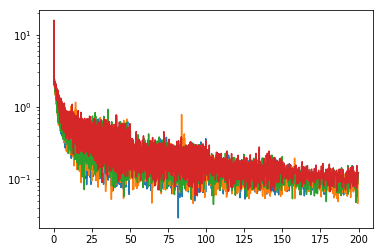

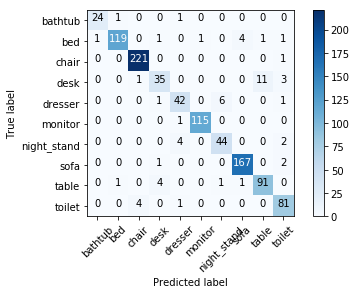

In [13]:
results = []

for i in range(4):
    model = CNN()
    if torch.cuda.is_available():
        model.cuda()

    data = train(model, skf.trainset(i, setAZR), 200) # (7) = 300 epoch  (9) = 200
    plot(data)

    results.append((
        test(model, skf.trainset(i, setAZRE)), 
        test(model, skf.testset(i, setAZRE))))
    
    print(results)
    
results = np.array(results)


plt.figure()
cm = confusion_matrix(model, skf.testset(3, setAZRE))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



allDone()

In [18]:
results

array([[0.98996991, 0.948     ],
       [0.98897427, 0.94288577],
       [0.98630595, 0.93981946],
       [0.98831386, 0.94277108]])

In [19]:
results.mean(0)

array([0.988391  , 0.94336908])

In [16]:
if False:
    results = []

    for trainset in [setNR, setR]:
        model = CNN()
        if torch.cuda.is_available():
            model.cuda()

        data = train(model, skf.trainset(0, trainset), 100)
        plot(data)

        for testset in [setNR, setR]:
            results.append((test(model, skf.trainset(0, trainset)), test(model, skf.trainset(0, testset))))

    print(results)

In [17]:
results

array([[0.98996991, 0.948     ],
       [0.98897427, 0.94288577],
       [0.98630595, 0.93981946],
       [0.98831386, 0.94277108]])